# CIFAR100 classification with EfficientNetV2L from scratch ( not using ImageNet weights)
* **EfficientNet V2L has about 118 milion parameters!**
* **TPU Distributed Training with Keras-3 and jax as its backend**

In [1]:
# Installing tensorflow-cpu to avoid tensorflow using TPUs
!pip install -q -U tensorflow-cpu

!pip install --upgrade -q keras


[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import os

os.environ['KERAS_BACKEND'] = 'jax'

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

# if you face OOM, uncomment this line bellow
# os.environ['XLA_PYTHON_CLIENT_ALLOCATOR']='platform'

## Setting Keras DataParallel strategy for distributed training

In [3]:
import keras

devices = keras.distribution.list_devices()
print(f'Available devices:{devices}')

data_parallel = keras.distribution.DataParallel(devices=devices)

# Or you can choose to create DataParallel with a 1D `DeviceMesh`.
mesh_1d = keras.distribution.DeviceMesh(
    shape=(8, ), axis_names=["data"], devices=devices
)
data_parallel = keras.distribution.DataParallel(device_mesh=mesh_1d)

# Set the global distribution.
keras.distribution.set_distribution(data_parallel)

E0000 00:00:1738446713.967223      74 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


Available devices:['tpu:0', 'tpu:1', 'tpu:2', 'tpu:3', 'tpu:4', 'tpu:5', 'tpu:6', 'tpu:7']


In [4]:
import numpy as np

import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import EfficientNetV2L

# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224
BATCH_SIZE = 32 * len(devices)

## Reproduction

In [5]:
keras.utils.set_random_seed(0)

## Mixed Precision Computation for lower memory usage and higher training speed

In [6]:
# using these two bad boys can increase the training step by over 200% in Keras3 + JAX + training loop from scratch
keras.config.set_dtype_policy("mixed_float16")
keras.mixed_precision.set_global_policy("mixed_float16")

## Loading dataset

In [7]:
ds_train, ds_test = keras.utils.image_dataset_from_directory(
    directory = '/kaggle/input/stanford-dogs-dataset/images/Images',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=None,
    image_size=(256, 256),
    shuffle=True,
    seed= 0,
    validation_split=0.2,
    subset='both', # training and validation
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True,
)

Found 20580 files belonging to 120 classes.


Using 16464 files for training.


Using 4116 files for validation.


In [8]:
import tensorflow as tf

size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

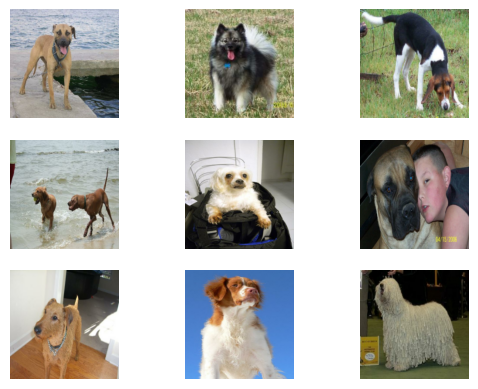

In [9]:
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))

    plt.axis("off")

In [10]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]


def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

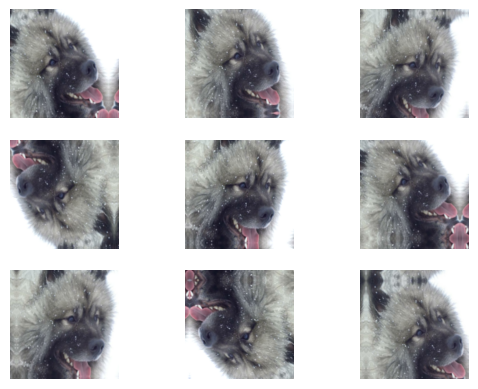

In [11]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(np.expand_dims(image.numpy(), axis=0))
        aug_img = np.array(aug_img)
        plt.imshow(aug_img[0].astype("uint8"))
        plt.axis("off")

## Data Augmentation

In [12]:
# One-hot / categorical encoding
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    return image, label


def input_preprocess_test(image, label):
    return image, label


ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)

## Model Creataion

In [13]:
from keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout
from keras.models import Sequential

def get_model():
    model = EfficientNetV2L(
    include_top=False,
    weights=None, # Training from scratch
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )

    model.trainable = True


    classifier = Sequential([
                             model,
                             GlobalAveragePooling2D(),
                             Dropout(0.1),
                             Dense(120, activation = 'softmax')])
    
    
    return classifier

In [14]:
model = get_model()

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'],
              jit_compile = True #Default is True, but here i wanted to show you that we use JIT compilation
             )

In [15]:
model.summary(show_trainable = True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ efficientnetv2-l            │ (None, 7, 7, 1280)    │ 117,746,8… │   Y   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 1280)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 1280)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 120)           │    153,720 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 117,900,568 (449.75 MB)

 Trainable params: 117,387,992 (447.80 MB)

 Non-trainable params: 512,576 (1.96 MB)

## Training the model

In [16]:
history = model.fit(ds_train, validation_data = ds_test, epochs = 100)

Epoch 1/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 4:48:36 275s/step - accuracy: 0.0078 - loss: 4.9133

 2/64 ━━━━━━━━━━━━━━━━━━━━ 19:20 19s/step - accuracy: 0.0107 - loss: 4.9106   

 3/64 ━━━━━━━━━━━━━━━━━━━━ 9:41 10s/step - accuracy: 0.0115 - loss: 4.9130 

 4/64 ━━━━━━━━━━━━━━━━━━━━ 6:28 6s/step - accuracy: 0.0120 - loss: 4.9292 

 5/64 ━━━━━━━━━━━━━━━━━━━━ 4:52 5s/step - accuracy: 0.0129 - loss: 4.9360

 6/64 ━━━━━━━━━━━━━━━━━━━━ 3:54 4s/step - accuracy: 0.0135 - loss: 4.9427

 7/64 ━━━━━━━━━━━━━━━━━━━━ 3:15 3s/step - accuracy: 0.0138 - loss: 4.9439

 8/64 ━━━━━━━━━━━━━━━━━━━━ 2:47 3s/step - accuracy: 0.0139 - loss: 4.9458

 9/64 ━━━━━━━━━━━━━━━━━━━━ 2:26 3s/step - accuracy: 0.0139 - loss: 4.9458

11/64 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - accuracy: 0.0136 - loss: 4.9451

10/64 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - accuracy: 0.0138 - loss: 4.9457

12/64 ━━━━━━━━━━━━━━━━━━━━ 1:45 2s/step - accuracy: 0.0135 - loss: 4.9438

15/64 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - accuracy: 0.0133 - loss: 4.9426

14/64 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - accuracy: 0.0133 - loss: 4.9419

13/64 ━━━━━━━━━━━━━━━━━━━━ 1:36 2s/step - accuracy: 0.0134 - loss: 4.9426

16/64 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - accuracy: 0.0133 - loss: 4.9411

17/64 ━━━━━━━━━━━━━━━━━━━━ 1:11 2s/step - accuracy: 0.0132 - loss: 4.9403

19/64 ━━━━━━━━━━━━━━━━━━━━ 1:02 1s/step - accuracy: 0.0131 - loss: 4.9394

24/64 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.0128 - loss: 4.9386 

22/64 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.0129 - loss: 4.9378 

25/64 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.0128 - loss: 4.9378

29/64 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.0126 - loss: 4.9370

27/64 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.0127 - loss: 4.9362

30/64 ━━━━━━━━━━━━━━━━━━━━ 33s 1000ms/step - accuracy: 0.0126 - loss: 4.9354

28/64 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.0127 - loss: 4.9354

31/64 ━━━━━━━━━━━━━━━━━━━━ 32s 979ms/step - accuracy: 0.0125 - loss: 4.9354

32/64 ━━━━━━━━━━━━━━━━━━━━ 30s 959ms/step - accuracy: 0.0125 - loss: 4.9346

33/64 ━━━━━━━━━━━━━━━━━━━━ 29s 941ms/step - accuracy: 0.0125 - loss: 4.9339

34/64 ━━━━━━━━━━━━━━━━━━━━ 27s 923ms/step - accuracy: 0.0125 - loss: 4.9331

35/64 ━━━━━━━━━━━━━━━━━━━━ 26s 907ms/step - accuracy: 0.0124 - loss: 4.9323

36/64 ━━━━━━━━━━━━━━━━━━━━ 24s 891ms/step - accuracy: 0.0124 - loss: 4.9300

37/64 ━━━━━━━━━━━━━━━━━━━━ 23s 877ms/step - accuracy: 0.0124 - loss: 4.9285

38/64 ━━━━━━━━━━━━━━━━━━━━ 22s 863ms/step - accuracy: 0.0124 - loss: 4.9271

39/64 ━━━━━━━━━━━━━━━━━━━━ 21s 850ms/step - accuracy: 0.0123 - loss: 4.9249

40/64 ━━━━━━━━━━━━━━━━━━━━ 20s 838ms/step - accuracy: 0.0123 - loss: 4.9242

42/64 ━━━━━━━━━━━━━━━━━━━━ 17s 814ms/step - accuracy: 0.0123 - loss: 4.9214

43/64 ━━━━━━━━━━━━━━━━━━━━ 16s 804ms/step - accuracy: 0.0123 - loss: 4.9207

45/64 ━━━━━━━━━━━━━━━━━━━━ 14s 784ms/step - accuracy: 0.0122 - loss: 4.9194

48/64 ━━━━━━━━━━━━━━━━━━━━ 12s 757ms/step - accuracy: 0.0122 - loss: 4.9181

47/64 ━━━━━━━━━━━━━━━━━━━━ 13s 766ms/step - accuracy: 0.0122 - loss: 4.9194

49/64 ━━━━━━━━━━━━━━━━━━━━ 11s 749ms/step - accuracy: 0.0122 - loss: 4.9168

51/64 ━━━━━━━━━━━━━━━━━━━━ 9s 734ms/step - accuracy: 0.0121 - loss: 4.9168 

54/64 ━━━━━━━━━━━━━━━━━━━━ 7s 713ms/step - accuracy: 0.0121 - loss: 4.9162 

52/64 ━━━━━━━━━━━━━━━━━━━━ 8s 727ms/step - accuracy: 0.0121 - loss: 4.9168

57/64 ━━━━━━━━━━━━━━━━━━━━ 4s 695ms/step - accuracy: 0.0120 - loss: 4.9150

61/64 ━━━━━━━━━━━━━━━━━━━━ 2s 673ms/step - accuracy: 0.0119 - loss: 4.9144

60/64 ━━━━━━━━━━━━━━━━━━━━ 2s 678ms/step - accuracy: 0.0119 - loss: 4.9144

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.0119 - loss: 4.9144

64/64 ━━━━━━━━━━━━━━━━━━━━ 354s 1s/step - accuracy: 0.0119 - loss: 4.9138 - val_accuracy: 0.0132 - val_loss: 5.0138


Epoch 2/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 56s 903ms/step - accuracy: 0.0117 - loss: 4.8159

 2/64 ━━━━━━━━━━━━━━━━━━━━ 23s 387ms/step - accuracy: 0.0107 - loss: 4.8159

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 376ms/step - accuracy: 0.0093 - loss: 4.8192

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 376ms/step - accuracy: 0.0087 - loss: 4.8233

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - accuracy: 0.0084 - loss: 4.8256

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 371ms/step - accuracy: 0.0085 - loss: 4.8258

 7/64 ━━━━━━━━━━━━━━━━━━━━ 21s 371ms/step - accuracy: 0.0087 - loss: 4.8263

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 370ms/step - accuracy: 0.0090 - loss: 4.8262

10/64 ━━━━━━━━━━━━━━━━━━━━ 21s 403ms/step - accuracy: 0.0098 - loss: 4.8264

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.0109 - loss: 4.8264

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 369ms/step - accuracy: 0.0112 - loss: 4.8263

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 369ms/step - accuracy: 0.0118 - loss: 4.8264

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 369ms/step - accuracy: 0.0120 - loss: 4.8263

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 369ms/step - accuracy: 0.0122 - loss: 4.8262

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 369ms/step - accuracy: 0.0124 - loss: 4.8261

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.0127 - loss: 4.8261

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.0128 - loss: 4.8260

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.0129 - loss: 4.8260

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.0130 - loss: 4.8258

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.0130 - loss: 4.8257

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.0131 - loss: 4.8256

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0131 - loss: 4.8256

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0131 - loss: 4.8254

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0131 - loss: 4.8254

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0132 - loss: 4.8249

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.0132 - loss: 4.8247

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0133 - loss: 4.8243 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0134 - loss: 4.8241

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0134 - loss: 4.8236

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0134 - loss: 4.8229

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0134 - loss: 4.8227

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0135 - loss: 4.8226

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.0135 - loss: 4.8226

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.0136 - loss: 4.8228

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.0136 - loss: 4.8229

55/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.0138 - loss: 4.8238

49/64 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.0137 - loss: 4.8231

56/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.0138 - loss: 4.8239

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.0138 - loss: 4.8240

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.0138 - loss: 4.8240

57/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.0138 - loss: 4.8240

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.0138 - loss: 4.8240

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0138 - loss: 4.8240

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0138 - loss: 4.8240

64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 407ms/step - accuracy: 0.0138 - loss: 4.8242 - val_accuracy: 0.0117 - val_loss: 4.8067


Epoch 3/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 919ms/step - accuracy: 0.0195 - loss: 4.8503

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.0166 - loss: 4.8548

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.0154 - loss: 4.8586

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.0155 - loss: 4.8581

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.0155 - loss: 4.8570

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.0154 - loss: 4.8566

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.0151 - loss: 4.8569

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.0148 - loss: 4.8568

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.0145 - loss: 4.8558

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.0142 - loss: 4.8548

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.0139 - loss: 4.8532

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.0138 - loss: 4.8522

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.0137 - loss: 4.8504

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.0137 - loss: 4.8508

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.0134 - loss: 4.8491

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.0133 - loss: 4.8487

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.0133 - loss: 4.8483

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.0132 - loss: 4.8483

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.0132 - loss: 4.8478

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0132 - loss: 4.8478

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.0132 - loss: 4.8474

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0132 - loss: 4.8467

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0133 - loss: 4.8464

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.0133 - loss: 4.8462

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.0133 - loss: 4.8462

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0133 - loss: 4.8456 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0133 - loss: 4.8447

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.0133 - loss: 4.8444

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0133 - loss: 4.8439

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0133 - loss: 4.8435

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.0133 - loss: 4.8431

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.0133 - loss: 4.8426

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.0133 - loss: 4.8422

48/64 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.0134 - loss: 4.8419

55/64 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step - accuracy: 0.0134 - loss: 4.8412

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.0135 - loss: 4.8411

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0135 - loss: 4.8411

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0135 - loss: 4.8409

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 406ms/step - accuracy: 0.0135 - loss: 4.8408 - val_accuracy: 0.0107 - val_loss: 4.7646


Epoch 4/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 918ms/step - accuracy: 0.0156 - loss: 4.8794

 2/64 ━━━━━━━━━━━━━━━━━━━━ 23s 377ms/step - accuracy: 0.0137 - loss: 4.8509

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 372ms/step - accuracy: 0.0143 - loss: 4.8375

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 370ms/step - accuracy: 0.0137 - loss: 4.8327

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.0134 - loss: 4.8295

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 371ms/step - accuracy: 0.0134 - loss: 4.8284

 7/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.0134 - loss: 4.8265

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - accuracy: 0.0133 - loss: 4.8245

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - accuracy: 0.0134 - loss: 4.8226

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.0133 - loss: 4.8219

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.0132 - loss: 4.8215

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.0134 - loss: 4.8200

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.0134 - loss: 4.8189

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.0136 - loss: 4.8182

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.0134 - loss: 4.8186

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.0136 - loss: 4.8174

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.0136 - loss: 4.8174

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.0137 - loss: 4.8170

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.0136 - loss: 4.8170

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.0138 - loss: 4.8165

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0140 - loss: 4.8161

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0141 - loss: 4.8156

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0142 - loss: 4.8147

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0143 - loss: 4.8138

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.0143 - loss: 4.8133

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.0144 - loss: 4.8133

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0144 - loss: 4.8111 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0145 - loss: 4.8111

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0145 - loss: 4.8094

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0145 - loss: 4.8090

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 379ms/step - accuracy: 0.0147 - loss: 4.8082

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 389ms/step - accuracy: 0.0146 - loss: 4.8078

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.0147 - loss: 4.8075

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.0147 - loss: 4.8071

47/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.0148 - loss: 4.8057

48/64 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.0148 - loss: 4.8054

50/64 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.0149 - loss: 4.8049

51/64 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.0149 - loss: 4.8049

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.0151 - loss: 4.8038

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.0151 - loss: 4.8038

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0151 - loss: 4.8038

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0151 - loss: 4.8035

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0152 - loss: 4.8035

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 405ms/step - accuracy: 0.0152 - loss: 4.8033 - val_accuracy: 0.0093 - val_loss: 4.8088


Epoch 5/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 919ms/step - accuracy: 0.0156 - loss: 4.7631

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.0166 - loss: 4.7676

 3/64 ━━━━━━━━━━━━━━━━━━━━ 23s 379ms/step - accuracy: 0.0167 - loss: 4.7709

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 367ms/step - accuracy: 0.0172 - loss: 4.7705

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.0172 - loss: 4.7686

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.0174 - loss: 4.7660

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.0177 - loss: 4.7644

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.0179 - loss: 4.7633

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.0181 - loss: 4.7622

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.0183 - loss: 4.7615

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.0185 - loss: 4.7606

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.0186 - loss: 4.7600

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.0188 - loss: 4.7589

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.0188 - loss: 4.7589

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.0189 - loss: 4.7577

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.0188 - loss: 4.7573

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.0188 - loss: 4.7573

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.0188 - loss: 4.7569

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.0188 - loss: 4.7569

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.0188 - loss: 4.7558

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0187 - loss: 4.7564

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.0187 - loss: 4.7558

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.0187 - loss: 4.7558

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0186 - loss: 4.7552

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0186 - loss: 4.7546

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0186 - loss: 4.7534

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.0186 - loss: 4.7527

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.0186 - loss: 4.7527

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0186 - loss: 4.7515 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0186 - loss: 4.7508

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0186 - loss: 4.7496

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.0186 - loss: 4.7483

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.0186 - loss: 4.7465

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.0186 - loss: 4.7453

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.0186 - loss: 4.7442

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.0186 - loss: 4.7425

53/64 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.0188 - loss: 4.7394

54/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.0188 - loss: 4.7394

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - accuracy: 0.0188 - loss: 4.7385

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - accuracy: 0.0189 - loss: 4.7389

58/64 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.0188 - loss: 4.7385

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0189 - loss: 4.7385

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 406ms/step - accuracy: 0.0189 - loss: 4.7380 - val_accuracy: 0.0269 - val_loss: 4.5493


Epoch 6/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 918ms/step - accuracy: 0.0195 - loss: 4.6369

 2/64 ━━━━━━━━━━━━━━━━━━━━ 23s 379ms/step - accuracy: 0.0225 - loss: 4.6388

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 374ms/step - accuracy: 0.0250 - loss: 4.6389

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 372ms/step - accuracy: 0.0268 - loss: 4.6382

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.0277 - loss: 4.6358

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.0282 - loss: 4.6351

 7/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.0282 - loss: 4.6319

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.0285 - loss: 4.6309

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - accuracy: 0.0288 - loss: 4.6294

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.0288 - loss: 4.6283

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.0287 - loss: 4.6242

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.0284 - loss: 4.6235

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.0280 - loss: 4.6225

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.0280 - loss: 4.6221

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.0279 - loss: 4.6221

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.0278 - loss: 4.6221

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.0277 - loss: 4.6214

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.0277 - loss: 4.6217

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.0276 - loss: 4.6214

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0275 - loss: 4.6209

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0274 - loss: 4.6209

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0274 - loss: 4.6205

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0274 - loss: 4.6205

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.0273 - loss: 4.6204

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.0273 - loss: 4.6202

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0273 - loss: 4.6199 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0273 - loss: 4.6196

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0273 - loss: 4.6194

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0273 - loss: 4.6192

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0273 - loss: 4.6190

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0272 - loss: 4.6189

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.0272 - loss: 4.6188

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.0272 - loss: 4.6187

49/64 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.0271 - loss: 4.6186

53/64 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.0270 - loss: 4.6185

52/64 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.0270 - loss: 4.6185

58/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.0269 - loss: 4.6184

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0267 - loss: 4.6184

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0267 - loss: 4.6184

64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 406ms/step - accuracy: 0.0267 - loss: 4.6183 - val_accuracy: 0.0293 - val_loss: 4.5354


Epoch 7/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 59s 943ms/step - accuracy: 0.0156 - loss: 4.5926

 2/64 ━━━━━━━━━━━━━━━━━━━━ 24s 393ms/step - accuracy: 0.0215 - loss: 4.5659

 3/64 ━━━━━━━━━━━━━━━━━━━━ 23s 381ms/step - accuracy: 0.0213 - loss: 4.5820

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 376ms/step - accuracy: 0.0211 - loss: 4.5842

 5/64 ━━━━━━━━━━━━━━━━━━━━ 22s 374ms/step - accuracy: 0.0220 - loss: 4.5872

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - accuracy: 0.0224 - loss: 4.5906

 7/64 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - accuracy: 0.0228 - loss: 4.5995

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 371ms/step - accuracy: 0.0230 - loss: 4.6019

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 372ms/step - accuracy: 0.0232 - loss: 4.6062

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 370ms/step - accuracy: 0.0235 - loss: 4.6126

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 370ms/step - accuracy: 0.0234 - loss: 4.6096

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 370ms/step - accuracy: 0.0237 - loss: 4.6155

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 369ms/step - accuracy: 0.0240 - loss: 4.6200

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 369ms/step - accuracy: 0.0242 - loss: 4.6210

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 369ms/step - accuracy: 0.0243 - loss: 4.6230

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 369ms/step - accuracy: 0.0244 - loss: 4.6239

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 369ms/step - accuracy: 0.0244 - loss: 4.6239

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 369ms/step - accuracy: 0.0245 - loss: 4.6254

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 369ms/step - accuracy: 0.0245 - loss: 4.6254

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.0246 - loss: 4.6260

26/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.0246 - loss: 4.6260

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 369ms/step - accuracy: 0.0246 - loss: 4.6260

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.0246 - loss: 4.6260

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0246 - loss: 4.6272

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0246 - loss: 4.6272

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0245 - loss: 4.6277

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0245 - loss: 4.6281

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0245 - loss: 4.6281

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.0245 - loss: 4.6292

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0245 - loss: 4.6292 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0245 - loss: 4.6298

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0245 - loss: 4.6299

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0245 - loss: 4.6300

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0245 - loss: 4.6301

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0245 - loss: 4.6301

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.0245 - loss: 4.6301

53/64 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.0246 - loss: 4.6297

50/64 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.0246 - loss: 4.6299

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0247 - loss: 4.6295

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0247 - loss: 4.6295

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 404ms/step - accuracy: 0.0247 - loss: 4.6294 - val_accuracy: 0.0288 - val_loss: 4.5273


Epoch 8/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 907ms/step - accuracy: 0.0312 - loss: 4.5879

 2/64 ━━━━━━━━━━━━━━━━━━━━ 23s 380ms/step - accuracy: 0.0273 - loss: 4.5842

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 376ms/step - accuracy: 0.0247 - loss: 4.5825

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 371ms/step - accuracy: 0.0229 - loss: 4.5767

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.0216 - loss: 4.5732

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.0211 - loss: 4.5696

 7/64 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.0208 - loss: 4.5657

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 370ms/step - accuracy: 0.0209 - loss: 4.5631

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - accuracy: 0.0209 - loss: 4.5643

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.0211 - loss: 4.5606

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.0213 - loss: 4.5559

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.0222 - loss: 4.5503

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 369ms/step - accuracy: 0.0219 - loss: 4.5522

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.0226 - loss: 4.5479

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.0224 - loss: 4.5479

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.0235 - loss: 4.5466

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.0230 - loss: 4.5466

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.0243 - loss: 4.5452

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.0239 - loss: 4.5459

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.0242 - loss: 4.5459

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.0241 - loss: 4.5452

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 369ms/step - accuracy: 0.0246 - loss: 4.5446

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0248 - loss: 4.5446

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0249 - loss: 4.5439

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0250 - loss: 4.5434

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0251 - loss: 4.5434

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0252 - loss: 4.5423

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.0253 - loss: 4.5418

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.0254 - loss: 4.5408

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0255 - loss: 4.5398 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0256 - loss: 4.5390

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0256 - loss: 4.5381

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0258 - loss: 4.5364

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0257 - loss: 4.5372

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0258 - loss: 4.5353

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.0261 - loss: 4.5344

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.0259 - loss: 4.5346

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.0260 - loss: 4.5344

48/64 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.0262 - loss: 4.5337

51/64 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.0263 - loss: 4.5331

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.0267 - loss: 4.5323

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.0268 - loss: 4.5320

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0269 - loss: 4.5320

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0269 - loss: 4.5323

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0270 - loss: 4.5320

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 403ms/step - accuracy: 0.0270 - loss: 4.5318 - val_accuracy: 0.0344 - val_loss: 4.4644


Epoch 9/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 56s 898ms/step - accuracy: 0.0273 - loss: 4.5004

 2/64 ━━━━━━━━━━━━━━━━━━━━ 23s 374ms/step - accuracy: 0.0254 - loss: 4.5001

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 371ms/step - accuracy: 0.0269 - loss: 4.4953

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 370ms/step - accuracy: 0.0280 - loss: 4.4884

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 371ms/step - accuracy: 0.0293 - loss: 4.4870

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.0297 - loss: 4.4858

 7/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.0296 - loss: 4.4850

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.0294 - loss: 4.4838

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.0293 - loss: 4.4832

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.0290 - loss: 4.4807

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.0290 - loss: 4.4799

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.0289 - loss: 4.4790

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.0290 - loss: 4.4777

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.0289 - loss: 4.4776

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.0292 - loss: 4.4770

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.0295 - loss: 4.4767

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.0295 - loss: 4.4767

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0297 - loss: 4.4765

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0297 - loss: 4.4760

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0297 - loss: 4.4758

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0297 - loss: 4.4756

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0298 - loss: 4.4756

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.0298 - loss: 4.4754

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.0298 - loss: 4.4749

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0298 - loss: 4.4747 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0298 - loss: 4.4741

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0298 - loss: 4.4736

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0298 - loss: 4.4731

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0298 - loss: 4.4729

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0298 - loss: 4.4725

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.0299 - loss: 4.4721

50/64 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.0301 - loss: 4.4716

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.0300 - loss: 4.4717

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0304 - loss: 4.4713

58/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.0303 - loss: 4.4713

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.0304 - loss: 4.4713

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0304 - loss: 4.4713

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 405ms/step - accuracy: 0.0305 - loss: 4.4712 - val_accuracy: 0.0364 - val_loss: 4.4392


Epoch 10/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 918ms/step - accuracy: 0.0273 - loss: 4.4798

 2/64 ━━━━━━━━━━━━━━━━━━━━ 24s 395ms/step - accuracy: 0.0273 - loss: 4.4607

 3/64 ━━━━━━━━━━━━━━━━━━━━ 23s 378ms/step - accuracy: 0.0273 - loss: 4.4545

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 374ms/step - accuracy: 0.0276 - loss: 4.4490

 5/64 ━━━━━━━━━━━━━━━━━━━━ 22s 373ms/step - accuracy: 0.0279 - loss: 4.4486

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - accuracy: 0.0278 - loss: 4.4482

 7/64 ━━━━━━━━━━━━━━━━━━━━ 21s 371ms/step - accuracy: 0.0277 - loss: 4.4475

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 371ms/step - accuracy: 0.0277 - loss: 4.4472

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 370ms/step - accuracy: 0.0277 - loss: 4.4471

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 370ms/step - accuracy: 0.0278 - loss: 4.4462

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.0280 - loss: 4.4437

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 369ms/step - accuracy: 0.0282 - loss: 4.4422

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 369ms/step - accuracy: 0.0284 - loss: 4.4402

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 369ms/step - accuracy: 0.0288 - loss: 4.4392

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 369ms/step - accuracy: 0.0289 - loss: 4.4387

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.0294 - loss: 4.4378

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.0295 - loss: 4.4378

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.0296 - loss: 4.4378

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.0297 - loss: 4.4375

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0298 - loss: 4.4375

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.0297 - loss: 4.4375

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0299 - loss: 4.4372

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0300 - loss: 4.4369

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0301 - loss: 4.4366

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0301 - loss: 4.4364

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0302 - loss: 4.4362

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.0303 - loss: 4.4362

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.0304 - loss: 4.4360

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0304 - loss: 4.4357 

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0305 - loss: 4.4351

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0306 - loss: 4.4348

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0306 - loss: 4.4345

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0307 - loss: 4.4342

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.0308 - loss: 4.4339

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.0310 - loss: 4.4338

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.0309 - loss: 4.4339

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.0318 - loss: 4.4336

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.0318 - loss: 4.4336

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0319 - loss: 4.4336

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0320 - loss: 4.4336

64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 406ms/step - accuracy: 0.0320 - loss: 4.4335 - val_accuracy: 0.0408 - val_loss: 4.3672


Epoch 11/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 59s 941ms/step - accuracy: 0.0391 - loss: 4.3926

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.0342 - loss: 4.3593

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 367ms/step - accuracy: 0.0328 - loss: 4.3533

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.0334 - loss: 4.3553

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.0334 - loss: 4.3574

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.0333 - loss: 4.3607

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.0335 - loss: 4.3631

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.0335 - loss: 4.3642

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.0337 - loss: 4.3669

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.0339 - loss: 4.3686

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.0341 - loss: 4.3701

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.0348 - loss: 4.3719

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.0353 - loss: 4.3723

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.0351 - loss: 4.3723

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.0356 - loss: 4.3729

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.0364 - loss: 4.3735

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.0361 - loss: 4.3735

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.0362 - loss: 4.3735

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.0365 - loss: 4.3739

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.0366 - loss: 4.3741

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0368 - loss: 4.3743

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.0367 - loss: 4.3743

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0368 - loss: 4.3745

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0368 - loss: 4.3748

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0368 - loss: 4.3747

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0368 - loss: 4.3749

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.0369 - loss: 4.3749

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0369 - loss: 4.3751 

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 374ms/step - accuracy: 0.0370 - loss: 4.3752

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 384ms/step - accuracy: 0.0370 - loss: 4.3752

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.0371 - loss: 4.3752

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.0371 - loss: 4.3752

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.0372 - loss: 4.3752

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.0372 - loss: 4.3753

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.0372 - loss: 4.3754

49/64 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.0374 - loss: 4.3758

55/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.0376 - loss: 4.3762

52/64 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.0375 - loss: 4.3760

57/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.0377 - loss: 4.3762

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 404ms/step - accuracy: 0.0380 - loss: 4.3762 - val_accuracy: 0.0461 - val_loss: 4.3285


Epoch 12/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 56s 896ms/step - accuracy: 0.0273 - loss: 4.3986

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.0322 - loss: 4.3746

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.0319 - loss: 4.3624

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.0322 - loss: 4.3536

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.0322 - loss: 4.3492

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.0329 - loss: 4.3477

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.0335 - loss: 4.3479

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.0344 - loss: 4.3478

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.0349 - loss: 4.3470

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.0357 - loss: 4.3446

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.0364 - loss: 4.3425

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.0367 - loss: 4.3413

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.0374 - loss: 4.3408

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.0376 - loss: 4.3402

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.0382 - loss: 4.3398

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.0393 - loss: 4.3396

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.0397 - loss: 4.3396

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.0400 - loss: 4.3392

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0402 - loss: 4.3392

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.0403 - loss: 4.3392

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0404 - loss: 4.3390

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0405 - loss: 4.3384

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0406 - loss: 4.3387

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0407 - loss: 4.3378

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.0408 - loss: 4.3374

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.0409 - loss: 4.3374

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.0410 - loss: 4.3369 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.0411 - loss: 4.3366

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0412 - loss: 4.3361

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0413 - loss: 4.3357

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.0414 - loss: 4.3353

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0415 - loss: 4.3348

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.0417 - loss: 4.3344

54/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.0427 - loss: 4.3337

50/64 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.0423 - loss: 4.3338

56/64 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.0428 - loss: 4.3334

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - accuracy: 0.0431 - loss: 4.3333

58/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.0430 - loss: 4.3333

57/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.0429 - loss: 4.3336

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.0431 - loss: 4.3333

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0432 - loss: 4.3333

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 406ms/step - accuracy: 0.0433 - loss: 4.3332 - val_accuracy: 0.0513 - val_loss: 4.2426


Epoch 13/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 912ms/step - accuracy: 0.0391 - loss: 4.2011

 2/64 ━━━━━━━━━━━━━━━━━━━━ 23s 375ms/step - accuracy: 0.0410 - loss: 4.2212

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 372ms/step - accuracy: 0.0417 - loss: 4.2481

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 370ms/step - accuracy: 0.0420 - loss: 4.2489

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.0431 - loss: 4.2512

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.0436 - loss: 4.2542

 7/64 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.0443 - loss: 4.2579

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - accuracy: 0.0445 - loss: 4.2612

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - accuracy: 0.0448 - loss: 4.2636

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.0448 - loss: 4.2645

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.0450 - loss: 4.2655

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.0451 - loss: 4.2657

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.0451 - loss: 4.2658

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.0452 - loss: 4.2660

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.0454 - loss: 4.2660

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.0456 - loss: 4.2660

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.0458 - loss: 4.2665

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.0463 - loss: 4.2669

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.0462 - loss: 4.2669

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.0466 - loss: 4.2669

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.0470 - loss: 4.2670

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.0469 - loss: 4.2670

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0471 - loss: 4.2671

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0471 - loss: 4.2671

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0472 - loss: 4.2671

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0472 - loss: 4.2671

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0473 - loss: 4.2672

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0473 - loss: 4.2674

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.0473 - loss: 4.2675

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.0474 - loss: 4.2675

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0474 - loss: 4.2677 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0475 - loss: 4.2678

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0475 - loss: 4.2680

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0475 - loss: 4.2681

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0476 - loss: 4.2682

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0476 - loss: 4.2683

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.0476 - loss: 4.2685

54/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.0478 - loss: 4.2688

55/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.0478 - loss: 4.2688

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.0480 - loss: 4.2689

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0481 - loss: 4.2690

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.0480 - loss: 4.2690

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0481 - loss: 4.2690

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 404ms/step - accuracy: 0.0481 - loss: 4.2690 - val_accuracy: 0.0527 - val_loss: 4.2322


Epoch 14/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 56s 896ms/step - accuracy: 0.0742 - loss: 4.1575

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.0703 - loss: 4.1706

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.0686 - loss: 4.1768

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.0658 - loss: 4.1833

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.0636 - loss: 4.1864

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.0621 - loss: 4.1894

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.0610 - loss: 4.1924

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.0605 - loss: 4.1938

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.0595 - loss: 4.1952

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.0590 - loss: 4.1975

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.0592 - loss: 4.1964

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.0589 - loss: 4.1990

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.0580 - loss: 4.2000

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.0578 - loss: 4.2000

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.0577 - loss: 4.2000

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0569 - loss: 4.2003

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.0572 - loss: 4.2003

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0569 - loss: 4.2004

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0568 - loss: 4.2006

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0568 - loss: 4.2007

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0568 - loss: 4.2009

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0567 - loss: 4.2009

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.0567 - loss: 4.2012

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.0567 - loss: 4.2017

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0566 - loss: 4.2023 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0566 - loss: 4.2024

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0566 - loss: 4.2028

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0565 - loss: 4.2030

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0565 - loss: 4.2034

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0564 - loss: 4.2042

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.0564 - loss: 4.2045

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.0563 - loss: 4.2051

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.0564 - loss: 4.2045

48/64 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.0563 - loss: 4.2061

55/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.0562 - loss: 4.2070

52/64 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.0562 - loss: 4.2070

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0559 - loss: 4.2076

51/64 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.0562 - loss: 4.2064

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.0560 - loss: 4.2073

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0559 - loss: 4.2076

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0559 - loss: 4.2076

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 403ms/step - accuracy: 0.0559 - loss: 4.2079 - val_accuracy: 0.0530 - val_loss: 4.2272


Epoch 15/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 917ms/step - accuracy: 0.0547 - loss: 4.1762

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.0615 - loss: 4.1675

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.0632 - loss: 4.1603

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 367ms/step - accuracy: 0.0635 - loss: 4.1593

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.0633 - loss: 4.1528

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.0634 - loss: 4.1528

 7/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.0636 - loss: 4.1554

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.0639 - loss: 4.1557

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.0639 - loss: 4.1557

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.0635 - loss: 4.1555

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.0629 - loss: 4.1540

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.0628 - loss: 4.1531

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.0628 - loss: 4.1523

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.0627 - loss: 4.1520

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.0627 - loss: 4.1520

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.0627 - loss: 4.1520

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.0627 - loss: 4.1520

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.0626 - loss: 4.1519

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0627 - loss: 4.1518

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.0628 - loss: 4.1517

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0627 - loss: 4.1517

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0629 - loss: 4.1517

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0629 - loss: 4.1516

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.0630 - loss: 4.1516

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.0631 - loss: 4.1515

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.0632 - loss: 4.1515

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0633 - loss: 4.1515 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0633 - loss: 4.1515

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0634 - loss: 4.1516

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.0634 - loss: 4.1518

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.0635 - loss: 4.1522

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.0636 - loss: 4.1523

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.0638 - loss: 4.1529

58/64 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.0638 - loss: 4.1529

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.0638 - loss: 4.1529

57/64 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.0638 - loss: 4.1529

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 403ms/step - accuracy: 0.0638 - loss: 4.1530 - val_accuracy: 0.0603 - val_loss: 4.1648


Epoch 16/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 58s 931ms/step - accuracy: 0.0430 - loss: 4.1632

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.0479 - loss: 4.1609

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 374ms/step - accuracy: 0.0484 - loss: 4.1596

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.0500 - loss: 4.1611

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.0509 - loss: 4.1551

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.0516 - loss: 4.1540

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.0525 - loss: 4.1495

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.0537 - loss: 4.1463

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.0546 - loss: 4.1437

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.0552 - loss: 4.1420

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.0560 - loss: 4.1407

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.0572 - loss: 4.1372

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.0581 - loss: 4.1352

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.0584 - loss: 4.1352

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.0587 - loss: 4.1342

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.0597 - loss: 4.1336

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.0601 - loss: 4.1330

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.0605 - loss: 4.1318

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.0606 - loss: 4.1311

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0608 - loss: 4.1311

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0607 - loss: 4.1306

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0609 - loss: 4.1306

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0610 - loss: 4.1301

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0611 - loss: 4.1295

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.0612 - loss: 4.1290

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.0613 - loss: 4.1285

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0614 - loss: 4.1275 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0615 - loss: 4.1261

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.0615 - loss: 4.1252

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0616 - loss: 4.1248

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.0617 - loss: 4.1240

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0618 - loss: 4.1233

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.0619 - loss: 4.1227

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.0622 - loss: 4.1216

47/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.0624 - loss: 4.1214

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.0633 - loss: 4.1202

57/64 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.0632 - loss: 4.1204

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.0634 - loss: 4.1200

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0636 - loss: 4.1200

64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 414ms/step - accuracy: 0.0636 - loss: 4.1198 - val_accuracy: 0.0615 - val_loss: 4.1240


Epoch 17/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 911ms/step - accuracy: 0.0742 - loss: 4.0474

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.0801 - loss: 4.0219

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.0803 - loss: 4.0287

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.0788 - loss: 4.0417

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.0780 - loss: 4.0518

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.0775 - loss: 4.0597

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.0774 - loss: 4.0642

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.0773 - loss: 4.0645

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.0770 - loss: 4.0649

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.0764 - loss: 4.0653

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.0756 - loss: 4.0649

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.0753 - loss: 4.0643

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.0752 - loss: 4.0643

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.0749 - loss: 4.0641

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.0750 - loss: 4.0642

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.0748 - loss: 4.0638

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.0745 - loss: 4.0638

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.0747 - loss: 4.0638

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.0743 - loss: 4.0635

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.0744 - loss: 4.0635

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0741 - loss: 4.0635

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.0742 - loss: 4.0634

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0740 - loss: 4.0630

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.0739 - loss: 4.0630

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0739 - loss: 4.0628

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.0739 - loss: 4.0626

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0738 - loss: 4.0623 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0738 - loss: 4.0621

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0737 - loss: 4.0621

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.0737 - loss: 4.0620

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.0737 - loss: 4.0621

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0736 - loss: 4.0620

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.0736 - loss: 4.0619

47/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.0736 - loss: 4.0620

51/64 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.0735 - loss: 4.0620

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0735 - loss: 4.0621

56/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.0735 - loss: 4.0621

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0735 - loss: 4.0622

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 406ms/step - accuracy: 0.0735 - loss: 4.0622 - val_accuracy: 0.0603 - val_loss: 4.1097


Epoch 18/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 906ms/step - accuracy: 0.0703 - loss: 4.0355

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 367ms/step - accuracy: 0.0703 - loss: 4.0355

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.0677 - loss: 4.0366

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.0679 - loss: 4.0358

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.0687 - loss: 4.0352

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.0693 - loss: 4.0353

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.0696 - loss: 4.0349

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.0696 - loss: 4.0347

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.0699 - loss: 4.0343

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.0699 - loss: 4.0338

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.0701 - loss: 4.0316

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.0699 - loss: 4.0324

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.0701 - loss: 4.0292

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.0701 - loss: 4.0279

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.0702 - loss: 4.0279

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.0707 - loss: 4.0264

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.0705 - loss: 4.0272

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.0704 - loss: 4.0279

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.0709 - loss: 4.0264

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.0711 - loss: 4.0251

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.0715 - loss: 4.0244

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0722 - loss: 4.0244

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.0719 - loss: 4.0238

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0724 - loss: 4.0238

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0726 - loss: 4.0233

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.0728 - loss: 4.0233

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0730 - loss: 4.0228

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0731 - loss: 4.0221

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.0733 - loss: 4.0221

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.0734 - loss: 4.0216

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0736 - loss: 4.0211 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.0737 - loss: 4.0208

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0738 - loss: 4.0204

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.0739 - loss: 4.0200

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0741 - loss: 4.0194

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.0740 - loss: 4.0196

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.0742 - loss: 4.0192

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.0743 - loss: 4.0189

47/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.0745 - loss: 4.0187

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0753 - loss: 4.0184

58/64 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.0751 - loss: 4.0184

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.0753 - loss: 4.0184

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.0751 - loss: 4.0184

57/64 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.0751 - loss: 4.0184

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0753 - loss: 4.0184

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.0752 - loss: 4.0184

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 403ms/step - accuracy: 0.0754 - loss: 4.0183 - val_accuracy: 0.0740 - val_loss: 4.0598


Epoch 19/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 55s 888ms/step - accuracy: 0.0859 - loss: 3.8409

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.0830 - loss: 3.8773

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.0805 - loss: 3.9301

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 367ms/step - accuracy: 0.0811 - loss: 3.9435

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.0807 - loss: 3.9592

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.0799 - loss: 3.9679

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.0794 - loss: 3.9741

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.0795 - loss: 3.9758

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.0794 - loss: 3.9764

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.0792 - loss: 3.9763

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.0790 - loss: 3.9756

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.0793 - loss: 3.9749

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.0796 - loss: 3.9748

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.0798 - loss: 3.9748

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.0807 - loss: 3.9747

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.0804 - loss: 3.9747

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.0808 - loss: 3.9747

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.0811 - loss: 3.9747

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.0810 - loss: 3.9747

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.0812 - loss: 3.9748

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0815 - loss: 3.9748

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0814 - loss: 3.9748

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0816 - loss: 3.9748

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0817 - loss: 3.9748

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0817 - loss: 3.9748

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0818 - loss: 3.9748

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.0819 - loss: 3.9748

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.0819 - loss: 3.9750

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0820 - loss: 3.9750 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0821 - loss: 3.9751

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0822 - loss: 3.9752

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0822 - loss: 3.9755

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0823 - loss: 3.9758

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.0825 - loss: 3.9769

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.0827 - loss: 3.9781

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.0826 - loss: 3.9775

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.0828 - loss: 3.9784

51/64 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.0831 - loss: 3.9794

50/64 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.0831 - loss: 3.9794

57/64 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.0833 - loss: 3.9800

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - accuracy: 0.0834 - loss: 3.9798

53/64 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.0832 - loss: 3.9798

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.0834 - loss: 3.9798

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0834 - loss: 3.9800

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 406ms/step - accuracy: 0.0835 - loss: 3.9802 - val_accuracy: 0.0857 - val_loss: 4.0034


Epoch 20/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 911ms/step - accuracy: 0.0859 - loss: 3.9546

 2/64 ━━━━━━━━━━━━━━━━━━━━ 23s 380ms/step - accuracy: 0.0801 - loss: 3.9726

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 371ms/step - accuracy: 0.0799 - loss: 3.9645

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 370ms/step - accuracy: 0.0811 - loss: 3.9605

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.0819 - loss: 3.9540

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.0825 - loss: 3.9520

 7/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.0831 - loss: 3.9468

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.0834 - loss: 3.9455

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.0839 - loss: 3.9436

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.0846 - loss: 3.9425

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.0851 - loss: 3.9409

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.0855 - loss: 3.9393

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.0863 - loss: 3.9373

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.0865 - loss: 3.9364

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.0867 - loss: 3.9358

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.0868 - loss: 3.9353

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.0867 - loss: 3.9358

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.0868 - loss: 3.9350

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.0868 - loss: 3.9350

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.0868 - loss: 3.9350

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.0866 - loss: 3.9350

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.0865 - loss: 3.9342

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0864 - loss: 3.9338

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0864 - loss: 3.9338

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0864 - loss: 3.9338

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0864 - loss: 3.9331

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0864 - loss: 3.9331

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.0864 - loss: 3.9323

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0865 - loss: 3.9319 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.0865 - loss: 3.9313

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 380ms/step - accuracy: 0.0865 - loss: 3.9306

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0866 - loss: 3.9303

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.0866 - loss: 3.9297

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.0866 - loss: 3.9291

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.0866 - loss: 3.9289

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.0866 - loss: 3.9287

48/64 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.0867 - loss: 3.9280

54/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.0868 - loss: 3.9277

50/64 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.0867 - loss: 3.9279

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.0870 - loss: 3.9276

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0871 - loss: 3.9276

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.0870 - loss: 3.9276

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.0871 - loss: 3.9276

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 404ms/step - accuracy: 0.0872 - loss: 3.9276 - val_accuracy: 0.0859 - val_loss: 3.9378


Epoch 21/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 56s 904ms/step - accuracy: 0.0664 - loss: 3.8761

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 361ms/step - accuracy: 0.0742 - loss: 3.8617

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 364ms/step - accuracy: 0.0777 - loss: 3.8609

 4/64 ━━━━━━━━━━━━━━━━━━━━ 21s 365ms/step - accuracy: 0.0773 - loss: 3.8665

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.0773 - loss: 3.8657

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - accuracy: 0.0779 - loss: 3.8660

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.0784 - loss: 3.8645

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.0791 - loss: 3.8632

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.0799 - loss: 3.8614

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.0806 - loss: 3.8608

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.0830 - loss: 3.8590

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.0814 - loss: 3.8602

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.0823 - loss: 3.8599

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.0836 - loss: 3.8589

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.0846 - loss: 3.8588

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.0861 - loss: 3.8581

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.0854 - loss: 3.8583

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.0850 - loss: 3.8583

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.0870 - loss: 3.8580

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.0880 - loss: 3.8580

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.0878 - loss: 3.8580

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.0882 - loss: 3.8578

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.0889 - loss: 3.8573

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.0891 - loss: 3.8570

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.0893 - loss: 3.8567

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.0895 - loss: 3.8564

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.0897 - loss: 3.8564

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.0899 - loss: 3.8560

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.0900 - loss: 3.8560 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.0902 - loss: 3.8556

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.0903 - loss: 3.8555

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.0904 - loss: 3.8554

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.0905 - loss: 3.8554

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.0907 - loss: 3.8554

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.0908 - loss: 3.8555

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.0909 - loss: 3.8555

51/64 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.0917 - loss: 3.8557

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - accuracy: 0.0925 - loss: 3.8558

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.0926 - loss: 3.8558

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.0926 - loss: 3.8558

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - accuracy: 0.0924 - loss: 3.8558

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 405ms/step - accuracy: 0.0927 - loss: 3.8559 - val_accuracy: 0.0930 - val_loss: 3.9294


Epoch 22/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 56s 896ms/step - accuracy: 0.0938 - loss: 3.9077

 2/64 ━━━━━━━━━━━━━━━━━━━━ 24s 390ms/step - accuracy: 0.0977 - loss: 3.8896

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 377ms/step - accuracy: 0.0998 - loss: 3.8792

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 373ms/step - accuracy: 0.1007 - loss: 3.8751

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - accuracy: 0.1008 - loss: 3.8757

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 371ms/step - accuracy: 0.1006 - loss: 3.8750

 7/64 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.1002 - loss: 3.8716

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 371ms/step - accuracy: 0.0997 - loss: 3.8700

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 370ms/step - accuracy: 0.0997 - loss: 3.8680

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.0997 - loss: 3.8657

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.0997 - loss: 3.8648

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.0999 - loss: 3.8605

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 369ms/step - accuracy: 0.1000 - loss: 3.8589

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 369ms/step - accuracy: 0.1003 - loss: 3.8544

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 369ms/step - accuracy: 0.1001 - loss: 3.8558

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.1002 - loss: 3.8516

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.1002 - loss: 3.8504

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 369ms/step - accuracy: 0.1001 - loss: 3.8479

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.1000 - loss: 3.8479

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.1000 - loss: 3.8479

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.0999 - loss: 3.8469

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.0999 - loss: 3.8469

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.0999 - loss: 3.8469

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.0999 - loss: 3.8449

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0999 - loss: 3.8439

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.0999 - loss: 3.8413

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.1000 - loss: 3.8413

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.1000 - loss: 3.8404

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.1001 - loss: 3.8381 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.1001 - loss: 3.8369

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.1002 - loss: 3.8359

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.1002 - loss: 3.8351

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.1003 - loss: 3.8347

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.1004 - loss: 3.8337

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.1005 - loss: 3.8331

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.1004 - loss: 3.8331

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.1006 - loss: 3.8328

47/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.1007 - loss: 3.8324

52/64 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.1008 - loss: 3.8315

53/64 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.1009 - loss: 3.8309

51/64 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.1008 - loss: 3.8312

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.1010 - loss: 3.8300

58/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.1010 - loss: 3.8300

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.1012 - loss: 3.8300

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 404ms/step - accuracy: 0.1012 - loss: 3.8297 - val_accuracy: 0.1028 - val_loss: 3.8741


Epoch 23/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 56s 899ms/step - accuracy: 0.1016 - loss: 3.7450

 2/64 ━━━━━━━━━━━━━━━━━━━━ 24s 400ms/step - accuracy: 0.0947 - loss: 3.7734

 3/64 ━━━━━━━━━━━━━━━━━━━━ 23s 383ms/step - accuracy: 0.0953 - loss: 3.7684

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 378ms/step - accuracy: 0.0951 - loss: 3.7711

 5/64 ━━━━━━━━━━━━━━━━━━━━ 22s 376ms/step - accuracy: 0.0958 - loss: 3.7789

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 374ms/step - accuracy: 0.0968 - loss: 3.7836

 7/64 ━━━━━━━━━━━━━━━━━━━━ 21s 373ms/step - accuracy: 0.0975 - loss: 3.7848

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 372ms/step - accuracy: 0.0980 - loss: 3.7841

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 371ms/step - accuracy: 0.0985 - loss: 3.7809

10/64 ━━━━━━━━━━━━━━━━━━━━ 20s 371ms/step - accuracy: 0.0989 - loss: 3.7801

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 371ms/step - accuracy: 0.0992 - loss: 3.7798

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 370ms/step - accuracy: 0.1012 - loss: 3.7788

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 370ms/step - accuracy: 0.1005 - loss: 3.7791

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 370ms/step - accuracy: 0.1018 - loss: 3.7788

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 370ms/step - accuracy: 0.1024 - loss: 3.7788

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 369ms/step - accuracy: 0.1028 - loss: 3.7786

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 369ms/step - accuracy: 0.1033 - loss: 3.7787

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 369ms/step - accuracy: 0.1039 - loss: 3.7789

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 369ms/step - accuracy: 0.1044 - loss: 3.7789

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 369ms/step - accuracy: 0.1046 - loss: 3.7789

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 369ms/step - accuracy: 0.1050 - loss: 3.7788

26/64 ━━━━━━━━━━━━━━━━━━━━ 14s 369ms/step - accuracy: 0.1050 - loss: 3.7788

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 369ms/step - accuracy: 0.1049 - loss: 3.7788

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 369ms/step - accuracy: 0.1050 - loss: 3.7788

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 369ms/step - accuracy: 0.1050 - loss: 3.7787

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 369ms/step - accuracy: 0.1050 - loss: 3.7787

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.1051 - loss: 3.7786

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.1052 - loss: 3.7782

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.1052 - loss: 3.7776 

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 369ms/step - accuracy: 0.1053 - loss: 3.7763

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.1054 - loss: 3.7758

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 369ms/step - accuracy: 0.1055 - loss: 3.7752

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.1056 - loss: 3.7747

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 374ms/step - accuracy: 0.1057 - loss: 3.7739

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.1060 - loss: 3.7739

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.1060 - loss: 3.7734

48/64 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.1062 - loss: 3.7732

53/64 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.1066 - loss: 3.7723

58/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.1069 - loss: 3.7720

55/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.1067 - loss: 3.7723

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.1071 - loss: 3.7718

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.1072 - loss: 3.7718

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.1071 - loss: 3.7718

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.1073 - loss: 3.7718

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 406ms/step - accuracy: 0.1073 - loss: 3.7717 - val_accuracy: 0.1021 - val_loss: 3.8668


Epoch 24/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 908ms/step - accuracy: 0.1211 - loss: 3.7881

 2/64 ━━━━━━━━━━━━━━━━━━━━ 24s 394ms/step - accuracy: 0.1270 - loss: 3.7777

 3/64 ━━━━━━━━━━━━━━━━━━━━ 23s 381ms/step - accuracy: 0.1272 - loss: 3.7640

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 377ms/step - accuracy: 0.1261 - loss: 3.7626

 5/64 ━━━━━━━━━━━━━━━━━━━━ 22s 374ms/step - accuracy: 0.1251 - loss: 3.7648

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 374ms/step - accuracy: 0.1235 - loss: 3.7625

 7/64 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - accuracy: 0.1219 - loss: 3.7607

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 371ms/step - accuracy: 0.1207 - loss: 3.7581

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 371ms/step - accuracy: 0.1198 - loss: 3.7551

10/64 ━━━━━━━━━━━━━━━━━━━━ 20s 370ms/step - accuracy: 0.1187 - loss: 3.7542

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 370ms/step - accuracy: 0.1179 - loss: 3.7527

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 370ms/step - accuracy: 0.1170 - loss: 3.7509

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 370ms/step - accuracy: 0.1163 - loss: 3.7496

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 370ms/step - accuracy: 0.1158 - loss: 3.7490

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 369ms/step - accuracy: 0.1153 - loss: 3.7475

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 369ms/step - accuracy: 0.1128 - loss: 3.7456

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 369ms/step - accuracy: 0.1139 - loss: 3.7462

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 369ms/step - accuracy: 0.1130 - loss: 3.7450

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 369ms/step - accuracy: 0.1123 - loss: 3.7444

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.1124 - loss: 3.7438

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.1123 - loss: 3.7438

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.1124 - loss: 3.7438

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.1124 - loss: 3.7433

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.1124 - loss: 3.7428

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.1124 - loss: 3.7416

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.1124 - loss: 3.7403

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 369ms/step - accuracy: 0.1125 - loss: 3.7391 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.1125 - loss: 3.7385

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.1126 - loss: 3.7370

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.1127 - loss: 3.7365

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.1128 - loss: 3.7358

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.1129 - loss: 3.7350

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.1131 - loss: 3.7333

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.1146 - loss: 3.7309

57/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.1143 - loss: 3.7309

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.1147 - loss: 3.7306

58/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.1144 - loss: 3.7309

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.1147 - loss: 3.7306

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 404ms/step - accuracy: 0.1148 - loss: 3.7304 - val_accuracy: 0.0764 - val_loss: 4.1594


Epoch 25/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 920ms/step - accuracy: 0.1484 - loss: 3.5689

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 367ms/step - accuracy: 0.1416 - loss: 3.5670

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 371ms/step - accuracy: 0.1369 - loss: 3.6247

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 367ms/step - accuracy: 0.1330 - loss: 3.6587

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.1318 - loss: 3.6767

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.1307 - loss: 3.6884

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.1297 - loss: 3.6919

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.1286 - loss: 3.6942

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.1278 - loss: 3.6972

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.1269 - loss: 3.6974

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.1256 - loss: 3.6969

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.1252 - loss: 3.6963

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.1248 - loss: 3.6951

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.1246 - loss: 3.6943

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.1244 - loss: 3.6932

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.1244 - loss: 3.6937

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.1246 - loss: 3.6921

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.1247 - loss: 3.6921

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.1247 - loss: 3.6915

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.1248 - loss: 3.6901

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.1249 - loss: 3.6901

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.1250 - loss: 3.6889

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.1250 - loss: 3.6889

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.1251 - loss: 3.6878

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.1252 - loss: 3.6878

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.1253 - loss: 3.6873 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.1253 - loss: 3.6862

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.1254 - loss: 3.6857

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.1255 - loss: 3.6851

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.1256 - loss: 3.6846

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.1256 - loss: 3.6841

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.1257 - loss: 3.6837

48/64 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.1257 - loss: 3.6822

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.1259 - loss: 3.6812

58/64 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.1259 - loss: 3.6814

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.1260 - loss: 3.6812

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 405ms/step - accuracy: 0.1260 - loss: 3.6809 - val_accuracy: 0.1023 - val_loss: 3.8079


Epoch 26/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 58s 925ms/step - accuracy: 0.1719 - loss: 3.6965

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.1611 - loss: 3.6477

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.1543 - loss: 3.6356

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 367ms/step - accuracy: 0.1489 - loss: 3.6337

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.1448 - loss: 3.6293

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.1424 - loss: 3.6336

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.1407 - loss: 3.6379

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.1393 - loss: 3.6392

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.1377 - loss: 3.6415

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.1361 - loss: 3.6429

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.1350 - loss: 3.6428

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.1333 - loss: 3.6420

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.1317 - loss: 3.6407

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.1308 - loss: 3.6403

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.1295 - loss: 3.6398

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.1297 - loss: 3.6398

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.1289 - loss: 3.6398

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.1288 - loss: 3.6391

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.1287 - loss: 3.6387

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.1288 - loss: 3.6391

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.1288 - loss: 3.6391

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.1287 - loss: 3.6384

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.1287 - loss: 3.6384

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.1287 - loss: 3.6380

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.1288 - loss: 3.6361

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.1288 - loss: 3.6375

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.1288 - loss: 3.6361

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.1288 - loss: 3.6352 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 383ms/step - accuracy: 0.1290 - loss: 3.6348

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.1291 - loss: 3.6340

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.1291 - loss: 3.6334

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.1291 - loss: 3.6331

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.1291 - loss: 3.6326

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.1292 - loss: 3.6324

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.1292 - loss: 3.6321

48/64 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.1292 - loss: 3.6313

51/64 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.1293 - loss: 3.6311

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - accuracy: 0.1296 - loss: 3.6311

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.1296 - loss: 3.6311

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.1297 - loss: 3.6311

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 403ms/step - accuracy: 0.1297 - loss: 3.6311 - val_accuracy: 0.0974 - val_loss: 3.9494


Epoch 27/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 911ms/step - accuracy: 0.1211 - loss: 3.6154

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.1230 - loss: 3.5989

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.1254 - loss: 3.5986

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.1300 - loss: 3.5977

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.1313 - loss: 3.6059

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.1318 - loss: 3.6118

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.1320 - loss: 3.6118

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.1320 - loss: 3.6132

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.1319 - loss: 3.6139

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.1316 - loss: 3.6142

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.1313 - loss: 3.6142

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.1312 - loss: 3.6140

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.1311 - loss: 3.6132

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.1310 - loss: 3.6129

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.1306 - loss: 3.6122

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.1306 - loss: 3.6113

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.1308 - loss: 3.6113

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.1310 - loss: 3.6108

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.1311 - loss: 3.6108

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.1312 - loss: 3.6108

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.1312 - loss: 3.6103

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.1313 - loss: 3.6093

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.1313 - loss: 3.6093

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.1314 - loss: 3.6087

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.1315 - loss: 3.6087

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.1316 - loss: 3.6082

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.1317 - loss: 3.6078

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.1317 - loss: 3.6070

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.1318 - loss: 3.6062

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.1318 - loss: 3.6056 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.1319 - loss: 3.6053

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.1320 - loss: 3.6051

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.1320 - loss: 3.6048

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.1321 - loss: 3.6046

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.1321 - loss: 3.6045

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.1322 - loss: 3.6043

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.1322 - loss: 3.6042

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.1323 - loss: 3.6041

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.1323 - loss: 3.6041

47/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.1323 - loss: 3.6041

56/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.1326 - loss: 3.6041

53/64 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.1325 - loss: 3.6041

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.1327 - loss: 3.6041

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.1327 - loss: 3.6041

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 405ms/step - accuracy: 0.1328 - loss: 3.6041 - val_accuracy: 0.1138 - val_loss: 3.8055


Epoch 28/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 917ms/step - accuracy: 0.1211 - loss: 3.4589

 2/64 ━━━━━━━━━━━━━━━━━━━━ 23s 380ms/step - accuracy: 0.1260 - loss: 3.4810

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 374ms/step - accuracy: 0.1243 - loss: 3.5438

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 372ms/step - accuracy: 0.1240 - loss: 3.5517

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 371ms/step - accuracy: 0.1248 - loss: 3.5624

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.1255 - loss: 3.5652

 7/64 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.1270 - loss: 3.5692

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - accuracy: 0.1285 - loss: 3.5707

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - accuracy: 0.1297 - loss: 3.5721

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.1302 - loss: 3.5741

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.1306 - loss: 3.5781

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 369ms/step - accuracy: 0.1320 - loss: 3.5847

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 369ms/step - accuracy: 0.1315 - loss: 3.5821

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.1324 - loss: 3.5860

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.1332 - loss: 3.5883

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 369ms/step - accuracy: 0.1330 - loss: 3.5883

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.1336 - loss: 3.5907

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.1342 - loss: 3.5907

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.1345 - loss: 3.5933

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.1344 - loss: 3.5933

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.1345 - loss: 3.5949

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.1346 - loss: 3.5949

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.1346 - loss: 3.5967

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.1347 - loss: 3.5978 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.1347 - loss: 3.5983

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.1348 - loss: 3.6002

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.1348 - loss: 3.6006

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.1348 - loss: 3.6013

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.1348 - loss: 3.6028

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.1347 - loss: 3.6032

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.1343 - loss: 3.6080

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.1343 - loss: 3.6080

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.1343 - loss: 3.6080

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 404ms/step - accuracy: 0.1342 - loss: 3.6084 - val_accuracy: 0.1140 - val_loss: 3.8014


Epoch 29/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 58s 934ms/step - accuracy: 0.1719 - loss: 3.5006

 2/64 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.1602 - loss: 3.5543

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 370ms/step - accuracy: 0.1506 - loss: 3.5800

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.1453 - loss: 3.5804

 7/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.1451 - loss: 3.5811

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.1452 - loss: 3.5821

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.1452 - loss: 3.5826

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.1449 - loss: 3.5824

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.1443 - loss: 3.5806

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.1440 - loss: 3.5784

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.1436 - loss: 3.5767

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.1433 - loss: 3.5757

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.1432 - loss: 3.5751

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.1432 - loss: 3.5735

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.1431 - loss: 3.5737

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.1431 - loss: 3.5724

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.1431 - loss: 3.5720

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.1430 - loss: 3.5712

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.1431 - loss: 3.5712

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.1432 - loss: 3.5708

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.1433 - loss: 3.5703 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.1434 - loss: 3.5695

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.1434 - loss: 3.5691

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.1435 - loss: 3.5687

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.1436 - loss: 3.5678

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.1436 - loss: 3.5668

47/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.1439 - loss: 3.5661

48/64 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.1439 - loss: 3.5664

52/64 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.1440 - loss: 3.5665

58/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.1440 - loss: 3.5666

54/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.1440 - loss: 3.5666

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.1440 - loss: 3.5666

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.1440 - loss: 3.5666

51/64 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.1439 - loss: 3.5666

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.1440 - loss: 3.5666

64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 406ms/step - accuracy: 0.1440 - loss: 3.5667 - val_accuracy: 0.1265 - val_loss: 3.7110


Epoch 30/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 58s 927ms/step - accuracy: 0.1289 - loss: 3.5487

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.1318 - loss: 3.5830

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.1287 - loss: 3.5837

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.1302 - loss: 3.5769

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.1324 - loss: 3.5723

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.1337 - loss: 3.5690

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.1342 - loss: 3.5603

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.1347 - loss: 3.5579

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.1349 - loss: 3.5539

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.1358 - loss: 3.5495

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.1353 - loss: 3.5522

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.1363 - loss: 3.5467

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.1366 - loss: 3.5438

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.1371 - loss: 3.5407

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.1375 - loss: 3.5390

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.1377 - loss: 3.5375

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.1387 - loss: 3.5348

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.1383 - loss: 3.5348

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.1396 - loss: 3.5325

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.1390 - loss: 3.5325

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.1405 - loss: 3.5312

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.1402 - loss: 3.5325

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.1418 - loss: 3.5300

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.1409 - loss: 3.5300

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.1421 - loss: 3.5300

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.1415 - loss: 3.5286

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.1424 - loss: 3.5286

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.1427 - loss: 3.5273

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.1430 - loss: 3.5248

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.1433 - loss: 3.5235

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.1436 - loss: 3.5235

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.1439 - loss: 3.5224 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.1442 - loss: 3.5193

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.1444 - loss: 3.5183

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.1447 - loss: 3.5155

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.1449 - loss: 3.5147

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.1453 - loss: 3.5118

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.1458 - loss: 3.5100

50/64 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.1467 - loss: 3.5063

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.1481 - loss: 3.5046

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - accuracy: 0.1484 - loss: 3.5046

57/64 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.1478 - loss: 3.5046

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.1488 - loss: 3.5046

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 406ms/step - accuracy: 0.1490 - loss: 3.5040 - val_accuracy: 0.1116 - val_loss: 3.8403


Epoch 31/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 913ms/step - accuracy: 0.1875 - loss: 3.3424

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.1826 - loss: 3.3479

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.1786 - loss: 3.3596

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.1764 - loss: 3.3569

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.1754 - loss: 3.3544

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.1750 - loss: 3.3574

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.1746 - loss: 3.3633

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.1745 - loss: 3.3650

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.1742 - loss: 3.3672

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.1741 - loss: 3.3676

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.1738 - loss: 3.3679

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.1738 - loss: 3.3681

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.1738 - loss: 3.3685

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.1739 - loss: 3.3684

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.1739 - loss: 3.3686

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.1739 - loss: 3.3690

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.1741 - loss: 3.3691

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.1741 - loss: 3.3692

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.1743 - loss: 3.3692

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.1743 - loss: 3.3693

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.1744 - loss: 3.3690

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.1743 - loss: 3.3690

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.1743 - loss: 3.3692

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.1744 - loss: 3.3690

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.1745 - loss: 3.3689

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.1745 - loss: 3.3688

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.1745 - loss: 3.3688

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.1746 - loss: 3.3688

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.1745 - loss: 3.3687 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.1746 - loss: 3.3689

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.1746 - loss: 3.3691

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.1746 - loss: 3.3693

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.1745 - loss: 3.3695

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.1745 - loss: 3.3698

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.1744 - loss: 3.3700

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.1744 - loss: 3.3698

52/64 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.1744 - loss: 3.3701

57/64 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.1744 - loss: 3.3701

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.1744 - loss: 3.3701

58/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.1744 - loss: 3.3701

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 404ms/step - accuracy: 0.1744 - loss: 3.3701 - val_accuracy: 0.1333 - val_loss: 3.6320


Epoch 32/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 56s 904ms/step - accuracy: 0.2188 - loss: 3.2578

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.2158 - loss: 3.2332

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.2155 - loss: 3.2357

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 367ms/step - accuracy: 0.2124 - loss: 3.2649

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 371ms/step - accuracy: 0.2085 - loss: 3.2799

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.2060 - loss: 3.2876

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.2042 - loss: 3.2954

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.2023 - loss: 3.2952

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.2010 - loss: 3.2954

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.2002 - loss: 3.2956

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.1988 - loss: 3.2954

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.1994 - loss: 3.2955

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.1985 - loss: 3.2955

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.1980 - loss: 3.2953

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.1967 - loss: 3.2948

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.1973 - loss: 3.2952

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.1964 - loss: 3.2948

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.1959 - loss: 3.2948

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.1957 - loss: 3.2947

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.1952 - loss: 3.2945

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.1954 - loss: 3.2945

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.1948 - loss: 3.2945

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.1942 - loss: 3.2941

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.1944 - loss: 3.2943

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.1940 - loss: 3.2940

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.1938 - loss: 3.2940

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.1936 - loss: 3.2935

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.1935 - loss: 3.2937

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.1933 - loss: 3.2935

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.1931 - loss: 3.2931 

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.1928 - loss: 3.2922

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.1927 - loss: 3.2922

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.1924 - loss: 3.2926

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 376ms/step - accuracy: 0.1922 - loss: 3.2929

48/64 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.1918 - loss: 3.2932

50/64 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.1915 - loss: 3.2933

51/64 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.1914 - loss: 3.2934

58/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.1905 - loss: 3.2938

55/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.1909 - loss: 3.2936

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.1902 - loss: 3.2940

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.1901 - loss: 3.2940

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.1900 - loss: 3.2940

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.1898 - loss: 3.2940

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 404ms/step - accuracy: 0.1897 - loss: 3.2941 - val_accuracy: 0.1123 - val_loss: 3.8150


Epoch 33/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 56s 902ms/step - accuracy: 0.1641 - loss: 3.3943

 2/64 ━━━━━━━━━━━━━━━━━━━━ 23s 371ms/step - accuracy: 0.1758 - loss: 3.3429

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 370ms/step - accuracy: 0.1788 - loss: 3.3223

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.1807 - loss: 3.3203

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.1824 - loss: 3.3189

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.1826 - loss: 3.3123

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.1830 - loss: 3.3073

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.1837 - loss: 3.3009

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - accuracy: 0.1844 - loss: 3.2956

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.1849 - loss: 3.2911

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.1861 - loss: 3.2844

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.1882 - loss: 3.2763

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.1887 - loss: 3.2763

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.1898 - loss: 3.2710

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.1900 - loss: 3.2722

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.1895 - loss: 3.2722

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.1915 - loss: 3.2710

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.1908 - loss: 3.2710

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.1911 - loss: 3.2698

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.1917 - loss: 3.2687

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.1922 - loss: 3.2687

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.1920 - loss: 3.2698

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.1924 - loss: 3.2687

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.1927 - loss: 3.2677

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.1929 - loss: 3.2669

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.1930 - loss: 3.2652

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.1933 - loss: 3.2652

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.1934 - loss: 3.2637

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.1935 - loss: 3.2637

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.1936 - loss: 3.2613 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.1937 - loss: 3.2613

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.1938 - loss: 3.2603

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.1939 - loss: 3.2589

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.1940 - loss: 3.2585

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.1942 - loss: 3.2571

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.1941 - loss: 3.2577

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.1942 - loss: 3.2566

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.1944 - loss: 3.2559

51/64 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.1947 - loss: 3.2550

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.1951 - loss: 3.2540

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.1950 - loss: 3.2540

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.1950 - loss: 3.2540

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.1950 - loss: 3.2540

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 405ms/step - accuracy: 0.1951 - loss: 3.2537 - val_accuracy: 0.1377 - val_loss: 3.6480


Epoch 34/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 916ms/step - accuracy: 0.1484 - loss: 3.3697

 2/64 ━━━━━━━━━━━━━━━━━━━━ 25s 407ms/step - accuracy: 0.1553 - loss: 3.3456

 3/64 ━━━━━━━━━━━━━━━━━━━━ 23s 388ms/step - accuracy: 0.1625 - loss: 3.3108

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 381ms/step - accuracy: 0.1693 - loss: 3.2897

 5/64 ━━━━━━━━━━━━━━━━━━━━ 22s 378ms/step - accuracy: 0.1748 - loss: 3.2790

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 375ms/step - accuracy: 0.1791 - loss: 3.2724

 7/64 ━━━━━━━━━━━━━━━━━━━━ 21s 374ms/step - accuracy: 0.1825 - loss: 3.2657

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 373ms/step - accuracy: 0.1847 - loss: 3.2594

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 372ms/step - accuracy: 0.1860 - loss: 3.2533

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 372ms/step - accuracy: 0.1883 - loss: 3.2436

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 371ms/step - accuracy: 0.1892 - loss: 3.2391

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 371ms/step - accuracy: 0.1901 - loss: 3.2348

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 371ms/step - accuracy: 0.1909 - loss: 3.2294

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 372ms/step - accuracy: 0.1918 - loss: 3.2277

18/64 ━━━━━━━━━━━━━━━━━━━━ 17s 370ms/step - accuracy: 0.1943 - loss: 3.2261

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 370ms/step - accuracy: 0.1928 - loss: 3.2294

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 370ms/step - accuracy: 0.1936 - loss: 3.2248

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 369ms/step - accuracy: 0.1971 - loss: 3.2234

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 369ms/step - accuracy: 0.1974 - loss: 3.2211

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 369ms/step - accuracy: 0.1986 - loss: 3.2200

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 369ms/step - accuracy: 0.1982 - loss: 3.2200

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 369ms/step - accuracy: 0.1984 - loss: 3.2200

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 369ms/step - accuracy: 0.1991 - loss: 3.2179

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 369ms/step - accuracy: 0.1993 - loss: 3.2158

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 369ms/step - accuracy: 0.1995 - loss: 3.2148

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 369ms/step - accuracy: 0.1996 - loss: 3.2148

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 369ms/step - accuracy: 0.1998 - loss: 3.2128 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 369ms/step - accuracy: 0.2000 - loss: 3.2108

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 369ms/step - accuracy: 0.2002 - loss: 3.2080

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 369ms/step - accuracy: 0.2004 - loss: 3.2071

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 369ms/step - accuracy: 0.2005 - loss: 3.2056

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 369ms/step - accuracy: 0.2007 - loss: 3.2043

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.2010 - loss: 3.2019

54/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.2021 - loss: 3.1987

56/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.2023 - loss: 3.1982

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.2029 - loss: 3.1978

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.2028 - loss: 3.1982

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.2027 - loss: 3.1982

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.2029 - loss: 3.1978

64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 407ms/step - accuracy: 0.2031 - loss: 3.1973 - val_accuracy: 0.1487 - val_loss: 3.5855


Epoch 35/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 913ms/step - accuracy: 0.1758 - loss: 3.2410

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.1768 - loss: 3.2260

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 370ms/step - accuracy: 0.1847 - loss: 3.1543

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 367ms/step - accuracy: 0.1890 - loss: 3.1484

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.1908 - loss: 3.1416

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.1928 - loss: 3.1404

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.1946 - loss: 3.1399

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.1958 - loss: 3.1374

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.1970 - loss: 3.1341

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.1978 - loss: 3.1311

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.1988 - loss: 3.1290

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.2016 - loss: 3.1215

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.2033 - loss: 3.1193

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.2024 - loss: 3.1193

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.2066 - loss: 3.1162

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.2071 - loss: 3.1152

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.2080 - loss: 3.1152

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.2087 - loss: 3.1143

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.2083 - loss: 3.1152

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.2097 - loss: 3.1143

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.2100 - loss: 3.1123

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.2106 - loss: 3.1112

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.2110 - loss: 3.1102

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.2113 - loss: 3.1102

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.2116 - loss: 3.1082

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.2119 - loss: 3.1082

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.2122 - loss: 3.1073 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.2125 - loss: 3.1058

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.2128 - loss: 3.1046

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.2130 - loss: 3.1036

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.2132 - loss: 3.1028

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.2135 - loss: 3.1021

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.2137 - loss: 3.1013

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.2142 - loss: 3.1001

57/64 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.2154 - loss: 3.0984

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.2160 - loss: 3.0982

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.2160 - loss: 3.0982

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.2161 - loss: 3.0982

64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 419ms/step - accuracy: 0.2162 - loss: 3.0980 - val_accuracy: 0.1426 - val_loss: 3.6571


Epoch 36/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 56s 894ms/step - accuracy: 0.2422 - loss: 3.0641

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.2451 - loss: 3.0581

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.2428 - loss: 3.0577

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.2402 - loss: 3.0561

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.2387 - loss: 3.0521

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.2380 - loss: 3.0494

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.2374 - loss: 3.0445

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.2365 - loss: 3.0397

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.2364 - loss: 3.0361

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.2362 - loss: 3.0311

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.2363 - loss: 3.0331

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.2367 - loss: 3.0281

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.2371 - loss: 3.0273

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.2376 - loss: 3.0271

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.2379 - loss: 3.0264

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.2378 - loss: 3.0264

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.2378 - loss: 3.0263

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.2376 - loss: 3.0263

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.2377 - loss: 3.0263

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.2372 - loss: 3.0263

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.2369 - loss: 3.0262

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.2369 - loss: 3.0262

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.2368 - loss: 3.0262

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.2367 - loss: 3.0261

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.2367 - loss: 3.0260

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.2366 - loss: 3.0259

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.2366 - loss: 3.0259

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.2365 - loss: 3.0256

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.2364 - loss: 3.0256 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.2364 - loss: 3.0254

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.2364 - loss: 3.0253

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.2364 - loss: 3.0251

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.2363 - loss: 3.0251

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.2363 - loss: 3.0251

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.2362 - loss: 3.0248

56/64 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.2360 - loss: 3.0248

57/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.2360 - loss: 3.0247

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.2362 - loss: 3.0246

55/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.2360 - loss: 3.0248

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.2359 - loss: 3.0248

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 405ms/step - accuracy: 0.2357 - loss: 3.0249 - val_accuracy: 0.1221 - val_loss: 3.8230


Epoch 37/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 56s 894ms/step - accuracy: 0.2773 - loss: 2.9129

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.2510 - loss: 3.0111

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.2433 - loss: 3.0365

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.2369 - loss: 3.0440

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.2325 - loss: 3.0514

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.2294 - loss: 3.0521

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.2273 - loss: 3.0513

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.2261 - loss: 3.0502

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.2260 - loss: 3.0466

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.2266 - loss: 3.0432

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.2274 - loss: 3.0381

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.2279 - loss: 3.0360

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.2297 - loss: 3.0341

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.2303 - loss: 3.0329

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.2290 - loss: 3.0341

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.2321 - loss: 3.0302

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.2328 - loss: 3.0290

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.2331 - loss: 3.0277

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.2330 - loss: 3.0266

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.2335 - loss: 3.0266

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.2341 - loss: 3.0243

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.2344 - loss: 3.0243

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.2346 - loss: 3.0224

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.2349 - loss: 3.0214

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.2352 - loss: 3.0214

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.2354 - loss: 3.0205

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.2360 - loss: 3.0169 

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.2357 - loss: 3.0178

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.2362 - loss: 3.0152 

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.2365 - loss: 3.0135

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.2367 - loss: 3.0120

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.2370 - loss: 3.0099

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.2375 - loss: 3.0081

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.2377 - loss: 3.0075

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.2372 - loss: 3.0081

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.2382 - loss: 3.0069

49/64 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.2388 - loss: 3.0051

54/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.2396 - loss: 3.0035

48/64 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.2386 - loss: 3.0057

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.2408 - loss: 3.0024

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.2411 - loss: 3.0024

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 405ms/step - accuracy: 0.2412 - loss: 3.0019 - val_accuracy: 0.1729 - val_loss: 3.5254


Epoch 38/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 58s 931ms/step - accuracy: 0.2148 - loss: 3.0133

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 370ms/step - accuracy: 0.2266 - loss: 2.9589

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 373ms/step - accuracy: 0.2335 - loss: 2.9184

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.2357 - loss: 2.9035

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.2385 - loss: 2.8921

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.2407 - loss: 2.8868

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.2417 - loss: 2.8844

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.2440 - loss: 2.8838

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.2453 - loss: 2.8829

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.2461 - loss: 2.8818

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.2477 - loss: 2.8844

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.2469 - loss: 2.8828

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.2487 - loss: 2.8850

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.2506 - loss: 2.8856

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.2526 - loss: 2.8867

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.2528 - loss: 2.8878

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.2527 - loss: 2.8878

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 369ms/step - accuracy: 0.2521 - loss: 2.8867

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.2534 - loss: 2.8884

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.2532 - loss: 2.8878

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.2536 - loss: 2.8891

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.2537 - loss: 2.8884

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.2537 - loss: 2.8891

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.2536 - loss: 2.8903

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.2536 - loss: 2.8903

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.2536 - loss: 2.8918

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.2536 - loss: 2.8925

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.2535 - loss: 2.8942 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.2535 - loss: 2.8949

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.2535 - loss: 2.8960

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.2534 - loss: 2.8970

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.2534 - loss: 2.8975

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.2534 - loss: 2.8993

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.2534 - loss: 2.8999

45/64 ━━━━━━━━━━━━━━━━━━━━ 7s 373ms/step - accuracy: 0.2534 - loss: 2.9010

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.2534 - loss: 2.9014

49/64 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.2533 - loss: 2.9029

50/64 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.2532 - loss: 2.9034

56/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.2530 - loss: 2.9047

53/64 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.2531 - loss: 2.9047

54/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.2531 - loss: 2.9047

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.2529 - loss: 2.9055

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.2527 - loss: 2.9055

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 404ms/step - accuracy: 0.2526 - loss: 2.9059 - val_accuracy: 0.1768 - val_loss: 3.4457


Epoch 39/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 56s 895ms/step - accuracy: 0.2695 - loss: 2.8815

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.2559 - loss: 2.9056

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 375ms/step - accuracy: 0.2496 - loss: 2.9218

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 367ms/step - accuracy: 0.2480 - loss: 2.9232

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.2473 - loss: 2.9245

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.2474 - loss: 2.9290

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.2475 - loss: 2.9308

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.2482 - loss: 2.9300

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.2491 - loss: 2.9272

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.2493 - loss: 2.9243

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.2495 - loss: 2.9217

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.2498 - loss: 2.9183

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.2504 - loss: 2.9173

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.2517 - loss: 2.9133

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.2524 - loss: 2.9143

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.2550 - loss: 2.9104

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.2539 - loss: 2.9124

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.2545 - loss: 2.9104

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.2555 - loss: 2.9093

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.2575 - loss: 2.9093

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.2571 - loss: 2.9093

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.2584 - loss: 2.9083

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.2581 - loss: 2.9073

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.2590 - loss: 2.9064

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.2593 - loss: 2.9064

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.2596 - loss: 2.9056

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.2599 - loss: 2.9049

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.2601 - loss: 2.9041

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.2603 - loss: 2.9033

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.2605 - loss: 2.9026 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.2607 - loss: 2.9011

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.2609 - loss: 2.8988

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.2610 - loss: 2.8973

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.2612 - loss: 2.8958

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.2614 - loss: 2.8942

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.2615 - loss: 2.8920

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.2617 - loss: 2.8907

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.2618 - loss: 2.8900

49/64 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.2623 - loss: 2.8895

50/64 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.2625 - loss: 2.8876

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.2636 - loss: 2.8858

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.2637 - loss: 2.8858

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 403ms/step - accuracy: 0.2638 - loss: 2.8852 - val_accuracy: 0.2000 - val_loss: 3.3070


Epoch 40/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 56s 895ms/step - accuracy: 0.2852 - loss: 2.7195

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.2861 - loss: 2.6966

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.2841 - loss: 2.6899

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.2841 - loss: 2.6907

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.2852 - loss: 2.6981

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.2852 - loss: 2.7013

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.2842 - loss: 2.7050

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.2835 - loss: 2.7063

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.2833 - loss: 2.7096

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.2836 - loss: 2.7111

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.2836 - loss: 2.7142

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.2835 - loss: 2.7182

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.2836 - loss: 2.7210

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.2833 - loss: 2.7224

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.2831 - loss: 2.7232

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.2827 - loss: 2.7234

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.2828 - loss: 2.7234

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.2827 - loss: 2.7234

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.2828 - loss: 2.7234

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.2827 - loss: 2.7236

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.2827 - loss: 2.7235

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.2828 - loss: 2.7235

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.2829 - loss: 2.7237

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.2831 - loss: 2.7237

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.2832 - loss: 2.7237

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.2833 - loss: 2.7240

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.2834 - loss: 2.7240

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.2835 - loss: 2.7242 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.2835 - loss: 2.7244

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.2835 - loss: 2.7247

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.2836 - loss: 2.7248

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.2837 - loss: 2.7255

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.2836 - loss: 2.7252

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.2837 - loss: 2.7255

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.2837 - loss: 2.7255

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.2838 - loss: 2.7254

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.2838 - loss: 2.7254

56/64 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.2843 - loss: 2.7251

52/64 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.2841 - loss: 2.7252

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.2846 - loss: 2.7251

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.2847 - loss: 2.7251

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.2848 - loss: 2.7251

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 405ms/step - accuracy: 0.2848 - loss: 2.7251 - val_accuracy: 0.1870 - val_loss: 3.4112


Epoch 41/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 58s 929ms/step - accuracy: 0.3047 - loss: 2.6592

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 365ms/step - accuracy: 0.3027 - loss: 2.7048

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 366ms/step - accuracy: 0.2964 - loss: 2.7168

 4/64 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - accuracy: 0.2939 - loss: 2.7294

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.2917 - loss: 2.7344

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.2912 - loss: 2.7339

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.2908 - loss: 2.7353

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.2909 - loss: 2.7358

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.2916 - loss: 2.7358

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.2924 - loss: 2.7336

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.2927 - loss: 2.7291

13/64 ━━━━━━━━━━━━━━━━━━━━ 21s 412ms/step - accuracy: 0.2937 - loss: 2.7239

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.2932 - loss: 2.7255

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.2946 - loss: 2.7223

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.2950 - loss: 2.7196

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.2954 - loss: 2.7185

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.2959 - loss: 2.7172

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.2963 - loss: 2.7161

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.2966 - loss: 2.7146

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.2974 - loss: 2.7138

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.2980 - loss: 2.7125

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.2979 - loss: 2.7131

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.2981 - loss: 2.7125

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.2983 - loss: 2.7120

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.2984 - loss: 2.7116

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.2985 - loss: 2.7107

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.2984 - loss: 2.7111

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.2986 - loss: 2.7107

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.2986 - loss: 2.7101

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.2987 - loss: 2.7097

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.2987 - loss: 2.7092

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.2987 - loss: 2.7086 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.2988 - loss: 2.7081

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.2988 - loss: 2.7071

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.2988 - loss: 2.7056

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.2988 - loss: 2.7056

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.2988 - loss: 2.7048

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.2988 - loss: 2.7038

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.2989 - loss: 2.7035

47/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.2989 - loss: 2.7029

48/64 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.2990 - loss: 2.7024

58/64 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.2990 - loss: 2.7005

50/64 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.2990 - loss: 2.7021

53/64 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.2990 - loss: 2.7011

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.2990 - loss: 2.7005

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.2990 - loss: 2.7002

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.2991 - loss: 2.7002

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 405ms/step - accuracy: 0.2991 - loss: 2.6999 - val_accuracy: 0.1743 - val_loss: 3.4517


Epoch 42/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 58s 924ms/step - accuracy: 0.3359 - loss: 2.5444

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 360ms/step - accuracy: 0.3301 - loss: 2.5829

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 364ms/step - accuracy: 0.3316 - loss: 2.5788

 4/64 ━━━━━━━━━━━━━━━━━━━━ 21s 365ms/step - accuracy: 0.3298 - loss: 2.5833

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - accuracy: 0.3269 - loss: 2.5934

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - accuracy: 0.3254 - loss: 2.6013

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 366ms/step - accuracy: 0.3239 - loss: 2.6047

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 366ms/step - accuracy: 0.3223 - loss: 2.6074

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.3214 - loss: 2.6105

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.3210 - loss: 2.6119

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.3205 - loss: 2.6149

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.3205 - loss: 2.6159

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.3205 - loss: 2.6164

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.3202 - loss: 2.6161

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.3200 - loss: 2.6158

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.3204 - loss: 2.6158

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.3196 - loss: 2.6149

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.3192 - loss: 2.6142

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.3190 - loss: 2.6142

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.3190 - loss: 2.6137

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.3190 - loss: 2.6130

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.3191 - loss: 2.6125

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.3191 - loss: 2.6125

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.3192 - loss: 2.6113

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.3193 - loss: 2.6113

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.3194 - loss: 2.6108

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.3194 - loss: 2.6100

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.3195 - loss: 2.6091 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.3196 - loss: 2.6081

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.3197 - loss: 2.6076

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.3197 - loss: 2.6062

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.3198 - loss: 2.6050

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.3199 - loss: 2.6042

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.3202 - loss: 2.6030

47/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.3203 - loss: 2.6021

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.3202 - loss: 2.6025

54/64 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step - accuracy: 0.3207 - loss: 2.6011

58/64 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.3209 - loss: 2.5998

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - accuracy: 0.3210 - loss: 2.5998

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.3212 - loss: 2.5994

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - accuracy: 0.3211 - loss: 2.5994

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.3213 - loss: 2.5994

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 404ms/step - accuracy: 0.3213 - loss: 2.5990 - val_accuracy: 0.2349 - val_loss: 3.1564


Epoch 43/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 58s 933ms/step - accuracy: 0.3320 - loss: 2.5292

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 370ms/step - accuracy: 0.3262 - loss: 2.5317

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.3199 - loss: 2.5381

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.3185 - loss: 2.5517

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.3179 - loss: 2.5615

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.3173 - loss: 2.5688

 7/64 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.3163 - loss: 2.5705

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.3163 - loss: 2.5716

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.3161 - loss: 2.5730

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.3159 - loss: 2.5750

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.3162 - loss: 2.5758

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.3166 - loss: 2.5783

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.3167 - loss: 2.5796

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.3168 - loss: 2.5808

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.3164 - loss: 2.5817

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.3163 - loss: 2.5819

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.3161 - loss: 2.5821

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.3162 - loss: 2.5821

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.3157 - loss: 2.5821

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.3159 - loss: 2.5821

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.3156 - loss: 2.5821

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.3153 - loss: 2.5822

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.3151 - loss: 2.5823

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.3152 - loss: 2.5824

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.3151 - loss: 2.5824

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.3152 - loss: 2.5827

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.3152 - loss: 2.5827

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.3153 - loss: 2.5827

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.3153 - loss: 2.5827 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.3154 - loss: 2.5828

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.3155 - loss: 2.5827

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.3155 - loss: 2.5824

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.3156 - loss: 2.5821

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.3157 - loss: 2.5820

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.3157 - loss: 2.5818

49/64 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.3164 - loss: 2.5800

51/64 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.3165 - loss: 2.5797

54/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.3169 - loss: 2.5790

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - accuracy: 0.3175 - loss: 2.5790

56/64 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.3170 - loss: 2.5790

64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 406ms/step - accuracy: 0.3180 - loss: 2.5787 - val_accuracy: 0.2354 - val_loss: 3.1699


Epoch 44/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 56s 897ms/step - accuracy: 0.3750 - loss: 2.4704

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.3643 - loss: 2.4614

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 372ms/step - accuracy: 0.3605 - loss: 2.4627

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.3556 - loss: 2.4611

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.3537 - loss: 2.4527

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.3529 - loss: 2.4545

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.3532 - loss: 2.4564

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - accuracy: 0.3535 - loss: 2.4573

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.3533 - loss: 2.4586

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.3526 - loss: 2.4587

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.3523 - loss: 2.4628

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.3520 - loss: 2.4634

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.3523 - loss: 2.4634

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.3520 - loss: 2.4635

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.3521 - loss: 2.4635

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.3521 - loss: 2.4635

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.3522 - loss: 2.4635

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.3507 - loss: 2.4630

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.3515 - loss: 2.4633

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.3509 - loss: 2.4630

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.3505 - loss: 2.4622

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.3502 - loss: 2.4618

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.3501 - loss: 2.4618

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.3500 - loss: 2.4619

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.3500 - loss: 2.4619

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.3499 - loss: 2.4623

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.3499 - loss: 2.4624

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.3497 - loss: 2.4628 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.3496 - loss: 2.4631

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.3495 - loss: 2.4636

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.3494 - loss: 2.4641

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.3493 - loss: 2.4648

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.3492 - loss: 2.4656

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.3487 - loss: 2.4665

53/64 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.3476 - loss: 2.4684

52/64 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.3477 - loss: 2.4684

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.3467 - loss: 2.4697

58/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.3470 - loss: 2.4701

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.3462 - loss: 2.4701

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 403ms/step - accuracy: 0.3461 - loss: 2.4705 - val_accuracy: 0.1982 - val_loss: 3.3238


Epoch 45/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 911ms/step - accuracy: 0.3320 - loss: 2.4778

 2/64 ━━━━━━━━━━━━━━━━━━━━ 24s 402ms/step - accuracy: 0.3389 - loss: 2.5038

 3/64 ━━━━━━━━━━━━━━━━━━━━ 23s 380ms/step - accuracy: 0.3409 - loss: 2.5205

 4/64 ━━━━━━━━━━━━━━━━━━━━ 29s 488ms/step - accuracy: 0.3424 - loss: 2.5205

 5/64 ━━━━━━━━━━━━━━━━━━━━ 22s 379ms/step - accuracy: 0.3440 - loss: 2.5159

 6/64 ━━━━━━━━━━━━━━━━━━━━ 22s 395ms/step - accuracy: 0.3440 - loss: 2.5180

 7/64 ━━━━━━━━━━━━━━━━━━━━ 22s 390ms/step - accuracy: 0.3441 - loss: 2.5109

 8/64 ━━━━━━━━━━━━━━━━━━━━ 21s 387ms/step - accuracy: 0.3444 - loss: 2.5054

 9/64 ━━━━━━━━━━━━━━━━━━━━ 21s 384ms/step - accuracy: 0.3445 - loss: 2.5054

10/64 ━━━━━━━━━━━━━━━━━━━━ 20s 383ms/step - accuracy: 0.3445 - loss: 2.4984

11/64 ━━━━━━━━━━━━━━━━━━━━ 20s 381ms/step - accuracy: 0.3447 - loss: 2.4928

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 380ms/step - accuracy: 0.3447 - loss: 2.4875

13/64 ━━━━━━━━━━━━━━━━━━━━ 19s 379ms/step - accuracy: 0.3448 - loss: 2.4816

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 378ms/step - accuracy: 0.3448 - loss: 2.4754

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 377ms/step - accuracy: 0.3448 - loss: 2.4700

16/64 ━━━━━━━━━━━━━━━━━━━━ 18s 376ms/step - accuracy: 0.3447 - loss: 2.4657

18/64 ━━━━━━━━━━━━━━━━━━━━ 17s 375ms/step - accuracy: 0.3446 - loss: 2.4596

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 376ms/step - accuracy: 0.3446 - loss: 2.4596

21/64 ━━━━━━━━━━━━━━━━━━━━ 16s 374ms/step - accuracy: 0.3456 - loss: 2.4562

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 375ms/step - accuracy: 0.3451 - loss: 2.4578

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 374ms/step - accuracy: 0.3463 - loss: 2.4510

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 373ms/step - accuracy: 0.3468 - loss: 2.4510

26/64 ━━━━━━━━━━━━━━━━━━━━ 14s 373ms/step - accuracy: 0.3475 - loss: 2.4494

29/64 ━━━━━━━━━━━━━━━━━━━━ 13s 372ms/step - accuracy: 0.3486 - loss: 2.4494

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 372ms/step - accuracy: 0.3489 - loss: 2.4494

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 372ms/step - accuracy: 0.3500 - loss: 2.4463

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 372ms/step - accuracy: 0.3492 - loss: 2.4463

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 372ms/step - accuracy: 0.3504 - loss: 2.4449

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 371ms/step - accuracy: 0.3507 - loss: 2.4436

37/64 ━━━━━━━━━━━━━━━━━━━━ 10s 371ms/step - accuracy: 0.3514 - loss: 2.4423

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 371ms/step - accuracy: 0.3511 - loss: 2.4423

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 371ms/step - accuracy: 0.3517 - loss: 2.4410 

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 371ms/step - accuracy: 0.3519 - loss: 2.4371

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 371ms/step - accuracy: 0.3522 - loss: 2.4359

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 371ms/step - accuracy: 0.3524 - loss: 2.4348

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 371ms/step - accuracy: 0.3527 - loss: 2.4316

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 371ms/step - accuracy: 0.3530 - loss: 2.4307

51/64 ━━━━━━━━━━━━━━━━━━━━ 4s 370ms/step - accuracy: 0.3546 - loss: 2.4222

54/64 ━━━━━━━━━━━━━━━━━━━━ 3s 370ms/step - accuracy: 0.3549 - loss: 2.4207

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.3558 - loss: 2.4207

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 370ms/step - accuracy: 0.3556 - loss: 2.4207

64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 408ms/step - accuracy: 0.3559 - loss: 2.4203 - val_accuracy: 0.2043 - val_loss: 3.3982


Epoch 46/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 907ms/step - accuracy: 0.3281 - loss: 2.4731

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.3379 - loss: 2.4640

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.3403 - loss: 2.4636

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.3414 - loss: 2.4739

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.3397 - loss: 2.4797

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.3385 - loss: 2.4819

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.3378 - loss: 2.4834

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.3371 - loss: 2.4838

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.3372 - loss: 2.4834

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.3372 - loss: 2.4828

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.3373 - loss: 2.4820

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.3381 - loss: 2.4826

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.3377 - loss: 2.4818

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.3396 - loss: 2.4832

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.3391 - loss: 2.4832

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.3406 - loss: 2.4839

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.3416 - loss: 2.4846

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.3418 - loss: 2.4848

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.3417 - loss: 2.4848

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.3417 - loss: 2.4848

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.3418 - loss: 2.4846

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.3418 - loss: 2.4846

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.3418 - loss: 2.4846

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.3418 - loss: 2.4846

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.3418 - loss: 2.4844

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.3418 - loss: 2.4838

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.3419 - loss: 2.4835

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.3420 - loss: 2.4832

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.3421 - loss: 2.4828

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.3423 - loss: 2.4813 

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.3425 - loss: 2.4801

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.3424 - loss: 2.4801

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.3426 - loss: 2.4789

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.3427 - loss: 2.4777

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.3428 - loss: 2.4763

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.3429 - loss: 2.4757

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.3431 - loss: 2.4744

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.3434 - loss: 2.4731

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.3433 - loss: 2.4731

54/64 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step - accuracy: 0.3447 - loss: 2.4697

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.3454 - loss: 2.4683

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.3461 - loss: 2.4676

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.3460 - loss: 2.4676

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.3457 - loss: 2.4676

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 403ms/step - accuracy: 0.3463 - loss: 2.4668 - val_accuracy: 0.2412 - val_loss: 3.1404


Epoch 47/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 917ms/step - accuracy: 0.3555 - loss: 2.2879

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 363ms/step - accuracy: 0.3662 - loss: 2.3096

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 364ms/step - accuracy: 0.3717 - loss: 2.3020

 4/64 ━━━━━━━━━━━━━━━━━━━━ 21s 365ms/step - accuracy: 0.3750 - loss: 2.2935

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - accuracy: 0.3767 - loss: 2.2880

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - accuracy: 0.3789 - loss: 2.2864

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 366ms/step - accuracy: 0.3801 - loss: 2.2856

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 366ms/step - accuracy: 0.3811 - loss: 2.2838

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.3821 - loss: 2.2799

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.3828 - loss: 2.2784

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.3836 - loss: 2.2732

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.3854 - loss: 2.2690

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.3860 - loss: 2.2664

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.3880 - loss: 2.2624

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.3891 - loss: 2.2624

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.3908 - loss: 2.2614

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.3895 - loss: 2.2614

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.3912 - loss: 2.2595

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.3916 - loss: 2.2605

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.3924 - loss: 2.2595

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.3926 - loss: 2.2595

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.3928 - loss: 2.2574

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.3931 - loss: 2.2563

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.3933 - loss: 2.2554

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.3935 - loss: 2.2545

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.3938 - loss: 2.2545

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.3940 - loss: 2.2538

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.3942 - loss: 2.2523 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.3943 - loss: 2.2515

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.3944 - loss: 2.2501

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.3946 - loss: 2.2488

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.3947 - loss: 2.2470

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.3949 - loss: 2.2455

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.3951 - loss: 2.2442

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.3950 - loss: 2.2446

52/64 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.3956 - loss: 2.2421

48/64 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.3953 - loss: 2.2430

58/64 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.3960 - loss: 2.2414

57/64 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.3959 - loss: 2.2414

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.3961 - loss: 2.2414

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.3961 - loss: 2.2414

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.3962 - loss: 2.2414

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 406ms/step - accuracy: 0.3962 - loss: 2.2412 - val_accuracy: 0.2195 - val_loss: 3.3068


Epoch 48/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 59s 939ms/step - accuracy: 0.4414 - loss: 2.1501

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.4365 - loss: 2.1619

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.4243 - loss: 2.1919

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.4193 - loss: 2.1871

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.4136 - loss: 2.1834

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.4122 - loss: 2.1729

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.4117 - loss: 2.1732

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 372ms/step - accuracy: 0.4115 - loss: 2.1743

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.4113 - loss: 2.1743

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.4112 - loss: 2.1752

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.4107 - loss: 2.1754

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.4106 - loss: 2.1745

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.4103 - loss: 2.1741

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.4099 - loss: 2.1741

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.4098 - loss: 2.1739

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.4097 - loss: 2.1735

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.4099 - loss: 2.1732

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.4100 - loss: 2.1732

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.4101 - loss: 2.1732

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.4103 - loss: 2.1728

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.4103 - loss: 2.1722

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.4105 - loss: 2.1722

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.4106 - loss: 2.1719

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.4107 - loss: 2.1717

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.4108 - loss: 2.1717

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.4109 - loss: 2.1717

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.4110 - loss: 2.1717

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.4111 - loss: 2.1715

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.4111 - loss: 2.1715 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.4112 - loss: 2.1715

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.4112 - loss: 2.1718

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.4112 - loss: 2.1722

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.4113 - loss: 2.1737

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.4113 - loss: 2.1750

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.4113 - loss: 2.1750

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.4113 - loss: 2.1750

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.4113 - loss: 2.1757

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.4113 - loss: 2.1757

48/64 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.4112 - loss: 2.1765

50/64 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.4109 - loss: 2.1781

53/64 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.4104 - loss: 2.1809

49/64 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.4111 - loss: 2.1781

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.4082 - loss: 2.1845

58/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.4094 - loss: 2.1845

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.4087 - loss: 2.1845

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - accuracy: 0.4089 - loss: 2.1845

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 405ms/step - accuracy: 0.4078 - loss: 2.1854 - val_accuracy: 0.2478 - val_loss: 3.1493


Epoch 49/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 56s 901ms/step - accuracy: 0.3398 - loss: 2.4422

 2/64 ━━━━━━━━━━━━━━━━━━━━ 25s 404ms/step - accuracy: 0.3477 - loss: 2.4015

 3/64 ━━━━━━━━━━━━━━━━━━━━ 23s 386ms/step - accuracy: 0.3537 - loss: 2.3550

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 380ms/step - accuracy: 0.3547 - loss: 2.3543

 5/64 ━━━━━━━━━━━━━━━━━━━━ 22s 377ms/step - accuracy: 0.3547 - loss: 2.3460

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 375ms/step - accuracy: 0.3539 - loss: 2.3408

 7/64 ━━━━━━━━━━━━━━━━━━━━ 21s 375ms/step - accuracy: 0.3554 - loss: 2.3350

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 373ms/step - accuracy: 0.3566 - loss: 2.3292

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 372ms/step - accuracy: 0.3578 - loss: 2.3225

10/64 ━━━━━━━━━━━━━━━━━━━━ 20s 372ms/step - accuracy: 0.3587 - loss: 2.3154

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 371ms/step - accuracy: 0.3609 - loss: 2.3023

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 371ms/step - accuracy: 0.3597 - loss: 2.3057

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 371ms/step - accuracy: 0.3621 - loss: 2.2934

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 370ms/step - accuracy: 0.3642 - loss: 2.2882

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 370ms/step - accuracy: 0.3665 - loss: 2.2832

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 369ms/step - accuracy: 0.3698 - loss: 2.2808

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 369ms/step - accuracy: 0.3736 - loss: 2.2759

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 369ms/step - accuracy: 0.3760 - loss: 2.2759

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 369ms/step - accuracy: 0.3745 - loss: 2.2733

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 369ms/step - accuracy: 0.3775 - loss: 2.2709

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 369ms/step - accuracy: 0.3768 - loss: 2.2709

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 369ms/step - accuracy: 0.3789 - loss: 2.2686

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 369ms/step - accuracy: 0.3782 - loss: 2.2709

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 369ms/step - accuracy: 0.3796 - loss: 2.2686

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 369ms/step - accuracy: 0.3804 - loss: 2.2642

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 369ms/step - accuracy: 0.3811 - loss: 2.2642

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 369ms/step - accuracy: 0.3818 - loss: 2.2621

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 369ms/step - accuracy: 0.3825 - loss: 2.2578

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 369ms/step - accuracy: 0.3831 - loss: 2.2538 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 369ms/step - accuracy: 0.3838 - loss: 2.2538

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 369ms/step - accuracy: 0.3844 - loss: 2.2478

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.3851 - loss: 2.2460

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.3857 - loss: 2.2426

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.3868 - loss: 2.2369

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.3862 - loss: 2.2382

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.3873 - loss: 2.2344

47/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.3888 - loss: 2.2298

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.3926 - loss: 2.2241

58/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.3923 - loss: 2.2241

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.3933 - loss: 2.2250

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.3937 - loss: 2.2241

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.3931 - loss: 2.2250

64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 406ms/step - accuracy: 0.3940 - loss: 2.2233 - val_accuracy: 0.2358 - val_loss: 3.3088


Epoch 50/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 56s 898ms/step - accuracy: 0.4023 - loss: 2.1436

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.4092 - loss: 2.1436

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.4169 - loss: 2.1174

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.4203 - loss: 2.1198

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.4222 - loss: 2.1115

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.4243 - loss: 2.1115

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.4262 - loss: 2.1051

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.4279 - loss: 2.1021

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.4294 - loss: 2.0991

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.4306 - loss: 2.0978

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.4311 - loss: 2.0956

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.4317 - loss: 2.0912

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.4325 - loss: 2.0882

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.4336 - loss: 2.0862

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.4339 - loss: 2.0832

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.4337 - loss: 2.0853

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.4344 - loss: 2.0820

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.4345 - loss: 2.0808

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.4346 - loss: 2.0808

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.4347 - loss: 2.0808

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.4349 - loss: 2.0796

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.4349 - loss: 2.0785

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.4350 - loss: 2.0760

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.4351 - loss: 2.0760

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.4352 - loss: 2.0748

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.4353 - loss: 2.0736

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.4354 - loss: 2.0712

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.4355 - loss: 2.0688 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.4356 - loss: 2.0664

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.4357 - loss: 2.0640

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.4358 - loss: 2.0617

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.4359 - loss: 2.0585

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.4361 - loss: 2.0566

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.4365 - loss: 2.0544

47/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.4367 - loss: 2.0538

53/64 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.4375 - loss: 2.0520

58/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.4378 - loss: 2.0515

48/64 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.4368 - loss: 2.0532

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.4378 - loss: 2.0515

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.4378 - loss: 2.0515

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.4378 - loss: 2.0513

51/64 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.4372 - loss: 2.0523

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.4378 - loss: 2.0515

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 403ms/step - accuracy: 0.4377 - loss: 2.0511 - val_accuracy: 0.2439 - val_loss: 3.1088


Epoch 51/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 56s 891ms/step - accuracy: 0.4531 - loss: 2.0403

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.4326 - loss: 2.0596

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.4290 - loss: 2.0524

 4/64 ━━━━━━━━━━━━━━━━━━━━ 29s 485ms/step - accuracy: 0.4280 - loss: 2.0524

 5/64 ━━━━━━━━━━━━━━━━━━━━ 22s 377ms/step - accuracy: 0.4288 - loss: 2.0504

 6/64 ━━━━━━━━━━━━━━━━━━━━ 22s 395ms/step - accuracy: 0.4289 - loss: 2.0453

 7/64 ━━━━━━━━━━━━━━━━━━━━ 22s 390ms/step - accuracy: 0.4300 - loss: 2.0427

 8/64 ━━━━━━━━━━━━━━━━━━━━ 21s 387ms/step - accuracy: 0.4311 - loss: 2.0421

 9/64 ━━━━━━━━━━━━━━━━━━━━ 21s 385ms/step - accuracy: 0.4313 - loss: 2.0389

10/64 ━━━━━━━━━━━━━━━━━━━━ 20s 383ms/step - accuracy: 0.4309 - loss: 2.0382

11/64 ━━━━━━━━━━━━━━━━━━━━ 20s 381ms/step - accuracy: 0.4307 - loss: 2.0354

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 380ms/step - accuracy: 0.4307 - loss: 2.0326

13/64 ━━━━━━━━━━━━━━━━━━━━ 19s 379ms/step - accuracy: 0.4308 - loss: 2.0299

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 378ms/step - accuracy: 0.4307 - loss: 2.0274

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 377ms/step - accuracy: 0.4308 - loss: 2.0257

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 376ms/step - accuracy: 0.4314 - loss: 2.0229

18/64 ━━━━━━━━━━━━━━━━━━━━ 17s 375ms/step - accuracy: 0.4318 - loss: 2.0223

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 376ms/step - accuracy: 0.4323 - loss: 2.0208

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 374ms/step - accuracy: 0.4332 - loss: 2.0189

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 373ms/step - accuracy: 0.4349 - loss: 2.0174

26/64 ━━━━━━━━━━━━━━━━━━━━ 14s 373ms/step - accuracy: 0.4346 - loss: 2.0174

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 374ms/step - accuracy: 0.4336 - loss: 2.0182

29/64 ━━━━━━━━━━━━━━━━━━━━ 13s 372ms/step - accuracy: 0.4354 - loss: 2.0174

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 372ms/step - accuracy: 0.4363 - loss: 2.0165

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 372ms/step - accuracy: 0.4369 - loss: 2.0156

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 371ms/step - accuracy: 0.4374 - loss: 2.0147

37/64 ━━━━━━━━━━━━━━━━━━━━ 10s 371ms/step - accuracy: 0.4377 - loss: 2.0140

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 371ms/step - accuracy: 0.4379 - loss: 2.0132 

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 371ms/step - accuracy: 0.4382 - loss: 2.0124

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 371ms/step - accuracy: 0.4384 - loss: 2.0116

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 371ms/step - accuracy: 0.4386 - loss: 2.0107

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 371ms/step - accuracy: 0.4388 - loss: 2.0091

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 371ms/step - accuracy: 0.4390 - loss: 2.0076

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 371ms/step - accuracy: 0.4393 - loss: 2.0056

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 371ms/step - accuracy: 0.4397 - loss: 2.0029

49/64 ━━━━━━━━━━━━━━━━━━━━ 5s 370ms/step - accuracy: 0.4403 - loss: 2.0003

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.4428 - loss: 1.9986

55/64 ━━━━━━━━━━━━━━━━━━━━ 3s 370ms/step - accuracy: 0.4415 - loss: 1.9986

54/64 ━━━━━━━━━━━━━━━━━━━━ 3s 370ms/step - accuracy: 0.4413 - loss: 1.9986

57/64 ━━━━━━━━━━━━━━━━━━━━ 2s 370ms/step - accuracy: 0.4419 - loss: 1.9986

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 406ms/step - accuracy: 0.4429 - loss: 1.9982 - val_accuracy: 0.2861 - val_loss: 2.9584


Epoch 52/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 58s 933ms/step - accuracy: 0.4727 - loss: 1.9118

 2/64 ━━━━━━━━━━━━━━━━━━━━ 23s 385ms/step - accuracy: 0.4668 - loss: 1.9194

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 376ms/step - accuracy: 0.4661 - loss: 1.9242

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 373ms/step - accuracy: 0.4622 - loss: 1.9301

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - accuracy: 0.4616 - loss: 1.9291

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - accuracy: 0.4595 - loss: 1.9281

 7/64 ━━━━━━━━━━━━━━━━━━━━ 21s 371ms/step - accuracy: 0.4591 - loss: 1.9242

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 370ms/step - accuracy: 0.4590 - loss: 1.9225

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 370ms/step - accuracy: 0.4588 - loss: 1.9159

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.4587 - loss: 1.9139

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.4587 - loss: 1.9111

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.4586 - loss: 1.9074

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 369ms/step - accuracy: 0.4589 - loss: 1.9042

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 369ms/step - accuracy: 0.4597 - loss: 1.9017

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 369ms/step - accuracy: 0.4602 - loss: 1.9002

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.4615 - loss: 1.8961

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.4610 - loss: 1.8973

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.4625 - loss: 1.8949

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.4630 - loss: 1.8949

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.4634 - loss: 1.8949

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.4638 - loss: 1.8949

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.4642 - loss: 1.8936

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.4655 - loss: 1.8924

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.4647 - loss: 1.8924

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.4659 - loss: 1.8924

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.4666 - loss: 1.8897

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.4669 - loss: 1.8897

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.4672 - loss: 1.8884

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.4679 - loss: 1.8858 

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.4676 - loss: 1.8858

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.4683 - loss: 1.8846 

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.4686 - loss: 1.8809

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.4690 - loss: 1.8797

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.4693 - loss: 1.8773

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.4697 - loss: 1.8750

55/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.4733 - loss: 1.8651

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.4703 - loss: 1.8702

50/64 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.4721 - loss: 1.8656

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.4744 - loss: 1.8651

57/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.4737 - loss: 1.8651

64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 406ms/step - accuracy: 0.4745 - loss: 1.8648 - val_accuracy: 0.2859 - val_loss: 2.9222


Epoch 53/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 918ms/step - accuracy: 0.4727 - loss: 1.9044

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 367ms/step - accuracy: 0.4707 - loss: 1.9181

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.4688 - loss: 1.9419

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.4646 - loss: 1.9558

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.4626 - loss: 1.9505

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.4598 - loss: 1.9406

 7/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.4592 - loss: 1.9290

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.4587 - loss: 1.9207

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.4583 - loss: 1.9103

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.4585 - loss: 1.9050

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.4602 - loss: 1.8947

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.4598 - loss: 1.8987

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.4606 - loss: 1.8936

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.4609 - loss: 1.8918

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.4617 - loss: 1.8908

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.4621 - loss: 1.8908

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.4633 - loss: 1.8878

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.4636 - loss: 1.8869

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.4639 - loss: 1.8869

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.4645 - loss: 1.8869

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.4641 - loss: 1.8869

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.4650 - loss: 1.8860

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.4653 - loss: 1.8852

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.4658 - loss: 1.8832

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.4661 - loss: 1.8823

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.4669 - loss: 1.8796 

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.4672 - loss: 1.8786

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.4674 - loss: 1.8766

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.4677 - loss: 1.8738

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.4680 - loss: 1.8729

47/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.4695 - loss: 1.8643

54/64 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step - accuracy: 0.4715 - loss: 1.8604

58/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.4727 - loss: 1.8604

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.4729 - loss: 1.8596

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.4739 - loss: 1.8596

53/64 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.4713 - loss: 1.8596

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.4741 - loss: 1.8596

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.4737 - loss: 1.8596

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 405ms/step - accuracy: 0.4744 - loss: 1.8589 - val_accuracy: 0.3008 - val_loss: 2.9286


Epoch 54/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 58s 928ms/step - accuracy: 0.5234 - loss: 1.7542

 2/64 ━━━━━━━━━━━━━━━━━━━━ 23s 371ms/step - accuracy: 0.5176 - loss: 1.7179

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.5152 - loss: 1.7081

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.5165 - loss: 1.7106

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.5160 - loss: 1.7145

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.5143 - loss: 1.7216

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.5132 - loss: 1.7251

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.5124 - loss: 1.7260

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.5117 - loss: 1.7239

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.5097 - loss: 1.7227

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.5108 - loss: 1.7233

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.5090 - loss: 1.7225

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.5078 - loss: 1.7215

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.5077 - loss: 1.7211

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.5075 - loss: 1.7206

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.5074 - loss: 1.7200

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.5069 - loss: 1.7193

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.5068 - loss: 1.7185

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.5070 - loss: 1.7193

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.5067 - loss: 1.7185

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.5067 - loss: 1.7176

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.5066 - loss: 1.7167

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.5066 - loss: 1.7156

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.5068 - loss: 1.7145

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.5071 - loss: 1.7145

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.5073 - loss: 1.7121

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.5075 - loss: 1.7108

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.5077 - loss: 1.7075 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.5079 - loss: 1.7066

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.5082 - loss: 1.7052

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.5084 - loss: 1.7035

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.5086 - loss: 1.7032

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.5090 - loss: 1.7021

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.5092 - loss: 1.7019

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.5091 - loss: 1.7019

57/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.5094 - loss: 1.7014

54/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.5094 - loss: 1.7015

49/64 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.5094 - loss: 1.7017

51/64 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.5094 - loss: 1.7015

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.5093 - loss: 1.7012

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.5093 - loss: 1.7013

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.5093 - loss: 1.7013

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.5093 - loss: 1.7012

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 406ms/step - accuracy: 0.5093 - loss: 1.7011 - val_accuracy: 0.2715 - val_loss: 3.2253


Epoch 55/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 56s 902ms/step - accuracy: 0.4727 - loss: 1.7336

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.4873 - loss: 1.7110

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.5002 - loss: 1.6582

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.5070 - loss: 1.6455

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.5101 - loss: 1.6384

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.5123 - loss: 1.6393

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.5143 - loss: 1.6409

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.5158 - loss: 1.6404

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.5169 - loss: 1.6364

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.5177 - loss: 1.6353

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.5192 - loss: 1.6325

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.5202 - loss: 1.6326

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.5212 - loss: 1.6330

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.5230 - loss: 1.6331

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.5246 - loss: 1.6336

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.5239 - loss: 1.6336

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.5270 - loss: 1.6345

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.5263 - loss: 1.6342

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.5268 - loss: 1.6345

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.5274 - loss: 1.6345

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.5276 - loss: 1.6345

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.5277 - loss: 1.6347

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.5279 - loss: 1.6348

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.5279 - loss: 1.6348

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.5280 - loss: 1.6349

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.5280 - loss: 1.6351

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.5281 - loss: 1.6351

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.5282 - loss: 1.6351

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.5283 - loss: 1.6349

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.5284 - loss: 1.6348 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.5285 - loss: 1.6345

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.5286 - loss: 1.6340

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.5287 - loss: 1.6334

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.5288 - loss: 1.6328

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.5290 - loss: 1.6321

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.5292 - loss: 1.6305

47/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.5297 - loss: 1.6298

52/64 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.5304 - loss: 1.6280

56/64 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.5310 - loss: 1.6275

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.5295 - loss: 1.6294

58/64 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.5314 - loss: 1.6267

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.5321 - loss: 1.6271

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.5318 - loss: 1.6267

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.5315 - loss: 1.6267

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.5322 - loss: 1.6267

64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 407ms/step - accuracy: 0.5324 - loss: 1.6262 - val_accuracy: 0.2847 - val_loss: 3.1498


Epoch 56/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 58s 932ms/step - accuracy: 0.5547 - loss: 1.5103

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.5586 - loss: 1.4989

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.5603 - loss: 1.4938

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.5606 - loss: 1.4937

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.5587 - loss: 1.4959

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.5580 - loss: 1.4970

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.5574 - loss: 1.4992

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.5573 - loss: 1.5007

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.5580 - loss: 1.5011

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.5588 - loss: 1.5013

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.5584 - loss: 1.5016

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.5590 - loss: 1.4999

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.5594 - loss: 1.4987

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.5597 - loss: 1.4985

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.5605 - loss: 1.4984

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.5619 - loss: 1.4967

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.5611 - loss: 1.4973

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.5623 - loss: 1.4953

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.5628 - loss: 1.4953

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.5634 - loss: 1.4960

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.5637 - loss: 1.4953

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.5639 - loss: 1.4953

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.5641 - loss: 1.4946

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.5651 - loss: 1.4939

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.5649 - loss: 1.4939

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.5656 - loss: 1.4923

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.5654 - loss: 1.4923

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.5658 - loss: 1.4906

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.5661 - loss: 1.4906

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.5663 - loss: 1.4897

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.5666 - loss: 1.4869 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.5669 - loss: 1.4861

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.5671 - loss: 1.4844

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.5674 - loss: 1.4835

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.5677 - loss: 1.4820

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.5682 - loss: 1.4782

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.5679 - loss: 1.4789

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.5684 - loss: 1.4769

51/64 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.5700 - loss: 1.4736

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.5718 - loss: 1.4712

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.5716 - loss: 1.4712

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.5723 - loss: 1.4712

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 406ms/step - accuracy: 0.5724 - loss: 1.4707 - val_accuracy: 0.2822 - val_loss: 3.2526


Epoch 57/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 56s 901ms/step - accuracy: 0.5625 - loss: 1.5513

 2/64 ━━━━━━━━━━━━━━━━━━━━ 23s 383ms/step - accuracy: 0.5654 - loss: 1.5237

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 375ms/step - accuracy: 0.5705 - loss: 1.5037

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 373ms/step - accuracy: 0.5734 - loss: 1.4931

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 371ms/step - accuracy: 0.5747 - loss: 1.4812

 7/64 ━━━━━━━━━━━━━━━━━━━━ 21s 371ms/step - accuracy: 0.5752 - loss: 1.4747

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 371ms/step - accuracy: 0.5755 - loss: 1.4708

10/64 ━━━━━━━━━━━━━━━━━━━━ 21s 392ms/step - accuracy: 0.5765 - loss: 1.4702

 9/64 ━━━━━━━━━━━━━━━━━━━━ 24s 442ms/step - accuracy: 0.5765 - loss: 1.4702

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.5776 - loss: 1.4699

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.5780 - loss: 1.4702

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 369ms/step - accuracy: 0.5783 - loss: 1.4710

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 369ms/step - accuracy: 0.5784 - loss: 1.4725

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 369ms/step - accuracy: 0.5784 - loss: 1.4752

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 369ms/step - accuracy: 0.5784 - loss: 1.4757

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.5783 - loss: 1.4771

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.5767 - loss: 1.4781

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 369ms/step - accuracy: 0.5769 - loss: 1.4781

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.5764 - loss: 1.4781

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.5761 - loss: 1.4785

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.5758 - loss: 1.4789

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.5758 - loss: 1.4789

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.5756 - loss: 1.4792

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.5756 - loss: 1.4795

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.5756 - loss: 1.4798

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.5756 - loss: 1.4803

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.5756 - loss: 1.4805

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.5755 - loss: 1.4805

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.5755 - loss: 1.4805 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.5755 - loss: 1.4807

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.5755 - loss: 1.4810

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.5754 - loss: 1.4811

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.5755 - loss: 1.4813

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.5755 - loss: 1.4814

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.5754 - loss: 1.4819

48/64 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.5753 - loss: 1.4818

49/64 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.5752 - loss: 1.4818

55/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.5750 - loss: 1.4815

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.5750 - loss: 1.4810

47/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.5753 - loss: 1.4819

57/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.5750 - loss: 1.4810

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.5751 - loss: 1.4810

56/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.5750 - loss: 1.4811

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.5751 - loss: 1.4810

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 405ms/step - accuracy: 0.5752 - loss: 1.4809 - val_accuracy: 0.2598 - val_loss: 3.4088


Epoch 58/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 56s 900ms/step - accuracy: 0.6211 - loss: 1.2536

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 370ms/step - accuracy: 0.6211 - loss: 1.2732

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.6228 - loss: 1.3043

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.6175 - loss: 1.3149

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.6145 - loss: 1.3245

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.6112 - loss: 1.3301

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.6095 - loss: 1.3331

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - accuracy: 0.6087 - loss: 1.3352

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.6079 - loss: 1.3361

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.6070 - loss: 1.3374

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.6066 - loss: 1.3378

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.6065 - loss: 1.3381

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.6058 - loss: 1.3377

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.6061 - loss: 1.3379

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.6054 - loss: 1.3371

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.6054 - loss: 1.3373

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.6054 - loss: 1.3369

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.6052 - loss: 1.3369

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.6050 - loss: 1.3366

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.6049 - loss: 1.3366

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.6048 - loss: 1.3360

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.6048 - loss: 1.3360

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6048 - loss: 1.3356

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6048 - loss: 1.3356

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6049 - loss: 1.3354

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.6051 - loss: 1.3349

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.6051 - loss: 1.3343 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.6052 - loss: 1.3337

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.6053 - loss: 1.3329

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.6054 - loss: 1.3320

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.6055 - loss: 1.3310

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.6056 - loss: 1.3296

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.6057 - loss: 1.3292

48/64 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.6063 - loss: 1.3255

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.6085 - loss: 1.3234

54/64 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step - accuracy: 0.6072 - loss: 1.3239

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - accuracy: 0.6081 - loss: 1.3234

55/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.6074 - loss: 1.3234

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.6091 - loss: 1.3234

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 404ms/step - accuracy: 0.6092 - loss: 1.3228 - val_accuracy: 0.2842 - val_loss: 3.3444


Epoch 59/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 907ms/step - accuracy: 0.6133 - loss: 1.3183

 2/64 ━━━━━━━━━━━━━━━━━━━━ 23s 376ms/step - accuracy: 0.6143 - loss: 1.3268

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 370ms/step - accuracy: 0.6131 - loss: 1.3458

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 367ms/step - accuracy: 0.6117 - loss: 1.3462

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.6106 - loss: 1.3482

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.6109 - loss: 1.3479

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.6110 - loss: 1.3452

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.6104 - loss: 1.3418

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.6102 - loss: 1.3340

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.6103 - loss: 1.3361

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.6102 - loss: 1.3305

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.6104 - loss: 1.3274

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.6106 - loss: 1.3245

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.6115 - loss: 1.3231

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.6122 - loss: 1.3208

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.6124 - loss: 1.3199

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.6128 - loss: 1.3199

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.6131 - loss: 1.3190

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.6142 - loss: 1.3171

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.6150 - loss: 1.3146

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.6149 - loss: 1.3146

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.6153 - loss: 1.3146

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6155 - loss: 1.3131

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6157 - loss: 1.3128

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6160 - loss: 1.3125

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.6162 - loss: 1.3125

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.6164 - loss: 1.3127

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.6164 - loss: 1.3128 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.6165 - loss: 1.3133

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.6164 - loss: 1.3141

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.6164 - loss: 1.3151

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.6163 - loss: 1.3156

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.6162 - loss: 1.3167

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.6160 - loss: 1.3189

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.6159 - loss: 1.3193

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.6157 - loss: 1.3201

48/64 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.6154 - loss: 1.3204

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.6132 - loss: 1.3217

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.6136 - loss: 1.3216

56/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.6140 - loss: 1.3217

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.6134 - loss: 1.3217

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.6133 - loss: 1.3217

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 403ms/step - accuracy: 0.6130 - loss: 1.3219 - val_accuracy: 0.3035 - val_loss: 3.1649


Epoch 60/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 56s 900ms/step - accuracy: 0.6836 - loss: 1.1479

 2/64 ━━━━━━━━━━━━━━━━━━━━ 23s 376ms/step - accuracy: 0.6689 - loss: 1.1924

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.6595 - loss: 1.2086

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.6548 - loss: 1.2112

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.6534 - loss: 1.2177

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.6522 - loss: 1.2213

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.6490 - loss: 1.2246

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.6480 - loss: 1.2242

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.6471 - loss: 1.2225

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.6462 - loss: 1.2192

14/64 ━━━━━━━━━━━━━━━━━━━━ 19s 392ms/step - accuracy: 0.6442 - loss: 1.2161

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.6436 - loss: 1.2149

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.6437 - loss: 1.2143

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.6441 - loss: 1.2134

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.6440 - loss: 1.2127

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.6437 - loss: 1.2127

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.6441 - loss: 1.2122

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.6444 - loss: 1.2108

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.6443 - loss: 1.2116

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.6445 - loss: 1.2108

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.6445 - loss: 1.2100

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.6446 - loss: 1.2085

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6447 - loss: 1.2085

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6448 - loss: 1.2067

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6448 - loss: 1.2058

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.6449 - loss: 1.2029

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.6450 - loss: 1.2007

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.6452 - loss: 1.1986 

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.6455 - loss: 1.1956

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.6459 - loss: 1.1921

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.6463 - loss: 1.1913

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.6461 - loss: 1.1913

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.6468 - loss: 1.1897

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.6470 - loss: 1.1882

47/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.6472 - loss: 1.1882

52/64 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.6480 - loss: 1.1867

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.6492 - loss: 1.1841

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.6495 - loss: 1.1834

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 406ms/step - accuracy: 0.6496 - loss: 1.1828 - val_accuracy: 0.2788 - val_loss: 3.4722


Epoch 61/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 907ms/step - accuracy: 0.6289 - loss: 1.1596

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.6318 - loss: 1.1543

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 370ms/step - accuracy: 0.6365 - loss: 1.1328

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.6407 - loss: 1.1277

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.6465 - loss: 1.1245

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.6506 - loss: 1.1295

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.6535 - loss: 1.1462

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.6548 - loss: 1.1515

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.6557 - loss: 1.1601

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.6553 - loss: 1.1721

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.6560 - loss: 1.1669

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.6543 - loss: 1.1773

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.6533 - loss: 1.1840

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.6523 - loss: 1.1860

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.6516 - loss: 1.1895

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.6493 - loss: 1.1935

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.6503 - loss: 1.1908

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.6483 - loss: 1.1948

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.6472 - loss: 1.1935

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.6460 - loss: 1.1948

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.6455 - loss: 1.1968

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.6457 - loss: 1.1968

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.6451 - loss: 1.1968

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.6448 - loss: 1.1968

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6446 - loss: 1.1984

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6444 - loss: 1.1990

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6442 - loss: 1.1996

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.6440 - loss: 1.1996

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.6439 - loss: 1.2004

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.6438 - loss: 1.2004 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.6437 - loss: 1.2012

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.6436 - loss: 1.2014

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.6436 - loss: 1.2017

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.6435 - loss: 1.2020

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.6434 - loss: 1.2022

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.6434 - loss: 1.2022

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.6434 - loss: 1.2021

49/64 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.6433 - loss: 1.2016

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.6436 - loss: 1.2010

55/64 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step - accuracy: 0.6433 - loss: 1.2008

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - accuracy: 0.6436 - loss: 1.2008

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 403ms/step - accuracy: 0.6438 - loss: 1.2007 - val_accuracy: 0.2935 - val_loss: 3.3726


Epoch 62/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 908ms/step - accuracy: 0.6758 - loss: 1.0488

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.6738 - loss: 1.0634

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.6745 - loss: 1.0468

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.6753 - loss: 1.0647

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.6735 - loss: 1.1157

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.6699 - loss: 1.1290

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.6651 - loss: 1.1486

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.6607 - loss: 1.1637

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.6569 - loss: 1.1766

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.6541 - loss: 1.1864

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.6499 - loss: 1.1993

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.6482 - loss: 1.2050

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.6466 - loss: 1.2066

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.6440 - loss: 1.2086

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.6452 - loss: 1.2086

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.6430 - loss: 1.2094

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.6392 - loss: 1.2106

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.6383 - loss: 1.2114

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.6385 - loss: 1.2114

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.6381 - loss: 1.2115

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.6382 - loss: 1.2116

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6381 - loss: 1.2116

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6381 - loss: 1.2114

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6381 - loss: 1.2110

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.6382 - loss: 1.2105

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.6382 - loss: 1.2101

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.6384 - loss: 1.2101 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.6386 - loss: 1.2083

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.6388 - loss: 1.2070

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.6390 - loss: 1.2065

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.6392 - loss: 1.2057

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.6394 - loss: 1.2057

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.6399 - loss: 1.2063

48/64 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.6407 - loss: 1.2072

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.6402 - loss: 1.2067

52/64 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.6411 - loss: 1.2084

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.6412 - loss: 1.2087

57/64 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.6412 - loss: 1.2090

55/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.6412 - loss: 1.2090

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.6412 - loss: 1.2090

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 406ms/step - accuracy: 0.6411 - loss: 1.2093 - val_accuracy: 0.2791 - val_loss: 3.4647


Epoch 63/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 58s 929ms/step - accuracy: 0.6094 - loss: 1.2666

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.6143 - loss: 1.2647

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.6200 - loss: 1.2397

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.6227 - loss: 1.2361

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.6220 - loss: 1.2376

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.6244 - loss: 1.2395

 7/64 ━━━━━━━━━━━━━━━━━━━━ 27s 483ms/step - accuracy: 0.6262 - loss: 1.2408

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.6265 - loss: 1.2411

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.6266 - loss: 1.2396

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.6266 - loss: 1.2360

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.6268 - loss: 1.2317

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.6270 - loss: 1.2282

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.6273 - loss: 1.2246

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.6288 - loss: 1.2156

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.6301 - loss: 1.2095

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.6305 - loss: 1.2054

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.6310 - loss: 1.2054

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.6315 - loss: 1.2033

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.6326 - loss: 1.2012

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.6339 - loss: 1.1989

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.6344 - loss: 1.1989

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.6361 - loss: 1.1967

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6367 - loss: 1.1922

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.6380 - loss: 1.1899

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.6387 - loss: 1.1877 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.6394 - loss: 1.1855

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.6401 - loss: 1.1833

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.6407 - loss: 1.1812

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.6414 - loss: 1.1747

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.6421 - loss: 1.1725

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.6428 - loss: 1.1682

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.6434 - loss: 1.1640

58/64 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.6522 - loss: 1.1432

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - accuracy: 0.6533 - loss: 1.1432

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.6549 - loss: 1.1432

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.6554 - loss: 1.1415

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 405ms/step - accuracy: 0.6559 - loss: 1.1399 - val_accuracy: 0.3020 - val_loss: 3.3955


Epoch 64/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 914ms/step - accuracy: 0.7227 - loss: 0.9172

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7109 - loss: 0.9195

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7109 - loss: 0.9097

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7124 - loss: 0.9024

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.7129 - loss: 0.9006

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.7127 - loss: 0.8948

 7/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.7127 - loss: 0.8907

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.7129 - loss: 0.8900

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7138 - loss: 0.8876

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.7145 - loss: 0.8869

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.7156 - loss: 0.8857

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.7165 - loss: 0.8850

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.7171 - loss: 0.8847

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.7176 - loss: 0.8842

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.7191 - loss: 0.8834

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.7199 - loss: 0.8826

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.7205 - loss: 0.8821

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.7218 - loss: 0.8812

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7234 - loss: 0.8801

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7222 - loss: 0.8807

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7226 - loss: 0.8801

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7242 - loss: 0.8797

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7246 - loss: 0.8792

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7250 - loss: 0.8792

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.7258 - loss: 0.8782

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.7262 - loss: 0.8771

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7265 - loss: 0.8760 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7268 - loss: 0.8750

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.7272 - loss: 0.8739

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.7275 - loss: 0.8730

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.7278 - loss: 0.8722

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.7281 - loss: 0.8715

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.7287 - loss: 0.8708

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.7292 - loss: 0.8706

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.7290 - loss: 0.8706

48/64 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.7297 - loss: 0.8704

51/64 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.7304 - loss: 0.8701

57/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.7312 - loss: 0.8699

56/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.7311 - loss: 0.8699

52/64 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.7306 - loss: 0.8701

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.7315 - loss: 0.8698

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.7314 - loss: 0.8698

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 406ms/step - accuracy: 0.7319 - loss: 0.8697 - val_accuracy: 0.3047 - val_loss: 3.4242


Epoch 65/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 56s 902ms/step - accuracy: 0.7188 - loss: 0.9348

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.7197 - loss: 0.9344

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.7237 - loss: 0.9080

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7249 - loss: 0.9051

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.7289 - loss: 0.9066

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.7298 - loss: 0.9058

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7293 - loss: 0.9023

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - accuracy: 0.7292 - loss: 0.8975

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7293 - loss: 0.8926

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.7298 - loss: 0.8876

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.7303 - loss: 0.8820

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.7309 - loss: 0.8803

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.7317 - loss: 0.8752

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.7347 - loss: 0.8707

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.7338 - loss: 0.8707

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.7367 - loss: 0.8679

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.7377 - loss: 0.8652

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.7361 - loss: 0.8679

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7396 - loss: 0.8652

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7400 - loss: 0.8652

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7409 - loss: 0.8626

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7417 - loss: 0.8626

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7425 - loss: 0.8579

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7421 - loss: 0.8579

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7430 - loss: 0.8579

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.7434 - loss: 0.8564

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7444 - loss: 0.8550 

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.7439 - loss: 0.8550

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7448 - loss: 0.8471 

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7452 - loss: 0.8460

40/64 ━━━━━━━━━━━━━━━━━━━━ 9s 383ms/step - accuracy: 0.7464 - loss: 0.8438

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 374ms/step - accuracy: 0.7460 - loss: 0.8438

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.7473 - loss: 0.8427

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.7476 - loss: 0.8408

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.7480 - loss: 0.8392

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.7483 - loss: 0.8370

52/64 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.7497 - loss: 0.8316

54/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.7501 - loss: 0.8316

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.7512 - loss: 0.8309

48/64 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.7488 - loss: 0.8350

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7515 - loss: 0.8309

56/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.7505 - loss: 0.8302

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7519 - loss: 0.8302

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 403ms/step - accuracy: 0.7521 - loss: 0.8296 - val_accuracy: 0.3181 - val_loss: 3.4239


Epoch 66/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 911ms/step - accuracy: 0.7891 - loss: 0.6989

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7949 - loss: 0.6906

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7964 - loss: 0.6877

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7983 - loss: 0.6897

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.7970 - loss: 0.6953

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.7959 - loss: 0.6960

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7945 - loss: 0.6972

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.7936 - loss: 0.6997

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7932 - loss: 0.7004

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.7931 - loss: 0.7010

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.7931 - loss: 0.7022

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.7931 - loss: 0.7019

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.7930 - loss: 0.7032

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.7926 - loss: 0.7044

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.7926 - loss: 0.7044

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.7927 - loss: 0.7044

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.7927 - loss: 0.7048

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.7927 - loss: 0.7055

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.7927 - loss: 0.7055

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.7927 - loss: 0.7055

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.7926 - loss: 0.7059

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.7924 - loss: 0.7059

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.7921 - loss: 0.7062

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.7923 - loss: 0.7062

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7918 - loss: 0.7064

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7920 - loss: 0.7064

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7917 - loss: 0.7064

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7915 - loss: 0.7067

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7914 - loss: 0.7068

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7913 - loss: 0.7070

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.7913 - loss: 0.7074

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.7912 - loss: 0.7075

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7912 - loss: 0.7077 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.7911 - loss: 0.7080

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7910 - loss: 0.7089

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.7909 - loss: 0.7093

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.7908 - loss: 0.7103

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.7908 - loss: 0.7114

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.7907 - loss: 0.7127

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.7905 - loss: 0.7146

58/64 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.7880 - loss: 0.7180

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.7873 - loss: 0.7194

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7868 - loss: 0.7194

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - accuracy: 0.7875 - loss: 0.7194

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 403ms/step - accuracy: 0.7863 - loss: 0.7201 - val_accuracy: 0.2795 - val_loss: 3.6942


Epoch 67/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 56s 905ms/step - accuracy: 0.7539 - loss: 0.8585

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7578 - loss: 0.8216

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7574 - loss: 0.8104

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7580 - loss: 0.8098

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.7564 - loss: 0.8053

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.7564 - loss: 0.8020

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7569 - loss: 0.7997

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7576 - loss: 0.7972

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - accuracy: 0.7584 - loss: 0.7950

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.7588 - loss: 0.7927

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.7597 - loss: 0.7920

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.7597 - loss: 0.7919

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.7599 - loss: 0.7919

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.7606 - loss: 0.7907

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.7602 - loss: 0.7914

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.7607 - loss: 0.7903

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.7606 - loss: 0.7903

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.7606 - loss: 0.7899

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.7605 - loss: 0.7899

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.7605 - loss: 0.7899

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.7607 - loss: 0.7894

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.7608 - loss: 0.7891

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.7609 - loss: 0.7884

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.7610 - loss: 0.7884

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.7611 - loss: 0.7879

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.7612 - loss: 0.7879

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.7613 - loss: 0.7876

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.7614 - loss: 0.7870 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.7615 - loss: 0.7865

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.7616 - loss: 0.7860

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.7617 - loss: 0.7854

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.7618 - loss: 0.7849

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.7619 - loss: 0.7842

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.7620 - loss: 0.7840

47/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.7624 - loss: 0.7831

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.7622 - loss: 0.7833

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.7623 - loss: 0.7831

51/64 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.7627 - loss: 0.7823

54/64 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step - accuracy: 0.7629 - loss: 0.7818

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.7634 - loss: 0.7816

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - accuracy: 0.7633 - loss: 0.7816

58/64 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.7631 - loss: 0.7816

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.7636 - loss: 0.7813

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 405ms/step - accuracy: 0.7636 - loss: 0.7811 - val_accuracy: 0.3127 - val_loss: 3.5546


Epoch 68/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 58s 926ms/step - accuracy: 0.8125 - loss: 0.6423

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8184 - loss: 0.6276

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 370ms/step - accuracy: 0.8142 - loss: 0.6326

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8097 - loss: 0.6385

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8074 - loss: 0.6423

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8051 - loss: 0.6469

 7/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.8035 - loss: 0.6485

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - accuracy: 0.8025 - loss: 0.6501

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8017 - loss: 0.6525

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.8007 - loss: 0.6557

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.7991 - loss: 0.6634

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.7984 - loss: 0.6699

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.7974 - loss: 0.6742

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.7978 - loss: 0.6742

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.7970 - loss: 0.6781

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.7964 - loss: 0.6800

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.7942 - loss: 0.6818

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.7937 - loss: 0.6850

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.7931 - loss: 0.6850

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.7926 - loss: 0.6850

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7911 - loss: 0.6850

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7902 - loss: 0.6878

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7893 - loss: 0.6890

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.7889 - loss: 0.6901

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7885 - loss: 0.6901

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7882 - loss: 0.6918

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.7876 - loss: 0.6942

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7873 - loss: 0.6955 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.7871 - loss: 0.6967

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7869 - loss: 0.6973

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.7865 - loss: 0.6987

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.7867 - loss: 0.6983

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.7863 - loss: 0.6996

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.7862 - loss: 0.7005

54/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.7847 - loss: 0.7030

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.7857 - loss: 0.7019

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.7860 - loss: 0.7013

56/64 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.7845 - loss: 0.7030

58/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.7844 - loss: 0.7030

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7842 - loss: 0.7031

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 406ms/step - accuracy: 0.7841 - loss: 0.7033 - val_accuracy: 0.1587 - val_loss: 5.0367


Epoch 69/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 916ms/step - accuracy: 0.6680 - loss: 1.1475

 2/64 ━━━━━━━━━━━━━━━━━━━━ 23s 378ms/step - accuracy: 0.6592 - loss: 1.1995

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 371ms/step - accuracy: 0.6595 - loss: 1.1788

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.6624 - loss: 1.1612

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.6641 - loss: 1.1530

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.6647 - loss: 1.1500

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.6658 - loss: 1.1382

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.6665 - loss: 1.1336

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.6670 - loss: 1.1301

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.6675 - loss: 1.1263

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 374ms/step - accuracy: 0.6677 - loss: 1.1172

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.6689 - loss: 1.1068

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.6683 - loss: 1.1121

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.6696 - loss: 1.1040

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.6706 - loss: 1.1012

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.6716 - loss: 1.1012

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.6723 - loss: 1.0983

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.6735 - loss: 1.0927

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.6748 - loss: 1.0927

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.6754 - loss: 1.0869

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6761 - loss: 1.0869

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.6768 - loss: 1.0841

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.6775 - loss: 1.0782

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.6782 - loss: 1.0723

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.6790 - loss: 1.0662

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.6797 - loss: 1.0602 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.6805 - loss: 1.0544

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.6813 - loss: 1.0458

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.6829 - loss: 1.0373

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.6837 - loss: 1.0344

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.6821 - loss: 1.0430

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.6854 - loss: 1.0316

51/64 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.6910 - loss: 1.0176

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.6870 - loss: 1.0260

57/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.6958 - loss: 1.0097

56/64 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.6950 - loss: 1.0097

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.6995 - loss: 1.0047

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7009 - loss: 1.0047

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 404ms/step - accuracy: 0.7016 - loss: 1.0023 - val_accuracy: 0.2781 - val_loss: 3.8690


Epoch 70/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 918ms/step - accuracy: 0.7773 - loss: 0.7649

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7773 - loss: 0.7389

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7778 - loss: 0.7244

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 370ms/step - accuracy: 0.7828 - loss: 0.7203

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.7840 - loss: 0.7170

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.7852 - loss: 0.7132

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7858 - loss: 0.7089

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7862 - loss: 0.7046

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.7866 - loss: 0.6974

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.7873 - loss: 0.6958

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.7879 - loss: 0.6927

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.7884 - loss: 0.6897

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.7889 - loss: 0.6873

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.7895 - loss: 0.6852

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.7905 - loss: 0.6832

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.7899 - loss: 0.6832

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.7915 - loss: 0.6805

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.7912 - loss: 0.6805

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.7911 - loss: 0.6823

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.7927 - loss: 0.6796

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.7921 - loss: 0.6805

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.7935 - loss: 0.6787

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.7930 - loss: 0.6787

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.7938 - loss: 0.6779

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.7944 - loss: 0.6779

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7946 - loss: 0.6762

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7948 - loss: 0.6753

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.7951 - loss: 0.6744

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.7953 - loss: 0.6744

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.7956 - loss: 0.6735

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7958 - loss: 0.6726 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7961 - loss: 0.6707

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.7963 - loss: 0.6688

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.7966 - loss: 0.6661

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.7968 - loss: 0.6652

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.7971 - loss: 0.6621

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.7974 - loss: 0.6607

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.7979 - loss: 0.6600

54/64 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step - accuracy: 0.7998 - loss: 0.6555

51/64 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.7992 - loss: 0.6568

57/64 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.8004 - loss: 0.6549

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - accuracy: 0.8008 - loss: 0.6549

55/64 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step - accuracy: 0.8000 - loss: 0.6555

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8009 - loss: 0.6549

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8011 - loss: 0.6549

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8013 - loss: 0.6549

58/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8006 - loss: 0.6549

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8015 - loss: 0.6542

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8017 - loss: 0.6542

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 404ms/step - accuracy: 0.8019 - loss: 0.6536 - val_accuracy: 0.3081 - val_loss: 3.6547


Epoch 71/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 911ms/step - accuracy: 0.8125 - loss: 0.5673

 2/64 ━━━━━━━━━━━━━━━━━━━━ 24s 388ms/step - accuracy: 0.8164 - loss: 0.5815

 3/64 ━━━━━━━━━━━━━━━━━━━━ 23s 378ms/step - accuracy: 0.8160 - loss: 0.5899

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 372ms/step - accuracy: 0.8141 - loss: 0.5870

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 371ms/step - accuracy: 0.8136 - loss: 0.5827

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 371ms/step - accuracy: 0.8149 - loss: 0.5799

 7/64 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.8156 - loss: 0.5775

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 370ms/step - accuracy: 0.8165 - loss: 0.5764

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - accuracy: 0.8175 - loss: 0.5750

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.8187 - loss: 0.5744

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.8204 - loss: 0.5717

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.8195 - loss: 0.5731

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 369ms/step - accuracy: 0.8217 - loss: 0.5684

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 369ms/step - accuracy: 0.8221 - loss: 0.5684

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 369ms/step - accuracy: 0.8225 - loss: 0.5684

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 369ms/step - accuracy: 0.8227 - loss: 0.5677

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8240 - loss: 0.5662

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8233 - loss: 0.5655

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8244 - loss: 0.5646

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8252 - loss: 0.5646

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8255 - loss: 0.5646

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8263 - loss: 0.5631

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8261 - loss: 0.5631

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8266 - loss: 0.5631

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8269 - loss: 0.5631

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8277 - loss: 0.5614

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8280 - loss: 0.5599

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8283 - loss: 0.5592

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8285 - loss: 0.5592

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8288 - loss: 0.5578 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8291 - loss: 0.5572

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8293 - loss: 0.5553

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8295 - loss: 0.5542

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8298 - loss: 0.5537

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8300 - loss: 0.5524

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8302 - loss: 0.5519

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8306 - loss: 0.5503

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8304 - loss: 0.5511

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8308 - loss: 0.5499

52/64 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8317 - loss: 0.5483

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8330 - loss: 0.5473

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8332 - loss: 0.5473

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 403ms/step - accuracy: 0.8333 - loss: 0.5470 - val_accuracy: 0.3240 - val_loss: 3.6792


Epoch 72/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 55s 885ms/step - accuracy: 0.8242 - loss: 0.5151

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.8340 - loss: 0.5151

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8355 - loss: 0.5099

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 371ms/step - accuracy: 0.8359 - loss: 0.5061

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.8374 - loss: 0.5008

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8397 - loss: 0.4984

 7/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.8416 - loss: 0.4955

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8424 - loss: 0.4946

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8428 - loss: 0.4942

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8433 - loss: 0.4939

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8440 - loss: 0.4936

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8435 - loss: 0.4938

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8444 - loss: 0.4940

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.8444 - loss: 0.4940

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8448 - loss: 0.4934

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8449 - loss: 0.4926

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.8450 - loss: 0.4930

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.8450 - loss: 0.4923

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.8449 - loss: 0.4923

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8451 - loss: 0.4920

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.8450 - loss: 0.4913

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.8450 - loss: 0.4923

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8453 - loss: 0.4920

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8455 - loss: 0.4908

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8456 - loss: 0.4903

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.8461 - loss: 0.4899

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.8463 - loss: 0.4895 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.8465 - loss: 0.4883

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8467 - loss: 0.4879

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8469 - loss: 0.4872

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8470 - loss: 0.4864

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.8472 - loss: 0.4853

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.8478 - loss: 0.4824

51/64 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.8485 - loss: 0.4816

49/64 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.8483 - loss: 0.4820

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.8499 - loss: 0.4815

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - accuracy: 0.8496 - loss: 0.4815

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - accuracy: 0.8497 - loss: 0.4815

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.8498 - loss: 0.4815

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8499 - loss: 0.4815

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 404ms/step - accuracy: 0.8500 - loss: 0.4814 - val_accuracy: 0.2869 - val_loss: 4.0527


Epoch 73/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 917ms/step - accuracy: 0.7500 - loss: 0.7079

 2/64 ━━━━━━━━━━━━━━━━━━━━ 23s 377ms/step - accuracy: 0.7754 - loss: 0.7079

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 371ms/step - accuracy: 0.7869 - loss: 0.6485

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 370ms/step - accuracy: 0.7945 - loss: 0.6241

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.7997 - loss: 0.5998

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.8039 - loss: 0.5950

 7/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.8072 - loss: 0.5865

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - accuracy: 0.8100 - loss: 0.5776

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8122 - loss: 0.5693

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8155 - loss: 0.5565

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8139 - loss: 0.5625

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8186 - loss: 0.5469

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8171 - loss: 0.5513

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8203 - loss: 0.5427

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8231 - loss: 0.5390

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8217 - loss: 0.5390

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8277 - loss: 0.5356

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8287 - loss: 0.5339

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8305 - loss: 0.5312

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8313 - loss: 0.5312

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8336 - loss: 0.5312

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8355 - loss: 0.5299

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8366 - loss: 0.5276

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8361 - loss: 0.5287

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8371 - loss: 0.5276

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8375 - loss: 0.5255

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8379 - loss: 0.5245

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8383 - loss: 0.5235

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8386 - loss: 0.5214 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8390 - loss: 0.5196

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8393 - loss: 0.5179

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8396 - loss: 0.5171

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8402 - loss: 0.5140

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8399 - loss: 0.5155

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8405 - loss: 0.5125

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8413 - loss: 0.5097

49/64 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.8421 - loss: 0.5084

55/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.8434 - loss: 0.5065

58/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8441 - loss: 0.5059

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8452 - loss: 0.5053

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8453 - loss: 0.5053

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 405ms/step - accuracy: 0.8455 - loss: 0.5047 - val_accuracy: 0.3259 - val_loss: 3.7473


Epoch 74/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 917ms/step - accuracy: 0.8945 - loss: 0.4030

 2/64 ━━━━━━━━━━━━━━━━━━━━ 23s 372ms/step - accuracy: 0.8857 - loss: 0.4031

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 370ms/step - accuracy: 0.8822 - loss: 0.4065

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.8809 - loss: 0.4088

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8792 - loss: 0.4140

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.8782 - loss: 0.4239

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8768 - loss: 0.4338

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8753 - loss: 0.4407

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8738 - loss: 0.4450

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8721 - loss: 0.4494

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8707 - loss: 0.4526

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8683 - loss: 0.4575

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8667 - loss: 0.4613

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8662 - loss: 0.4627

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8651 - loss: 0.4640

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8637 - loss: 0.4663

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8642 - loss: 0.4674

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8647 - loss: 0.4652

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8630 - loss: 0.4674

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8614 - loss: 0.4684

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8605 - loss: 0.4694

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8602 - loss: 0.4703

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8594 - loss: 0.4703

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8598 - loss: 0.4703

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8591 - loss: 0.4711

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8587 - loss: 0.4725

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8584 - loss: 0.4731

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8582 - loss: 0.4737

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8579 - loss: 0.4737 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8577 - loss: 0.4752

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8575 - loss: 0.4752

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8573 - loss: 0.4762

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8571 - loss: 0.4765

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8569 - loss: 0.4769

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8568 - loss: 0.4772

54/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.8561 - loss: 0.4774

47/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8563 - loss: 0.4776

53/64 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8561 - loss: 0.4774

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8560 - loss: 0.4773

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8560 - loss: 0.4773

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 406ms/step - accuracy: 0.8560 - loss: 0.4772 - val_accuracy: 0.3162 - val_loss: 3.8287


Epoch 75/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 909ms/step - accuracy: 0.8711 - loss: 0.4360

 2/64 ━━━━━━━━━━━━━━━━━━━━ 25s 407ms/step - accuracy: 0.8711 - loss: 0.4277

 3/64 ━━━━━━━━━━━━━━━━━━━━ 23s 390ms/step - accuracy: 0.8698 - loss: 0.4184

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 381ms/step - accuracy: 0.8704 - loss: 0.4165

 5/64 ━━━━━━━━━━━━━━━━━━━━ 22s 378ms/step - accuracy: 0.8710 - loss: 0.4136

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 376ms/step - accuracy: 0.8715 - loss: 0.4119

 7/64 ━━━━━━━━━━━━━━━━━━━━ 21s 374ms/step - accuracy: 0.8722 - loss: 0.4106

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 373ms/step - accuracy: 0.8729 - loss: 0.4106

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 372ms/step - accuracy: 0.8735 - loss: 0.4118

10/64 ━━━━━━━━━━━━━━━━━━━━ 20s 372ms/step - accuracy: 0.8737 - loss: 0.4122

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 371ms/step - accuracy: 0.8741 - loss: 0.4128

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 371ms/step - accuracy: 0.8743 - loss: 0.4134

13/64 ━━━━━━━━━━━━━━━━━━━━ 22s 435ms/step - accuracy: 0.8744 - loss: 0.4139

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 370ms/step - accuracy: 0.8743 - loss: 0.4140

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 370ms/step - accuracy: 0.8740 - loss: 0.4141

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 370ms/step - accuracy: 0.8738 - loss: 0.4143

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 369ms/step - accuracy: 0.8735 - loss: 0.4143

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 369ms/step - accuracy: 0.8736 - loss: 0.4143

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 369ms/step - accuracy: 0.8735 - loss: 0.4143

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 369ms/step - accuracy: 0.8734 - loss: 0.4143

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 369ms/step - accuracy: 0.8734 - loss: 0.4143

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 369ms/step - accuracy: 0.8734 - loss: 0.4142

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 369ms/step - accuracy: 0.8734 - loss: 0.4141

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 369ms/step - accuracy: 0.8734 - loss: 0.4139

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 369ms/step - accuracy: 0.8734 - loss: 0.4134

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 369ms/step - accuracy: 0.8735 - loss: 0.4134

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 369ms/step - accuracy: 0.8735 - loss: 0.4127

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 369ms/step - accuracy: 0.8736 - loss: 0.4124

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 369ms/step - accuracy: 0.8737 - loss: 0.4117 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 369ms/step - accuracy: 0.8738 - loss: 0.4115

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 369ms/step - accuracy: 0.8739 - loss: 0.4111

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 369ms/step - accuracy: 0.8740 - loss: 0.4106

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8743 - loss: 0.4098

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8743 - loss: 0.4094

47/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8745 - loss: 0.4092

57/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8752 - loss: 0.4086

56/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.8751 - loss: 0.4087

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8754 - loss: 0.4082

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8756 - loss: 0.4082

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8755 - loss: 0.4082

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8757 - loss: 0.4082

64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 406ms/step - accuracy: 0.8757 - loss: 0.4081 - val_accuracy: 0.2932 - val_loss: 4.0766


Epoch 76/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 56s 905ms/step - accuracy: 0.8438 - loss: 0.5301

 2/64 ━━━━━━━━━━━━━━━━━━━━ 23s 379ms/step - accuracy: 0.8457 - loss: 0.5040

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 373ms/step - accuracy: 0.8485 - loss: 0.4802

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 371ms/step - accuracy: 0.8493 - loss: 0.4623

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - accuracy: 0.8507 - loss: 0.4421

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.8528 - loss: 0.4362

 7/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.8549 - loss: 0.4275

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - accuracy: 0.8565 - loss: 0.4199

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 370ms/step - accuracy: 0.8581 - loss: 0.4138

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.8598 - loss: 0.4093

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.8611 - loss: 0.4058

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8635 - loss: 0.4010

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8645 - loss: 0.3991

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8663 - loss: 0.3984

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 369ms/step - accuracy: 0.8691 - loss: 0.3959

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8676 - loss: 0.3970

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8695 - loss: 0.3959

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8709 - loss: 0.3953

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8714 - loss: 0.3947

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8712 - loss: 0.3947

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8717 - loss: 0.3947

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8720 - loss: 0.3936

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8718 - loss: 0.3942

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8725 - loss: 0.3930

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8722 - loss: 0.3930

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8727 - loss: 0.3928

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8731 - loss: 0.3926

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8732 - loss: 0.3918 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8733 - loss: 0.3912

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8735 - loss: 0.3910

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8736 - loss: 0.3908

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8738 - loss: 0.3904

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8741 - loss: 0.3893

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8739 - loss: 0.3898

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8742 - loss: 0.3886

51/64 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8753 - loss: 0.3863

54/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.8758 - loss: 0.3860

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8772 - loss: 0.3855

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 403ms/step - accuracy: 0.8775 - loss: 0.3852 - val_accuracy: 0.3262 - val_loss: 3.8041


Epoch 77/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 56s 897ms/step - accuracy: 0.8945 - loss: 0.3365

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8984 - loss: 0.3300

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8997 - loss: 0.3355

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9006 - loss: 0.3385

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9013 - loss: 0.3400

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9011 - loss: 0.3402

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9008 - loss: 0.3406

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.9008 - loss: 0.3414

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9008 - loss: 0.3414

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9008 - loss: 0.3401

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.9008 - loss: 0.3399

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.9006 - loss: 0.3389

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.9000 - loss: 0.3379

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.8998 - loss: 0.3369

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8998 - loss: 0.3365

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8998 - loss: 0.3365

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 369ms/step - accuracy: 0.8997 - loss: 0.3351

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.8998 - loss: 0.3351

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.8998 - loss: 0.3346

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8999 - loss: 0.3340

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9000 - loss: 0.3336

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9000 - loss: 0.3336

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9002 - loss: 0.3336

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9003 - loss: 0.3326

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9004 - loss: 0.3322

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9005 - loss: 0.3322

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9006 - loss: 0.3314

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9007 - loss: 0.3310

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9008 - loss: 0.3307 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9008 - loss: 0.3300

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.9009 - loss: 0.3293

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.9010 - loss: 0.3282

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9010 - loss: 0.3285

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.9011 - loss: 0.3265

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.9012 - loss: 0.3262

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.9013 - loss: 0.3257

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9014 - loss: 0.3249

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.9013 - loss: 0.3252

49/64 ━━━━━━━━━━━━━━━━━━━━ 5s 378ms/step - accuracy: 0.9019 - loss: 0.3249

53/64 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.9022 - loss: 0.3244

55/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9023 - loss: 0.3239

52/64 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.9021 - loss: 0.3247

58/64 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.9026 - loss: 0.3239

54/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9023 - loss: 0.3244

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9028 - loss: 0.3234

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9028 - loss: 0.3237

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9030 - loss: 0.3234

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 403ms/step - accuracy: 0.9030 - loss: 0.3232 - val_accuracy: 0.3240 - val_loss: 4.0181


Epoch 78/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 915ms/step - accuracy: 0.9258 - loss: 0.3157

 2/64 ━━━━━━━━━━━━━━━━━━━━ 23s 384ms/step - accuracy: 0.9219 - loss: 0.3043

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 374ms/step - accuracy: 0.9201 - loss: 0.3045

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 373ms/step - accuracy: 0.9189 - loss: 0.3044

 5/64 ━━━━━━━━━━━━━━━━━━━━ 22s 373ms/step - accuracy: 0.9177 - loss: 0.3011

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.9172 - loss: 0.3003

 7/64 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.9170 - loss: 0.2986

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - accuracy: 0.9171 - loss: 0.2984

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - accuracy: 0.9171 - loss: 0.2978

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.9170 - loss: 0.2978

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.9170 - loss: 0.2988

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.9168 - loss: 0.2992

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9166 - loss: 0.3009

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9166 - loss: 0.3006

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9166 - loss: 0.3009

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 369ms/step - accuracy: 0.9163 - loss: 0.3020

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9156 - loss: 0.3024

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9148 - loss: 0.3026

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9151 - loss: 0.3024

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9144 - loss: 0.3028

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9146 - loss: 0.3026

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9140 - loss: 0.3028

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9137 - loss: 0.3030

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9135 - loss: 0.3030

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9138 - loss: 0.3031

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9133 - loss: 0.3032

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9132 - loss: 0.3032

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9131 - loss: 0.3033

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9129 - loss: 0.3034

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9128 - loss: 0.3037 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9127 - loss: 0.3040

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9126 - loss: 0.3042

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9125 - loss: 0.3044

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9124 - loss: 0.3047

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9123 - loss: 0.3050

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9120 - loss: 0.3063

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9111 - loss: 0.3070

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9110 - loss: 0.3070

56/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9113 - loss: 0.3069

57/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9112 - loss: 0.3070

55/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9113 - loss: 0.3069

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 405ms/step - accuracy: 0.9108 - loss: 0.3071 - val_accuracy: 0.3130 - val_loss: 4.1920


Epoch 79/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 913ms/step - accuracy: 0.8984 - loss: 0.3055

 2/64 ━━━━━━━━━━━━━━━━━━━━ 23s 380ms/step - accuracy: 0.9043 - loss: 0.3063

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 374ms/step - accuracy: 0.9080 - loss: 0.3023

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 372ms/step - accuracy: 0.9097 - loss: 0.3000

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - accuracy: 0.9106 - loss: 0.2959

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.9117 - loss: 0.2908

 7/64 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.9128 - loss: 0.2908

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 370ms/step - accuracy: 0.9135 - loss: 0.2903

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - accuracy: 0.9140 - loss: 0.2900

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.9143 - loss: 0.2901

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.9146 - loss: 0.2914

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.9146 - loss: 0.2917

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 369ms/step - accuracy: 0.9145 - loss: 0.2923

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 369ms/step - accuracy: 0.9145 - loss: 0.2930

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9144 - loss: 0.2932

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9135 - loss: 0.2936

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9142 - loss: 0.2935

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9139 - loss: 0.2936

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9127 - loss: 0.2938

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9126 - loss: 0.2938

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9125 - loss: 0.2939

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9129 - loss: 0.2938

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9122 - loss: 0.2940

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9122 - loss: 0.2940

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9120 - loss: 0.2941

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9120 - loss: 0.2943

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9119 - loss: 0.2943

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9118 - loss: 0.2944

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9118 - loss: 0.2944 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9117 - loss: 0.2944

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9116 - loss: 0.2943

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9116 - loss: 0.2943

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9115 - loss: 0.2942

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9115 - loss: 0.2942

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9115 - loss: 0.2942

53/64 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9114 - loss: 0.2942

55/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9114 - loss: 0.2943

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9114 - loss: 0.2943

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9113 - loss: 0.2943

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9113 - loss: 0.2943

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9113 - loss: 0.2943

64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 406ms/step - accuracy: 0.9113 - loss: 0.2943 - val_accuracy: 0.3303 - val_loss: 4.0721


Epoch 80/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 910ms/step - accuracy: 0.8711 - loss: 0.4164

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 371ms/step - accuracy: 0.8799 - loss: 0.3929

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.8861 - loss: 0.3569

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.8904 - loss: 0.3365

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8937 - loss: 0.3266

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.8965 - loss: 0.3227

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8982 - loss: 0.3201

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.8995 - loss: 0.3174

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9004 - loss: 0.3152

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9011 - loss: 0.3128

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9023 - loss: 0.3092

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9017 - loss: 0.3108

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9029 - loss: 0.3074

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9040 - loss: 0.3065

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9052 - loss: 0.3055

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9067 - loss: 0.3046

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9063 - loss: 0.3050

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9058 - loss: 0.3055

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9070 - loss: 0.3046

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9077 - loss: 0.3041

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9082 - loss: 0.3037

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9084 - loss: 0.3041

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9088 - loss: 0.3033

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9086 - loss: 0.3033

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9094 - loss: 0.3029

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9095 - loss: 0.3029

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9097 - loss: 0.3020

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9098 - loss: 0.3020

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9099 - loss: 0.3012

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9101 - loss: 0.3009

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9102 - loss: 0.3003 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9104 - loss: 0.3000

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9105 - loss: 0.2990

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9106 - loss: 0.2985

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9108 - loss: 0.2976

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9111 - loss: 0.2969

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9110 - loss: 0.2971

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9112 - loss: 0.2962

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9113 - loss: 0.2962

54/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9120 - loss: 0.2954

49/64 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9116 - loss: 0.2956

57/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9122 - loss: 0.2953

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9125 - loss: 0.2951

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9125 - loss: 0.2951

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9126 - loss: 0.2951

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9126 - loss: 0.2949

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 406ms/step - accuracy: 0.9127 - loss: 0.2947 - val_accuracy: 0.3184 - val_loss: 4.0261


Epoch 81/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 907ms/step - accuracy: 0.9102 - loss: 0.3041

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9189 - loss: 0.2782

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.9164 - loss: 0.2830

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 370ms/step - accuracy: 0.9166 - loss: 0.2837

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9165 - loss: 0.2858

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9158 - loss: 0.2881

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9156 - loss: 0.2897

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9148 - loss: 0.2904

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9145 - loss: 0.2914

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9140 - loss: 0.2914

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9138 - loss: 0.2919

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.9136 - loss: 0.2921

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9136 - loss: 0.2921

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9135 - loss: 0.2921

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9135 - loss: 0.2920

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9134 - loss: 0.2920

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9133 - loss: 0.2922

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9133 - loss: 0.2927

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9132 - loss: 0.2933

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9132 - loss: 0.2927

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.9132 - loss: 0.2936

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9132 - loss: 0.2936

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.9131 - loss: 0.2933

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.9130 - loss: 0.2937

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9131 - loss: 0.2937

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9129 - loss: 0.2939

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9127 - loss: 0.2944

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 378ms/step - accuracy: 0.9126 - loss: 0.2944 

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9126 - loss: 0.2944

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9125 - loss: 0.2944

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9125 - loss: 0.2947

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9124 - loss: 0.2949

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.9124 - loss: 0.2950

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9123 - loss: 0.2951

49/64 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.9120 - loss: 0.2958

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.9122 - loss: 0.2955

51/64 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.9119 - loss: 0.2958

54/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9118 - loss: 0.2958

50/64 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.9120 - loss: 0.2958

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9115 - loss: 0.2958

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 405ms/step - accuracy: 0.9115 - loss: 0.2957 - val_accuracy: 0.3130 - val_loss: 4.1424


Epoch 82/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 914ms/step - accuracy: 0.9219 - loss: 0.2486

 2/64 ━━━━━━━━━━━━━━━━━━━━ 25s 413ms/step - accuracy: 0.9160 - loss: 0.2637

 3/64 ━━━━━━━━━━━━━━━━━━━━ 23s 390ms/step - accuracy: 0.9167 - loss: 0.2621

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 383ms/step - accuracy: 0.9177 - loss: 0.2592

 5/64 ━━━━━━━━━━━━━━━━━━━━ 22s 381ms/step - accuracy: 0.9192 - loss: 0.2597

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 377ms/step - accuracy: 0.9204 - loss: 0.2602

 7/64 ━━━━━━━━━━━━━━━━━━━━ 21s 376ms/step - accuracy: 0.9213 - loss: 0.2610

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 374ms/step - accuracy: 0.9221 - loss: 0.2617

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 373ms/step - accuracy: 0.9226 - loss: 0.2619

10/64 ━━━━━━━━━━━━━━━━━━━━ 20s 373ms/step - accuracy: 0.9232 - loss: 0.2622

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 372ms/step - accuracy: 0.9237 - loss: 0.2621

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 371ms/step - accuracy: 0.9242 - loss: 0.2623

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 371ms/step - accuracy: 0.9241 - loss: 0.2629

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 370ms/step - accuracy: 0.9241 - loss: 0.2631

18/64 ━━━━━━━━━━━━━━━━━━━━ 17s 370ms/step - accuracy: 0.9240 - loss: 0.2635

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 370ms/step - accuracy: 0.9241 - loss: 0.2644

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 370ms/step - accuracy: 0.9240 - loss: 0.2644

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 369ms/step - accuracy: 0.9237 - loss: 0.2644

26/64 ━━━━━━━━━━━━━━━━━━━━ 14s 369ms/step - accuracy: 0.9238 - loss: 0.2644

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 369ms/step - accuracy: 0.9232 - loss: 0.2652

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 369ms/step - accuracy: 0.9228 - loss: 0.2652

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 369ms/step - accuracy: 0.9230 - loss: 0.2652

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 369ms/step - accuracy: 0.9226 - loss: 0.2656

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 369ms/step - accuracy: 0.9224 - loss: 0.2659

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 369ms/step - accuracy: 0.9222 - loss: 0.2661

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 370ms/step - accuracy: 0.9220 - loss: 0.2666 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 369ms/step - accuracy: 0.9219 - loss: 0.2670

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 369ms/step - accuracy: 0.9217 - loss: 0.2672

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 369ms/step - accuracy: 0.9216 - loss: 0.2679

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 369ms/step - accuracy: 0.9215 - loss: 0.2681

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 369ms/step - accuracy: 0.9214 - loss: 0.2686

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 369ms/step - accuracy: 0.9212 - loss: 0.2692

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 369ms/step - accuracy: 0.9213 - loss: 0.2688

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9210 - loss: 0.2698

54/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9202 - loss: 0.2707

55/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9201 - loss: 0.2708

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9195 - loss: 0.2708

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9197 - loss: 0.2708

64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 406ms/step - accuracy: 0.9191 - loss: 0.2709 - val_accuracy: 0.3411 - val_loss: 3.9962


Epoch 83/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 58s 932ms/step - accuracy: 0.9336 - loss: 0.2835

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 362ms/step - accuracy: 0.9297 - loss: 0.2762

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 365ms/step - accuracy: 0.9275 - loss: 0.2810

 4/64 ━━━━━━━━━━━━━━━━━━━━ 21s 365ms/step - accuracy: 0.9266 - loss: 0.2827

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - accuracy: 0.9261 - loss: 0.2863

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - accuracy: 0.9255 - loss: 0.2862

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 366ms/step - accuracy: 0.9241 - loss: 0.2852

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.9230 - loss: 0.2847

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.9221 - loss: 0.2812

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.9214 - loss: 0.2778

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.9217 - loss: 0.2801

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.9212 - loss: 0.2767

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.9212 - loss: 0.2773

15/64 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.9212 - loss: 0.2757

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.9212 - loss: 0.2757

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.9214 - loss: 0.2750

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.9216 - loss: 0.2747

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.9216 - loss: 0.2745

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.9215 - loss: 0.2747

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.9216 - loss: 0.2745

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.9216 - loss: 0.2739

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.9215 - loss: 0.2739

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.9216 - loss: 0.2736

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.9216 - loss: 0.2732

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.9216 - loss: 0.2730

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.9216 - loss: 0.2730

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9216 - loss: 0.2728

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.9216 - loss: 0.2724

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.9217 - loss: 0.2720

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.9217 - loss: 0.2716

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.9217 - loss: 0.2710

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.9217 - loss: 0.2708

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.9218 - loss: 0.2704

51/64 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.9220 - loss: 0.2693

52/64 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.9221 - loss: 0.2693

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - accuracy: 0.9220 - loss: 0.2693

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - accuracy: 0.9220 - loss: 0.2692

55/64 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step - accuracy: 0.9221 - loss: 0.2692

53/64 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.9221 - loss: 0.2692

64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 406ms/step - accuracy: 0.9218 - loss: 0.2692 - val_accuracy: 0.3010 - val_loss: 4.3433


Epoch 84/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 56s 901ms/step - accuracy: 0.9102 - loss: 0.2803

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9141 - loss: 0.2659

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9136 - loss: 0.2788

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9128 - loss: 0.2957

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9113 - loss: 0.2991

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9106 - loss: 0.3025

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9104 - loss: 0.3034

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.9103 - loss: 0.3036

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9101 - loss: 0.3028

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.9095 - loss: 0.3015

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.9093 - loss: 0.3013

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9094 - loss: 0.3009

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.9098 - loss: 0.3004

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.9099 - loss: 0.3002

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 369ms/step - accuracy: 0.9104 - loss: 0.3000

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9107 - loss: 0.2998

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9110 - loss: 0.2995

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.9110 - loss: 0.2995

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9110 - loss: 0.2995

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.9110 - loss: 0.2995

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9111 - loss: 0.2994

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9111 - loss: 0.2994

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9111 - loss: 0.2990

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9111 - loss: 0.2988

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9111 - loss: 0.2988

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9111 - loss: 0.2986

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9112 - loss: 0.2979 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9112 - loss: 0.2970

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9113 - loss: 0.2961

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9113 - loss: 0.2959

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9114 - loss: 0.2955

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9114 - loss: 0.2949

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.9116 - loss: 0.2949

43/64 ━━━━━━━━━━━━━━━━━━━━ 8s 383ms/step - accuracy: 0.9115 - loss: 0.2949

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.9116 - loss: 0.2943

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9119 - loss: 0.2928

56/64 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.9118 - loss: 0.2928

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9120 - loss: 0.2928

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9119 - loss: 0.2928

58/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9118 - loss: 0.2928

57/64 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.9118 - loss: 0.2928

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - accuracy: 0.9119 - loss: 0.2928

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9120 - loss: 0.2926

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 403ms/step - accuracy: 0.9120 - loss: 0.2925 - val_accuracy: 0.3220 - val_loss: 4.0921


Epoch 85/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 56s 900ms/step - accuracy: 0.9102 - loss: 0.2829

 2/64 ━━━━━━━━━━━━━━━━━━━━ 24s 395ms/step - accuracy: 0.9121 - loss: 0.2789

 3/64 ━━━━━━━━━━━━━━━━━━━━ 23s 386ms/step - accuracy: 0.9123 - loss: 0.2776

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 377ms/step - accuracy: 0.9135 - loss: 0.2740

 5/64 ━━━━━━━━━━━━━━━━━━━━ 22s 374ms/step - accuracy: 0.9150 - loss: 0.2721

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 373ms/step - accuracy: 0.9152 - loss: 0.2713

 7/64 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - accuracy: 0.9150 - loss: 0.2705

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 372ms/step - accuracy: 0.9151 - loss: 0.2695

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 371ms/step - accuracy: 0.9152 - loss: 0.2685

10/64 ━━━━━━━━━━━━━━━━━━━━ 20s 371ms/step - accuracy: 0.9152 - loss: 0.2676

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 370ms/step - accuracy: 0.9154 - loss: 0.2664

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 370ms/step - accuracy: 0.9156 - loss: 0.2654

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 370ms/step - accuracy: 0.9158 - loss: 0.2650

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 369ms/step - accuracy: 0.9161 - loss: 0.2635

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 369ms/step - accuracy: 0.9166 - loss: 0.2630

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 369ms/step - accuracy: 0.9168 - loss: 0.2622

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 369ms/step - accuracy: 0.9172 - loss: 0.2622

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 369ms/step - accuracy: 0.9178 - loss: 0.2618

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 369ms/step - accuracy: 0.9182 - loss: 0.2618

26/64 ━━━━━━━━━━━━━━━━━━━━ 14s 369ms/step - accuracy: 0.9181 - loss: 0.2618

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 369ms/step - accuracy: 0.9189 - loss: 0.2609

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9184 - loss: 0.2611

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9188 - loss: 0.2609

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9191 - loss: 0.2609

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9193 - loss: 0.2606

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9195 - loss: 0.2604

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9196 - loss: 0.2602

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9197 - loss: 0.2600

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9198 - loss: 0.2597 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9199 - loss: 0.2596

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9200 - loss: 0.2594

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9201 - loss: 0.2592

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9202 - loss: 0.2590

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9203 - loss: 0.2587

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9204 - loss: 0.2584

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9205 - loss: 0.2580

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9206 - loss: 0.2576

54/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9212 - loss: 0.2568

58/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9215 - loss: 0.2567

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9216 - loss: 0.2567

57/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9214 - loss: 0.2567

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9219 - loss: 0.2565

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 406ms/step - accuracy: 0.9219 - loss: 0.2564 - val_accuracy: 0.3264 - val_loss: 4.1183


Epoch 86/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 56s 894ms/step - accuracy: 0.9297 - loss: 0.2712

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.9248 - loss: 0.2700

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9225 - loss: 0.2615

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9233 - loss: 0.2564

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9237 - loss: 0.2523

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9239 - loss: 0.2488

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9243 - loss: 0.2465

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9247 - loss: 0.2449

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9253 - loss: 0.2429

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9259 - loss: 0.2407

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9264 - loss: 0.2386

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9269 - loss: 0.2371

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9272 - loss: 0.2355

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9280 - loss: 0.2344

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9290 - loss: 0.2329

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9293 - loss: 0.2329

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9300 - loss: 0.2319

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9295 - loss: 0.2324

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.9303 - loss: 0.2319

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9307 - loss: 0.2309

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9310 - loss: 0.2309

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9312 - loss: 0.2298

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9311 - loss: 0.2298

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9314 - loss: 0.2289

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9315 - loss: 0.2289

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.9316 - loss: 0.2285

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9318 - loss: 0.2278 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9319 - loss: 0.2275

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9320 - loss: 0.2266

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9321 - loss: 0.2260

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.9322 - loss: 0.2258

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9324 - loss: 0.2249

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.9323 - loss: 0.2253

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.9325 - loss: 0.2246

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.9326 - loss: 0.2243

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9327 - loss: 0.2240

48/64 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9329 - loss: 0.2240

49/64 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9329 - loss: 0.2239

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9334 - loss: 0.2233

55/64 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step - accuracy: 0.9333 - loss: 0.2234

57/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9333 - loss: 0.2233

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9334 - loss: 0.2233

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 404ms/step - accuracy: 0.9335 - loss: 0.2232 - val_accuracy: 0.3196 - val_loss: 4.3134


Epoch 87/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 912ms/step - accuracy: 0.9570 - loss: 0.1391

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9453 - loss: 0.1653

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.9388 - loss: 0.2019

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9351 - loss: 0.2176

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9320 - loss: 0.2257

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9301 - loss: 0.2288

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9288 - loss: 0.2290

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.9282 - loss: 0.2280

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9278 - loss: 0.2268

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9277 - loss: 0.2258

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9279 - loss: 0.2253

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9284 - loss: 0.2226

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9291 - loss: 0.2218

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9287 - loss: 0.2224

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.9303 - loss: 0.2211

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.9311 - loss: 0.2209

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9306 - loss: 0.2211

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9313 - loss: 0.2208

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9318 - loss: 0.2206

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9314 - loss: 0.2206

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9317 - loss: 0.2206

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9319 - loss: 0.2205

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9319 - loss: 0.2204

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9320 - loss: 0.2204

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9321 - loss: 0.2203

37/64 ━━━━━━━━━━━━━━━━━━━━ 10s 383ms/step - accuracy: 0.9321 - loss: 0.2202

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.9322 - loss: 0.2202 

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.9323 - loss: 0.2200

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9323 - loss: 0.2199

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9324 - loss: 0.2198

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.9324 - loss: 0.2198

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.9325 - loss: 0.2198

49/64 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.9325 - loss: 0.2196

54/64 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step - accuracy: 0.9326 - loss: 0.2195

57/64 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.9327 - loss: 0.2195

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - accuracy: 0.9327 - loss: 0.2195

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9328 - loss: 0.2195

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 403ms/step - accuracy: 0.9328 - loss: 0.2195 - val_accuracy: 0.3350 - val_loss: 4.0803


Epoch 88/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 58s 929ms/step - accuracy: 0.9336 - loss: 0.2009

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 366ms/step - accuracy: 0.9365 - loss: 0.1984

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 367ms/step - accuracy: 0.9355 - loss: 0.2095

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 367ms/step - accuracy: 0.9360 - loss: 0.2123

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9359 - loss: 0.2152

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9365 - loss: 0.2166

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.9360 - loss: 0.2170

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.9355 - loss: 0.2170

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.9353 - loss: 0.2177

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.9350 - loss: 0.2176

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.9350 - loss: 0.2179

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.9350 - loss: 0.2178

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.9351 - loss: 0.2176

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.9348 - loss: 0.2175

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.9347 - loss: 0.2173

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.9346 - loss: 0.2171

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.9347 - loss: 0.2169

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.9347 - loss: 0.2169

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9347 - loss: 0.2168

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9347 - loss: 0.2168

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.9347 - loss: 0.2165

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.9347 - loss: 0.2165

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.9348 - loss: 0.2164

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.9348 - loss: 0.2164

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.9349 - loss: 0.2163

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.9349 - loss: 0.2163

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.9350 - loss: 0.2163

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.9350 - loss: 0.2162 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.9350 - loss: 0.2161

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.9350 - loss: 0.2159

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9351 - loss: 0.2157

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.9351 - loss: 0.2155

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.9351 - loss: 0.2152

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9352 - loss: 0.2148

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.9352 - loss: 0.2147

49/64 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.9355 - loss: 0.2141

52/64 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.9356 - loss: 0.2140

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.9353 - loss: 0.2144

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - accuracy: 0.9359 - loss: 0.2138

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9360 - loss: 0.2137

64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 406ms/step - accuracy: 0.9361 - loss: 0.2136 - val_accuracy: 0.3152 - val_loss: 4.4030


Epoch 89/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 916ms/step - accuracy: 0.9141 - loss: 0.2407

 2/64 ━━━━━━━━━━━━━━━━━━━━ 23s 374ms/step - accuracy: 0.9170 - loss: 0.2265

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9208 - loss: 0.2268

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9220 - loss: 0.2266

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 371ms/step - accuracy: 0.9225 - loss: 0.2251

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9231 - loss: 0.2238

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9238 - loss: 0.2218

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - accuracy: 0.9245 - loss: 0.2204

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9250 - loss: 0.2188

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9255 - loss: 0.2182

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9269 - loss: 0.2165

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9277 - loss: 0.2155

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9282 - loss: 0.2152

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9275 - loss: 0.2155

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9287 - loss: 0.2150

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9284 - loss: 0.2150

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9289 - loss: 0.2148

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9290 - loss: 0.2145

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9293 - loss: 0.2143

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9292 - loss: 0.2145

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9296 - loss: 0.2143

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9296 - loss: 0.2139

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9297 - loss: 0.2139

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9298 - loss: 0.2135

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9299 - loss: 0.2133

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9300 - loss: 0.2133

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9301 - loss: 0.2125

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9302 - loss: 0.2121 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9303 - loss: 0.2118

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9304 - loss: 0.2115

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9305 - loss: 0.2111

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9306 - loss: 0.2106

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9308 - loss: 0.2103

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9310 - loss: 0.2099

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.9311 - loss: 0.2098

48/64 ━━━━━━━━━━━━━━━━━━━━ 5s 368ms/step - accuracy: 0.9313 - loss: 0.2095

58/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9320 - loss: 0.2091

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9321 - loss: 0.2090

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9323 - loss: 0.2089

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9324 - loss: 0.2089

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 405ms/step - accuracy: 0.9324 - loss: 0.2088 - val_accuracy: 0.3225 - val_loss: 4.4388


Epoch 90/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 56s 892ms/step - accuracy: 0.9336 - loss: 0.2169

 2/64 ━━━━━━━━━━━━━━━━━━━━ 23s 378ms/step - accuracy: 0.9326 - loss: 0.2100

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 373ms/step - accuracy: 0.9329 - loss: 0.2039

 4/64 ━━━━━━━━━━━━━━━━━━━━ 36s 601ms/step - accuracy: 0.9294 - loss: 0.2168

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - accuracy: 0.9277 - loss: 0.2232

 7/64 ━━━━━━━━━━━━━━━━━━━━ 22s 389ms/step - accuracy: 0.9269 - loss: 0.2280

 8/64 ━━━━━━━━━━━━━━━━━━━━ 21s 387ms/step - accuracy: 0.9266 - loss: 0.2296

 9/64 ━━━━━━━━━━━━━━━━━━━━ 21s 384ms/step - accuracy: 0.9263 - loss: 0.2372

10/64 ━━━━━━━━━━━━━━━━━━━━ 20s 382ms/step - accuracy: 0.9259 - loss: 0.2409

11/64 ━━━━━━━━━━━━━━━━━━━━ 20s 380ms/step - accuracy: 0.9255 - loss: 0.2424

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 379ms/step - accuracy: 0.9250 - loss: 0.2465

13/64 ━━━━━━━━━━━━━━━━━━━━ 19s 378ms/step - accuracy: 0.9247 - loss: 0.2476

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 377ms/step - accuracy: 0.9243 - loss: 0.2498

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 377ms/step - accuracy: 0.9241 - loss: 0.2516

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 375ms/step - accuracy: 0.9236 - loss: 0.2554

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 374ms/step - accuracy: 0.9231 - loss: 0.2581

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 375ms/step - accuracy: 0.9232 - loss: 0.2577

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 373ms/step - accuracy: 0.9224 - loss: 0.2596

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 373ms/step - accuracy: 0.9225 - loss: 0.2600

26/64 ━━━━━━━━━━━━━━━━━━━━ 14s 373ms/step - accuracy: 0.9222 - loss: 0.2605

29/64 ━━━━━━━━━━━━━━━━━━━━ 13s 372ms/step - accuracy: 0.9217 - loss: 0.2609

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 372ms/step - accuracy: 0.9214 - loss: 0.2609

37/64 ━━━━━━━━━━━━━━━━━━━━ 10s 371ms/step - accuracy: 0.9206 - loss: 0.2612

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 371ms/step - accuracy: 0.9207 - loss: 0.2612

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 371ms/step - accuracy: 0.9205 - loss: 0.2612 

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 371ms/step - accuracy: 0.9204 - loss: 0.2618 

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 371ms/step - accuracy: 0.9203 - loss: 0.2621

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 371ms/step - accuracy: 0.9202 - loss: 0.2621

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 371ms/step - accuracy: 0.9202 - loss: 0.2626

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 371ms/step - accuracy: 0.9201 - loss: 0.2628

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 370ms/step - accuracy: 0.9200 - loss: 0.2632

50/64 ━━━━━━━━━━━━━━━━━━━━ 5s 370ms/step - accuracy: 0.9197 - loss: 0.2652

47/64 ━━━━━━━━━━━━━━━━━━━━ 6s 370ms/step - accuracy: 0.9199 - loss: 0.2644

49/64 ━━━━━━━━━━━━━━━━━━━━ 5s 370ms/step - accuracy: 0.9198 - loss: 0.2649

54/64 ━━━━━━━━━━━━━━━━━━━━ 3s 370ms/step - accuracy: 0.9195 - loss: 0.2657

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 370ms/step - accuracy: 0.9193 - loss: 0.2659

53/64 ━━━━━━━━━━━━━━━━━━━━ 4s 370ms/step - accuracy: 0.9195 - loss: 0.2659

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.9191 - loss: 0.2659

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 406ms/step - accuracy: 0.9190 - loss: 0.2660 - val_accuracy: 0.2996 - val_loss: nan


Epoch 91/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 55s 887ms/step - accuracy: 0.8828 - loss: 0.4222

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 367ms/step - accuracy: 0.8887 - loss: 0.3903

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 370ms/step - accuracy: 0.8902 - loss: 0.3525

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.8940 - loss: 0.3487

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.8970 - loss: 0.3418

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.8981 - loss: 0.3374

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.8989 - loss: 0.3353

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.8995 - loss: 0.3346

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.9001 - loss: 0.3335

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.9006 - loss: 0.3306

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.9005 - loss: 0.3271

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.9006 - loss: 0.3257

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 367ms/step - accuracy: 0.9007 - loss: 0.3236

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.9008 - loss: 0.3230

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.9009 - loss: 0.3230

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.9014 - loss: 0.3216

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.9012 - loss: 0.3216

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.9017 - loss: 0.3216

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.9019 - loss: 0.3216

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.9020 - loss: 0.3210

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.9022 - loss: 0.3210

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9026 - loss: 0.3199

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.9024 - loss: 0.3199

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.9027 - loss: 0.3192

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9029 - loss: 0.3186

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.9033 - loss: 0.3186

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9031 - loss: 0.3186

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9034 - loss: 0.3167 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9036 - loss: 0.3155

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9038 - loss: 0.3149

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.9040 - loss: 0.3137

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.9042 - loss: 0.3126

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9044 - loss: 0.3115

50/64 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.9057 - loss: 0.3095

48/64 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.9054 - loss: 0.3096

56/64 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.9062 - loss: 0.3095

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9045 - loss: 0.3104

51/64 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.9058 - loss: 0.3095

55/64 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step - accuracy: 0.9062 - loss: 0.3095

58/64 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.9062 - loss: 0.3095

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9063 - loss: 0.3096

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 404ms/step - accuracy: 0.9063 - loss: 0.3096 - val_accuracy: 0.2834 - val_loss: 4.7123


Epoch 92/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 58s 922ms/step - accuracy: 0.8789 - loss: 0.3956

 2/64 ━━━━━━━━━━━━━━━━━━━━ 23s 386ms/step - accuracy: 0.8848 - loss: 0.3796

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 372ms/step - accuracy: 0.8854 - loss: 0.3732

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 370ms/step - accuracy: 0.8867 - loss: 0.3709

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.8866 - loss: 0.3703

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.8862 - loss: 0.3728

 7/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.8863 - loss: 0.3736

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - accuracy: 0.8864 - loss: 0.3726

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - accuracy: 0.8859 - loss: 0.3706

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.8858 - loss: 0.3678

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 369ms/step - accuracy: 0.8861 - loss: 0.3634

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.8858 - loss: 0.3654

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.8858 - loss: 0.3663

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8875 - loss: 0.3609

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.8880 - loss: 0.3590

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8871 - loss: 0.3609

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.8884 - loss: 0.3590

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8892 - loss: 0.3581

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8895 - loss: 0.3561

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8905 - loss: 0.3552

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8902 - loss: 0.3561

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8910 - loss: 0.3552

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8913 - loss: 0.3552

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8916 - loss: 0.3534

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8925 - loss: 0.3525

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8928 - loss: 0.3517

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8931 - loss: 0.3508

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8933 - loss: 0.3499

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8936 - loss: 0.3490

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8938 - loss: 0.3482 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8941 - loss: 0.3465

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8944 - loss: 0.3449

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8947 - loss: 0.3432

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8949 - loss: 0.3424

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8955 - loss: 0.3394

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8960 - loss: 0.3372

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.8958 - loss: 0.3379

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8963 - loss: 0.3359

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9001 - loss: 0.3320

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.8994 - loss: 0.3314

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9003 - loss: 0.3314

64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 406ms/step - accuracy: 0.9005 - loss: 0.3309 - val_accuracy: 0.2979 - val_loss: 4.3649


Epoch 93/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 58s 930ms/step - accuracy: 0.9375 - loss: 0.1870

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9336 - loss: 0.1963

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 367ms/step - accuracy: 0.9310 - loss: 0.1990

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9312 - loss: 0.2025

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9305 - loss: 0.2029

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9312 - loss: 0.2051

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.9318 - loss: 0.2064

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - accuracy: 0.9313 - loss: 0.2094

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - accuracy: 0.9310 - loss: 0.2142

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9307 - loss: 0.2188

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9304 - loss: 0.2270

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9300 - loss: 0.2312

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.9296 - loss: 0.2324

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9278 - loss: 0.2355

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.9268 - loss: 0.2371

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.9248 - loss: 0.2371

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.9253 - loss: 0.2379

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.9236 - loss: 0.2379

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.9239 - loss: 0.2379

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9231 - loss: 0.2387

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9229 - loss: 0.2400

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9225 - loss: 0.2400

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9223 - loss: 0.2406

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9222 - loss: 0.2412

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.9220 - loss: 0.2422

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9219 - loss: 0.2427

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9217 - loss: 0.2433 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9216 - loss: 0.2442

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9215 - loss: 0.2442

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9214 - loss: 0.2461

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9213 - loss: 0.2471

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9212 - loss: 0.2474

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.9211 - loss: 0.2484

45/64 ━━━━━━━━━━━━━━━━━━━━ 7s 373ms/step - accuracy: 0.9209 - loss: 0.2484

46/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.9207 - loss: 0.2487

54/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9201 - loss: 0.2502

53/64 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.9202 - loss: 0.2502

55/64 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step - accuracy: 0.9200 - loss: 0.2505

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9197 - loss: 0.2507

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9198 - loss: 0.2505

58/64 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - accuracy: 0.9199 - loss: 0.2507

56/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9200 - loss: 0.2507

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9197 - loss: 0.2507

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 406ms/step - accuracy: 0.9197 - loss: 0.2508 - val_accuracy: 0.3203 - val_loss: 4.1879


Epoch 94/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 909ms/step - accuracy: 0.9414 - loss: 0.1588

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9424 - loss: 0.1766

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9399 - loss: 0.1971

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9366 - loss: 0.1980

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9362 - loss: 0.2033

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9359 - loss: 0.2068

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9352 - loss: 0.2105

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9342 - loss: 0.2109

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9337 - loss: 0.2114

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.9331 - loss: 0.2118

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9328 - loss: 0.2127

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.9323 - loss: 0.2140

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.9323 - loss: 0.2143

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9323 - loss: 0.2146

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.9323 - loss: 0.2148

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.9323 - loss: 0.2150

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.9323 - loss: 0.2153

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9323 - loss: 0.2153

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.9323 - loss: 0.2150

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9323 - loss: 0.2155

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.9324 - loss: 0.2157

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9324 - loss: 0.2159

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9323 - loss: 0.2159

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9323 - loss: 0.2163

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9323 - loss: 0.2165

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9323 - loss: 0.2166

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9322 - loss: 0.2166

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.9322 - loss: 0.2167 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9322 - loss: 0.2167

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9321 - loss: 0.2167

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9321 - loss: 0.2167

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.9321 - loss: 0.2166

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.9321 - loss: 0.2166

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9321 - loss: 0.2165

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9321 - loss: 0.2164

50/64 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.9321 - loss: 0.2163

58/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9322 - loss: 0.2161

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9324 - loss: 0.2161

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - accuracy: 0.9323 - loss: 0.2161

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 405ms/step - accuracy: 0.9325 - loss: 0.2160 - val_accuracy: 0.3157 - val_loss: 4.4447


Epoch 95/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 56s 892ms/step - accuracy: 0.9453 - loss: 0.1872

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9453 - loss: 0.1813

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9440 - loss: 0.1973

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9417 - loss: 0.1993

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9402 - loss: 0.1988

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.9396 - loss: 0.1988

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9394 - loss: 0.1993

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9394 - loss: 0.2000

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9395 - loss: 0.2007

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 367ms/step - accuracy: 0.9395 - loss: 0.2018

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9394 - loss: 0.2025

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9390 - loss: 0.2029

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9388 - loss: 0.2033

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.9385 - loss: 0.2035

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9381 - loss: 0.2036

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.9376 - loss: 0.2037

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.9373 - loss: 0.2037

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9374 - loss: 0.2037

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9367 - loss: 0.2037

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9371 - loss: 0.2037

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.9370 - loss: 0.2037

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.9366 - loss: 0.2038

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9367 - loss: 0.2039

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.9365 - loss: 0.2039

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.9365 - loss: 0.2039

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.9364 - loss: 0.2039

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.9364 - loss: 0.2039

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.9364 - loss: 0.2039

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.9363 - loss: 0.2038

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.9363 - loss: 0.2038

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.9363 - loss: 0.2036 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.9364 - loss: 0.2034

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.9364 - loss: 0.2033

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.9364 - loss: 0.2032

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.9364 - loss: 0.2030

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.9365 - loss: 0.2028

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.9365 - loss: 0.2026

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.9365 - loss: 0.2022

47/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.9367 - loss: 0.2020

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.9366 - loss: 0.2022

54/64 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step - accuracy: 0.9370 - loss: 0.2020

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - accuracy: 0.9373 - loss: 0.2020

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9373 - loss: 0.2020

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 406ms/step - accuracy: 0.9373 - loss: 0.2020 - val_accuracy: 0.2849 - val_loss: 4.6595


Epoch 96/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 56s 904ms/step - accuracy: 0.9453 - loss: 0.1851

 2/64 ━━━━━━━━━━━━━━━━━━━━ 24s 403ms/step - accuracy: 0.9463 - loss: 0.1912

 3/64 ━━━━━━━━━━━━━━━━━━━━ 23s 381ms/step - accuracy: 0.9460 - loss: 0.1952

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 376ms/step - accuracy: 0.9431 - loss: 0.1996

 5/64 ━━━━━━━━━━━━━━━━━━━━ 22s 374ms/step - accuracy: 0.9414 - loss: 0.2129

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 373ms/step - accuracy: 0.9395 - loss: 0.2173

 7/64 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - accuracy: 0.9379 - loss: 0.2194

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 371ms/step - accuracy: 0.9366 - loss: 0.2197

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 371ms/step - accuracy: 0.9354 - loss: 0.2203

10/64 ━━━━━━━━━━━━━━━━━━━━ 20s 370ms/step - accuracy: 0.9345 - loss: 0.2205

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 370ms/step - accuracy: 0.9335 - loss: 0.2213

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 369ms/step - accuracy: 0.9334 - loss: 0.2221

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 369ms/step - accuracy: 0.9333 - loss: 0.2221

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 369ms/step - accuracy: 0.9334 - loss: 0.2220

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 369ms/step - accuracy: 0.9331 - loss: 0.2217

26/64 ━━━━━━━━━━━━━━━━━━━━ 14s 369ms/step - accuracy: 0.9329 - loss: 0.2217

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 369ms/step - accuracy: 0.9328 - loss: 0.2217

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 369ms/step - accuracy: 0.9328 - loss: 0.2215

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9328 - loss: 0.2213

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9328 - loss: 0.2213

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9328 - loss: 0.2211

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9328 - loss: 0.2211

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9329 - loss: 0.2211

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9329 - loss: 0.2209

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9329 - loss: 0.2209

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9329 - loss: 0.2206 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9329 - loss: 0.2205

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9329 - loss: 0.2203

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9329 - loss: 0.2201

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9330 - loss: 0.2200

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9330 - loss: 0.2194

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9330 - loss: 0.2191

51/64 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9333 - loss: 0.2173

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9338 - loss: 0.2172

57/64 ━━━━━━━━━━━━━━━━━━━━ 2s 375ms/step - accuracy: 0.9336 - loss: 0.2172

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9339 - loss: 0.2172

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9339 - loss: 0.2170

64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 408ms/step - accuracy: 0.9339 - loss: 0.2168 - val_accuracy: 0.3352 - val_loss: 4.2881


Epoch 97/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 56s 898ms/step - accuracy: 0.9570 - loss: 0.1564

 2/64 ━━━━━━━━━━━━━━━━━━━━ 23s 374ms/step - accuracy: 0.9512 - loss: 0.1564

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 371ms/step - accuracy: 0.9497 - loss: 0.1688

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 371ms/step - accuracy: 0.9478 - loss: 0.1744

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.9465 - loss: 0.1765

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.9457 - loss: 0.1764

 7/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.9452 - loss: 0.1750

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - accuracy: 0.9450 - loss: 0.1745

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - accuracy: 0.9449 - loss: 0.1734

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9451 - loss: 0.1725

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9449 - loss: 0.1730

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9451 - loss: 0.1722

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9452 - loss: 0.1721

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9454 - loss: 0.1716

19/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9457 - loss: 0.1713

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9456 - loss: 0.1713

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9457 - loss: 0.1712

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9456 - loss: 0.1712

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9455 - loss: 0.1712

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9455 - loss: 0.1712

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9456 - loss: 0.1713

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9456 - loss: 0.1714

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9457 - loss: 0.1714

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9457 - loss: 0.1714

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9457 - loss: 0.1714

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9457 - loss: 0.1715

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9457 - loss: 0.1717

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9457 - loss: 0.1717 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9456 - loss: 0.1719

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9456 - loss: 0.1720

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9456 - loss: 0.1723

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9456 - loss: 0.1723

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9456 - loss: 0.1727

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.9455 - loss: 0.1729

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9456 - loss: 0.1729

55/64 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.9454 - loss: 0.1732

53/64 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9454 - loss: 0.1732

56/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9454 - loss: 0.1732

59/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9453 - loss: 0.1732

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 406ms/step - accuracy: 0.9453 - loss: 0.1733 - val_accuracy: 0.3115 - val_loss: 4.4188


Epoch 98/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 57s 906ms/step - accuracy: 0.9336 - loss: 0.1554

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9336 - loss: 0.1718

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9362 - loss: 0.1769

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9380 - loss: 0.1777

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9398 - loss: 0.1824

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.9399 - loss: 0.1833

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9397 - loss: 0.2184

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.9395 - loss: 0.2374

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.9396 - loss: 0.2731

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 369ms/step - accuracy: 0.9396 - loss: 0.3072

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9359 - loss: 0.3686

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.9317 - loss: 0.3941

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.9274 - loss: 0.4171

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9233 - loss: 0.4277

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9150 - loss: 0.4468

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.9031 - loss: 0.4555

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.8926 - loss: 0.4638

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 367ms/step - accuracy: 0.8959 - loss: 0.4638

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.8865 - loss: 0.4787

26/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.8836 - loss: 0.4787

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.8785 - loss: 0.4787

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8762 - loss: 0.4918

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.8718 - loss: 0.4979

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8679 - loss: 0.5036

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.8661 - loss: 0.5088

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.8644 - loss: 0.5088

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.8628 - loss: 0.5179

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.8613 - loss: 0.5221 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.8599 - loss: 0.5297

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.8585 - loss: 0.5362

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.8573 - loss: 0.5417

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.8551 - loss: 0.5505

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - accuracy: 0.8541 - loss: 0.5539

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.8523 - loss: 0.5581

50/64 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.8486 - loss: 0.5625

52/64 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8475 - loss: 0.5631

63/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8438 - loss: 0.5640

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8436 - loss: 0.5640

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 406ms/step - accuracy: 0.8435 - loss: 0.5643 - val_accuracy: 0.2888 - val_loss: 4.3539


Epoch 99/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 56s 896ms/step - accuracy: 0.9141 - loss: 0.3165

 2/64 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.9131 - loss: 0.3087

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.9125 - loss: 0.3031

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.9127 - loss: 0.3022

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.9128 - loss: 0.2990

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.9126 - loss: 0.2958

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9122 - loss: 0.2934

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9123 - loss: 0.2913

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9125 - loss: 0.2894

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9123 - loss: 0.2860

12/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9123 - loss: 0.2842

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9126 - loss: 0.2793

15/64 ━━━━━━━━━━━━━━━━━━━━ 18s 369ms/step - accuracy: 0.9127 - loss: 0.2784

20/64 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.9132 - loss: 0.2760

18/64 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step - accuracy: 0.9130 - loss: 0.2775

23/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9138 - loss: 0.2752

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.9151 - loss: 0.2752

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9143 - loss: 0.2744

27/64 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.9148 - loss: 0.2744

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9156 - loss: 0.2727

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9160 - loss: 0.2720

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9163 - loss: 0.2713

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9165 - loss: 0.2713

35/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9168 - loss: 0.2699

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9170 - loss: 0.2699

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.9172 - loss: 0.2687 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9174 - loss: 0.2674

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.9176 - loss: 0.2662

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9177 - loss: 0.2652

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 367ms/step - accuracy: 0.9179 - loss: 0.2642

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 369ms/step - accuracy: 0.9183 - loss: 0.2637

42/64 ━━━━━━━━━━━━━━━━━━━━ 8s 378ms/step - accuracy: 0.9181 - loss: 0.2632

44/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9184 - loss: 0.2622

45/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.9186 - loss: 0.2617

47/64 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.9189 - loss: 0.2608

51/64 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9195 - loss: 0.2591

54/64 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step - accuracy: 0.9199 - loss: 0.2586

62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9210 - loss: 0.2573

60/64 ━━━━━━━━━━━━━━━━━━━━ 1s 367ms/step - accuracy: 0.9207 - loss: 0.2573

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9213 - loss: 0.2573

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 405ms/step - accuracy: 0.9214 - loss: 0.2569 - val_accuracy: 0.3120 - val_loss: 4.3962


Epoch 100/100


 1/64 ━━━━━━━━━━━━━━━━━━━━ 56s 903ms/step - accuracy: 0.9336 - loss: 0.1812

 2/64 ━━━━━━━━━━━━━━━━━━━━ 23s 377ms/step - accuracy: 0.9268 - loss: 0.1978

 3/64 ━━━━━━━━━━━━━━━━━━━━ 22s 370ms/step - accuracy: 0.9260 - loss: 0.2028

 4/64 ━━━━━━━━━━━━━━━━━━━━ 22s 369ms/step - accuracy: 0.9269 - loss: 0.1993

 5/64 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.9287 - loss: 0.1969

 6/64 ━━━━━━━━━━━━━━━━━━━━ 21s 368ms/step - accuracy: 0.9303 - loss: 0.1953

 7/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9314 - loss: 0.1939

 8/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9326 - loss: 0.1939

 9/64 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.9337 - loss: 0.1933

10/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9347 - loss: 0.1927

11/64 ━━━━━━━━━━━━━━━━━━━━ 19s 368ms/step - accuracy: 0.9355 - loss: 0.1917

13/64 ━━━━━━━━━━━━━━━━━━━━ 18s 369ms/step - accuracy: 0.9369 - loss: 0.1898

14/64 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.9374 - loss: 0.1888

16/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9381 - loss: 0.1877

17/64 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.9384 - loss: 0.1872

22/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9399 - loss: 0.1858

21/64 ━━━━━━━━━━━━━━━━━━━━ 15s 368ms/step - accuracy: 0.9396 - loss: 0.1862

25/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9407 - loss: 0.1858

24/64 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.9404 - loss: 0.1858

28/64 ━━━━━━━━━━━━━━━━━━━━ 13s 368ms/step - accuracy: 0.9415 - loss: 0.1849

30/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9419 - loss: 0.1845

29/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9417 - loss: 0.1845

31/64 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.9422 - loss: 0.1841

32/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9424 - loss: 0.1841

33/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9426 - loss: 0.1837

34/64 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - accuracy: 0.9428 - loss: 0.1831

36/64 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9431 - loss: 0.1825

37/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9432 - loss: 0.1821 

38/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9434 - loss: 0.1817

39/64 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.9435 - loss: 0.1814

40/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9436 - loss: 0.1813

41/64 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.9437 - loss: 0.1842

43/64 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - accuracy: 0.9439 - loss: 0.1966

53/64 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.9408 - loss: 0.2453

56/64 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - accuracy: 0.9381 - loss: 0.2509

61/64 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9322 - loss: 0.2509

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9283 - loss: 0.2509

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 405ms/step - accuracy: 0.9270 - loss: 0.2563 - val_accuracy: 0.1533 - val_loss: 6.0929


## Plotting model results

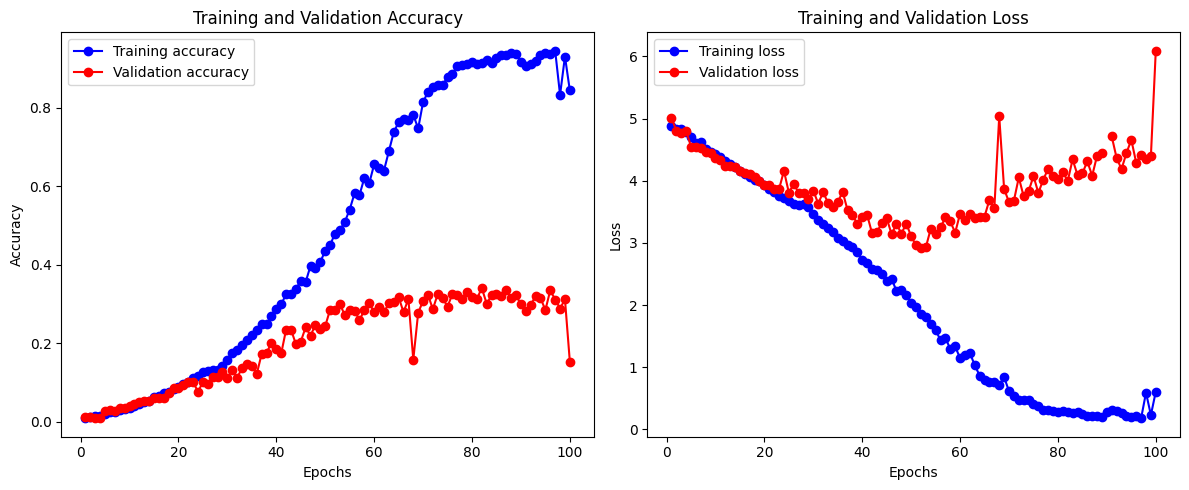

In [17]:
import matplotlib.pyplot as plt

# Extract accuracy and loss values
accuracy = history.history['accuracy']
loss = history.history['loss']

# Check if validation data was used during training
if 'val_accuracy' in history.history:
    val_accuracy = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    has_validation = True
else:
    has_validation = False

# Create epochs range
epochs = range(1, len(accuracy) + 1)

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
if has_validation:
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
if has_validation:
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()